# Isopycnal Mixing Water Mass Analysis

In [1]:
# Imports
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import gsw
import cmocean.cm as cmo
import sys
import pyompa
import scipy.interpolate as interp

## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/analysis/')
from analysis import gsw_rho, profile_mld, get_erddap_dataset, grid_glider_data, dist_from_lat_lon

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')



###################################################################################################################
######################################### Setting for water mass analysis #########################################
###################################################################################################################

#Define a parameter to represent remineralization in terms of phosphate
convertedparamgroups = [
    pyompa.ConvertedParamGroup(
        groupname="phosphate_remin",
        conversion_ratios=[{"oxygen_concentration": -170, "phosphate": 1.0}],
        always_positive=True)
]

paramweightings = {
    "potential_temperature": 1.0,
    "salinity": 1.0,
    "mass": 1.0,
}

settings = {
    "param_names": ["potential_temperature", "salinity", "mass"],
    "convertedparam_groups": convertedparamgroups,
    "param_weightings": paramweightings,
}


## First load glider data

In [2]:
grid_ds_2020 = xr.open_dataset("/home/jg1200/Data/GliderData/RU29/RU29_2020_AD2CP_NC/Gridded/RU29_2020_Gridded_ADCP_CTD.nc")
grid_ds_2021a = xr.open_dataset("/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_1_AD2CP_NC/Gridded/RU29_2021_Mission_1_Gridded_ADCP_CTD.nc")
grid_ds_2021b = xr.open_dataset("/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_2_AD2CP_NC/Gridded/RU29_2021_Mission_2_Gridded_ADCP_CTD.nc")
grid_ds_2022 = xr.open_dataset("/home/jg1200/Data/GliderData/RU36/RU36_03_2022_ADCP/RU36_03_2022_Gridded_ADCP_CTD.nc")


## convert density to sigma0
grid_ds_2020.density.values = gsw.sigma0(grid_ds_2020.sal.values,grid_ds_2020.temp.values)+1000
grid_ds_2021a.density.values = gsw.sigma0(grid_ds_2021a.sal.values,grid_ds_2021a.temp.values)+1000
grid_ds_2021b.density.values = gsw.sigma0(grid_ds_2021b.sal.values,grid_ds_2021b.temp.values)+1000
grid_ds_2022.density.values = gsw.sigma0(grid_ds_2022.sal.values,grid_ds_2022.temp.values)+1000

grid_ds_2020

<xarray.Dataset>
Dimensions:       (depth: 98, lat: 6, transect_num: 15)
Coordinates:
  * depth         (depth) float64 5.0 15.0 25.0 35.0 ... 945.0 955.0 965.0 975.0
  * lat           (lat) float64 17.85 17.9 17.95 18.0 18.05 18.1
  * transect_num  (transect_num) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Data variables:
    u             (depth, lat, transect_num) float64 ...
    v             (depth, lat, transect_num) float64 ...
    temp          (depth, lat, transect_num) float64 29.4 29.24 ... nan nan
    sal           (depth, lat, transect_num) float64 34.99 34.91 ... nan nan
    density       (depth, lat, transect_num) float64 1.022e+03 1.022e+03 ... nan
    time          (lat, transect_num) datetime64[ns] ...
Attributes:
    description:  Processed RU29 AD2CP and CTD data from the 2020 Deployment....

## Then load WOA data

In [3]:
temp_ds = xr.open_dataset('https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/temperature/decav/1.00/woa18_decav_t00_01.nc', decode_times=False)
sal_ds  = xr.open_dataset('https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/salinity/decav/1.00/woa18_decav_s00_01.nc', decode_times=False)
temp_ds

<xarray.Dataset>
Dimensions:             (lat: 180, nbounds: 2, lon: 360, depth: 102, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * depth               (depth) float32 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time                (time) float32 4.326e+03
Dimensions without coordinates: nbounds
Data variables:
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 ...
    lon_bnds            (lon, nbounds) float32 ...
    depth_bnds          (depth, nbounds) float32 ...
    climatology_bounds  (time, nbounds) float32 ...
    t_an                (time, depth, lat, lon) float32 ...
    t_mn                (time, depth, lat, lon) float32 ...
    t_dd                (time, depth, lat, lon) float64 ...
    t_sd                (time, depth, lat, lon) float32 ...
    t_se                (time, depth, lat, lon) float32 ...
    t_oa                (time, depth, lat, lon) float32 ...
    t_gp                (time, depth, lat, lon) float64 ...
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-28 
    date_modified:                   2019-07-28

## Subset for NAW/SAW

In [4]:
###################################################################################################################
### Upper NAW ###
min_lon = -60
max_lon = -40
min_lat = 13
max_lat = 17

## subset
naw_temp_ds1 = temp_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=temp_ds.time[0])
naw_sal_ds1  = sal_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=sal_ds.time[0])

## average profile
naw_mean_temp1 = np.nanmax(naw_temp_ds1.t_mn, axis=(1,2))
naw_mean_sal1  = np.nanmax(naw_sal_ds1.s_mn, axis=(1,2))

## convert to SA and PT and calculate sigma0
naw_mean_sal1 = gsw.SA_from_SP(naw_mean_sal1, naw_sal_ds1.depth.values, -40, -30)
naw_mean_temp1 = gsw.pt0_from_t(naw_mean_sal1, naw_mean_temp1, naw_sal_ds1.depth.values)
naw_mean_den1 = gsw.sigma0(naw_mean_sal1,naw_mean_temp1)+1000

## regular depth grid for all so just use this, do this before subsetting naw_mean_den1
mean_depth = naw_sal_ds1.depth.values[np.where((naw_mean_den1>=1024.5) & (naw_mean_den1 <=1027.6))]

## subset by density
naw_den1_ind = np.where((naw_mean_den1>=1024.5) & (naw_mean_den1 <=1026.3))
naw_mean_sal1 = naw_mean_sal1[naw_den1_ind]
naw_mean_temp1 = naw_mean_temp1[naw_den1_ind]
naw_mean_den1 = naw_mean_den1[naw_den1_ind]

###################################################################################################################
### Lower NAW ###
min_lon = -60
max_lon = -40
min_lat = 23
max_lat = 26

## subset
naw_temp_ds2 = temp_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=temp_ds.time[0])
naw_sal_ds2  = sal_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=sal_ds.time[0])

## average profile
naw_mean_temp2 = np.nanmean(naw_temp_ds2.t_mn, axis=(1,2))
naw_mean_sal2  = np.nanmean(naw_sal_ds2.s_mn, axis=(1,2))

## convert to SA and PT and calculate sigma0
naw_mean_sal2 = gsw.SA_from_SP(naw_mean_sal2, naw_sal_ds2.depth.values, -40, -30)
naw_mean_temp2 = gsw.pt0_from_t(naw_mean_sal2, naw_mean_temp2, naw_sal_ds2.depth.values)
naw_mean_den2 = gsw.sigma0(naw_mean_sal2,naw_mean_temp2)+1000

## subset by density
naw_den2_ind = np.where((naw_mean_den2>=1026.3) & (naw_mean_den2 <=1027.6))
naw_mean_sal2 = naw_mean_sal2[naw_den2_ind]
naw_mean_temp2 = naw_mean_temp2[naw_den2_ind]
naw_mean_den2 = naw_mean_den2[naw_den2_ind]

naw_mean_temp = np.concatenate((naw_mean_temp1,naw_mean_temp2))
naw_mean_sal = np.concatenate((naw_mean_sal1,naw_mean_sal2))
naw_mean_den = gsw.sigma0(naw_mean_sal,naw_mean_temp)+1000

###################################################################################################################
###################################################################################################################
### upper SAW ###
min_lon = 0
max_lon = 10
min_lat = -12
max_lat = -8

## subset
saw_temp_ds1 = temp_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=temp_ds.time[0])
saw_sal_ds1  = sal_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=sal_ds.time[0])

## Make average profiles
saw_mean_temp1 = np.nanmean(saw_temp_ds1.t_mn, axis=(1,2))
saw_mean_sal1  = np.nanmean(saw_sal_ds1.s_mn, axis=(1,2))

## convert to SA and PT and calculate sigma0
saw_mean_sal1 = gsw.SA_from_SP(saw_mean_sal1, saw_sal_ds1.depth.values, -40, -30)
saw_mean_temp1 = gsw.pt0_from_t(saw_mean_sal1, saw_mean_temp1, saw_sal_ds1.depth.values)
saw_mean_den1 = gsw.sigma0(saw_mean_sal1,saw_mean_temp1)+1000

## subset by density
saw_den1_ind = np.where((saw_mean_den1>=1024.5) & (saw_mean_den1 <=1026.3))
saw_mean_sal1 = saw_mean_sal1[saw_den1_ind]
saw_mean_temp1 = saw_mean_temp1[saw_den1_ind]
saw_mean_den1 = saw_mean_den1[saw_den1_ind]

###################################################################################################################
### lower SAW ###
min_lon = -32
max_lon = -28
min_lat = -12
max_lat = -8

## subset
saw_temp_ds2 = temp_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=temp_ds.time[0])
saw_sal_ds2  = sal_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=sal_ds.time[0])

## Make average profiles
saw_mean_temp2 = np.nanmean(saw_temp_ds2.t_mn, axis=(1,2))
saw_mean_sal2  = np.nanmean(saw_sal_ds2.s_mn, axis=(1,2))

## convert to SA and PT and calculate sigma0
saw_mean_sal2 = gsw.SA_from_SP(saw_mean_sal2, saw_sal_ds2.depth.values, -40, -30)
saw_mean_temp2 = gsw.pt0_from_t(saw_mean_sal2, saw_mean_temp2, saw_sal_ds2.depth.values)
saw_mean_den2 = gsw.sigma0(saw_mean_sal2,saw_mean_temp2)+1000

## subset by density
saw_den2_ind = np.where((saw_mean_den2>=1026.3) & (saw_mean_den2 <=1027.6))
saw_mean_sal2 = saw_mean_sal2[saw_den2_ind]
saw_mean_temp2 = saw_mean_temp2[saw_den2_ind]
saw_mean_den2 = saw_mean_den2[saw_den2_ind]

saw_mean_temp = np.concatenate((saw_mean_temp1,saw_mean_temp2))
saw_mean_sal = np.concatenate((saw_mean_sal1,saw_mean_sal2))
saw_mean_den = gsw.sigma0(saw_mean_sal,saw_mean_temp)+1000


## Now subset glider data

In [5]:
subset_ds_2020 = grid_ds_2020.where(grid_ds_2020.density >=1024.5)
subset_ds_2021a = grid_ds_2021a.where(grid_ds_2021a.density >=1024.5)
subset_ds_2021b = grid_ds_2021b.where(grid_ds_2021b.density >=1024.5)
subset_ds_2022 = grid_ds_2022.where(grid_ds_2022.density >=1024.5)


## Save a subset copy for the surface layer

In [6]:
subset_ds_2020_surf = grid_ds_2020.where(grid_ds_2020.density <1024.5)
subset_ds_2021a_surf = grid_ds_2021a.where(grid_ds_2021a.density <1024.5)
subset_ds_2021b_surf = grid_ds_2021b.where(grid_ds_2021b.density <1024.5)
subset_ds_2022_surf = grid_ds_2022.where(grid_ds_2022.density <1024.5)


<a list of 8 text.Text objects>

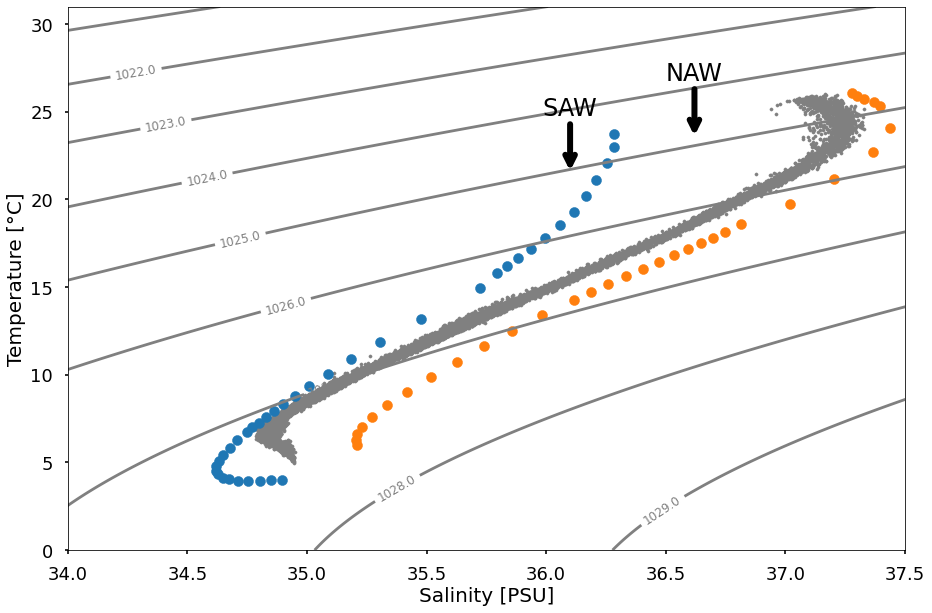

In [7]:
plt.figure(figsize=(15,10))

## markersize
s = 100


plt.scatter(subset_ds_2020.sal.values,subset_ds_2020.temp.values,s=10,c='grey')
plt.scatter(subset_ds_2021a.sal.values,subset_ds_2021a.temp.values,s=10,c='grey')
plt.scatter(subset_ds_2021b.sal.values,subset_ds_2021b.temp.values,s=10,c='grey')
plt.scatter(subset_ds_2022.sal.values,subset_ds_2022.temp.values,s=10,c='grey')



## SAW
plt.scatter(saw_mean_sal,saw_mean_temp,s=s)
plt.annotate(
'SAW', xy=(36.1, 21.5),xytext=(36.1, 24.8) ,
size=24, horizontalalignment="center",
arrowprops=dict(arrowstyle='->',lw=6)
)

## NAW
plt.scatter(naw_mean_sal,naw_mean_temp,s=s)
plt.annotate(
'NAW', xy=(36.62, 23.5),xytext=(36.62, 26.8) ,
size=24, horizontalalignment="center",
arrowprops=dict(arrowstyle='->',lw=6)
)


plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)
plt.ylim(0,31)
plt.xlim(34,37.5)
plt.xlabel('Salinity [PSU]', size=20)
plt.ylabel('Temperature [''\N{DEGREE SIGN}''C]', size=20)

######## This plots the contours
mint=1
maxt=30
mins=34
maxs=37.5
tempL=np.linspace(mint-1,maxt+1,399)
salL=np.linspace(mins-1,maxs+1,399)
Tg, Sg = np.meshgrid(tempL,salL)


z=np.linspace(-1000,0,399)
p = gsw.p_from_z(z,lat=0)
#sigma_theta = gsw.density.rho(Sg, Tg, p)

sigma_theta = gsw.sigma0(Sg, Tg)+1000

#sigma_theta = gsw.sigma0(Sg, Tg)+1000 # ignore effects of pressure on density
cnt = np.linspace(sigma_theta.min(), sigma_theta.max(),399)
ind = np.argwhere(sigma_theta > 1015.7)
st_short = sigma_theta[ind]
#cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1 ,levels=np.arange(1020, 1030,1), vmin = 1020, vmax = 1030)
cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1 ,levels=np.arange(1020, 1037,1), vmin = 1020, vmax = 1037)
levels = cs.levels
manual_locations = [(34.3, 26), (34.4, 25), (34.6,20), (34.75,16), (34.95,12), (35.15,7), (35.4,3), (36.5,2)]
plt.clabel(cs,levels, fontsize=12,inline=True,fmt='%.1f', manual=manual_locations)



## Need to smooth profiles

In [8]:
griddepth = np.arange(5,1001,10)

naw_interp_mean_temp =  interp.griddata(mean_depth,naw_mean_temp,griddepth)
naw_interp_mean_sal =  interp.griddata(mean_depth,naw_mean_sal,griddepth)
naw_interp_mean_den =  interp.griddata(mean_depth,naw_mean_den,griddepth)

saw_interp_mean_temp =  interp.griddata(mean_depth,saw_mean_temp,griddepth)
saw_interp_mean_sal =  interp.griddata(mean_depth,saw_mean_sal,griddepth)
saw_interp_mean_den =  interp.griddata(mean_depth,saw_mean_den,griddepth)


griddepth_2022 = np.arange(10,1001,20)

naw_interp_mean_temp_2022 =  interp.griddata(mean_depth,naw_mean_temp,griddepth_2022)
naw_interp_mean_sal_2022 =  interp.griddata(mean_depth,naw_mean_sal,griddepth_2022)
naw_interp_mean_den_2022 =  interp.griddata(mean_depth,naw_mean_den,griddepth_2022)

saw_interp_mean_temp_2022 =  interp.griddata(mean_depth,saw_mean_temp,griddepth_2022)
saw_interp_mean_sal_2022 =  interp.griddata(mean_depth,saw_mean_sal,griddepth_2022)
saw_interp_mean_den_2022 =  interp.griddata(mean_depth,saw_mean_den,griddepth_2022)




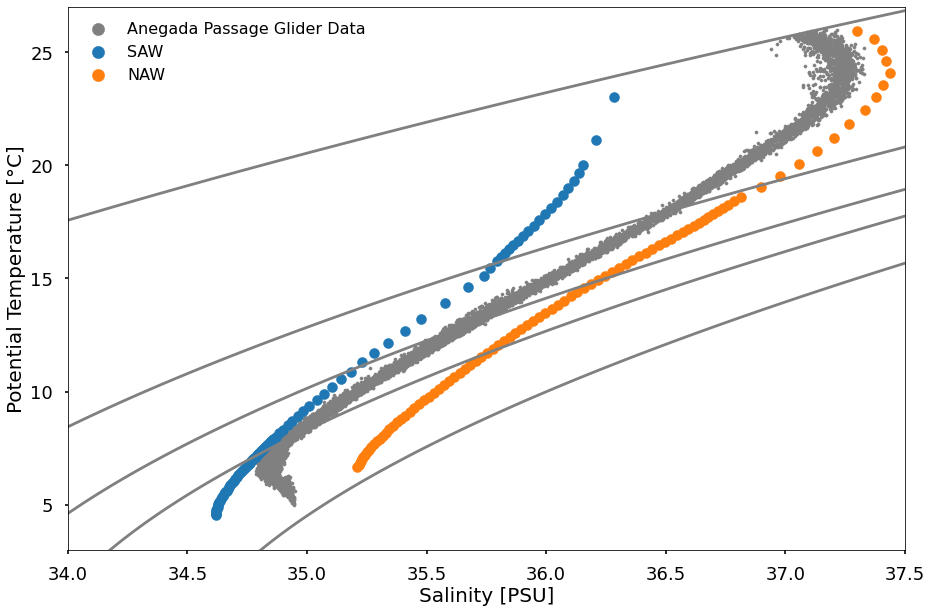

In [9]:
plt.figure(figsize=(15,10))

## markersize
s = 100


plt.scatter(subset_ds_2020.sal.values,subset_ds_2020.temp.values,s=10,c='grey',label='Anegada Passage Glider Data')
plt.scatter(subset_ds_2021a.sal.values,subset_ds_2021a.temp.values,s=10,c='grey')
plt.scatter(subset_ds_2021b.sal.values,subset_ds_2021b.temp.values,s=10,c='grey')
plt.scatter(subset_ds_2022.sal.values,subset_ds_2022.temp.values,s=10,c='grey')



## SAW
plt.scatter(saw_interp_mean_sal,saw_interp_mean_temp,s=s,label='SAW')
## NAW
plt.scatter(naw_interp_mean_sal,naw_interp_mean_temp,s=s,label='NAW')


plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)
plt.ylim(3,27)
plt.xlim(34,37.5)
plt.xlabel('Salinity [PSU]', size=20)
plt.ylabel('Potential Temperature [''\N{DEGREE SIGN}''C]', size=20)
lgnd = plt.legend(frameon=False)
for handle in lgnd.legendHandles:
    handle.set_sizes([150])

######## This plots the contours
mint=1
maxt=30
mins=34
maxs=37.5
tempL=np.linspace(mint-1,maxt+1,399)
salL=np.linspace(mins-1,maxs+1,399)
Tg, Sg = np.meshgrid(tempL,salL)

z=np.linspace(-1000,0,399)
p = gsw.p_from_z(z,lat=0)

sigma_theta = gsw.sigma0(Sg, Tg)+1000

#sigma_theta = gsw.sigma0(Sg, Tg)+1000 # ignore effects of pressure on density
cnt = np.linspace(sigma_theta.min(), sigma_theta.max(),399)
ind = np.argwhere(sigma_theta > 1015.7)
st_short = sigma_theta[ind]
cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1 ,levels=[1024.5,1026.3,1026.8,1027.1,1027.6])
levels = cs.levels
#manual_locations = [(34.3, 26), (34.4, 25), (34.6,20), (34.75,16), (34.95,12), (35.15,7), (35.4,3), (36.5,2)]
#plt.clabel(cs,levels, fontsize=12,inline=True,fmt='%.1f', manual=manual_locations)



## Save end memebers!

In [10]:
d = {'depth': griddepth, 'naw_temp':naw_interp_mean_temp, 'naw_sal': naw_interp_mean_sal,
     'naw_den': naw_interp_mean_den, 'saw_temp': saw_interp_mean_temp, 'saw_sal': saw_interp_mean_sal, 'saw_den':saw_interp_mean_den}

df = pd.DataFrame(data=d)

df.to_csv('/home/jg1200/Data/naw_saw_endmember_t_s_d_profile.csv')




In [11]:
## initialize
NAW =       ["NAW",   np.nan,   np.nan]
SAW =       ["SAW",   np.nan,  np.nan]


def prepare_endmember_df(endmembers_arr):
    df = pd.DataFrame(data=endmembers_arr,
                      columns=["endmember_name", "potential_temperature", "salinity"])
    df["mass"] = 1
    return df

endmemberdf = prepare_endmember_df([NAW, SAW])
endmemberdf

endmember_name  potential_temperature  salinity  mass
0            NAW                    NaN       NaN     1
1            SAW                    NaN       NaN     1

In [12]:

def solve_endmember_fractions_single(df,naw_interp_mean_temp,naw_interp_mean_sal,saw_interp_mean_temp,saw_interp_mean_sal,griddepth):
    
    ## preallocation soln matrix
    naw_frac_df = np.empty(df.temp.shape)
    naw_frac_df[:] = np.nan
    saw_frac_df = np.empty(df.temp.shape)
    saw_frac_df[:] = np.nan

    ## Loop through each row (depth) and perform water mass analysis
    for x in np.arange(0,len(df.depth)):
        
        ## subset to just the depth row of interest and make pandas dataframe
        d = {'potential_temperature': df.temp.values[x,:], 'salinity': df.sal.values[x,:]}
        obs_df = pd.DataFrame(data=d)
        obs_df["mass"] = 1.0

        ## see how many nans there are
        nanlocs = np.where(np.isnan(obs_df['potential_temperature'])==True)[0]
        
        ## skip row if it is all nans
        if len(nanlocs) == len(df.dist):
            pass
        else:
            ## Save location of non-nan indexes for filling sol'n matrix
            nonnanlocs = np.where(np.isnan(obs_df['potential_temperature'])==False)[0]
            ## find matching depth index in source water depth variable
            depth_ind = np.where(griddepth == df.depth.values[x])
            ## oull out NAW and SAW temp and sal
            endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
            endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
            endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
            endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
            ## run analysis
            ompa_soln = pyompa.OMPAProblem(obs_df = obs_df, **settings).solve(endmemberdf,endmember_name_column = "endmember_name")
            ## save soln'n
            naw_frac_df[x,nonnanlocs] = ompa_soln.endmember_fractions[:,0]
            saw_frac_df[x,nonnanlocs] = ompa_soln.endmember_fractions[:,1]
            
    df["naw_frac"]=(['depth', 'dist'],  naw_frac_df)
    df["saw_frac"]=(['depth', 'dist'],  saw_frac_df)

    ############ Now calculate transport!!!!!
    ## preallocate for loop
    transport = np.empty(df.cross_vel.shape)
    transport[:] = np.NaN
    ## calc dz based on depth data
    dz = df.depth.values[1]-df.depth.values[0]
    
    ## loop through and calculate transport in Sv based on dz and dx (dist)
    for x in np.arange(0,len(df.dist)):
        transport[:,x] = (df.cross_vel[:,x].values*dz*df.dist.values[x])/(10**6)
    
    ## now multiply by %naw oand %saw to calculate transport of naw and saw
    naw_transport = transport*naw_frac_df
    saw_transport = transport*saw_frac_df
    
    df["transport"]=(['depth', 'dist'],  transport)
    df["naw_transport"]=(['depth', 'dist'],  naw_transport)
    df["saw_transport"]=(['depth', 'dist'],  saw_transport)
    
    return df


def calc_transport_single(df):
    ############ Now calculate transport!!!!!
    ## preallocate for loop
    transport = np.empty(df.cross_vel.shape)
    transport[:] = np.NaN
    ## calc dz based on depth data
    dz = df.depth.values[1]-df.depth.values[0]
    
    ## loop through and calculate transport in Sv based on dz and dx (dist)
    for x in np.arange(0,len(df.dist)):
        transport[:,x] = (df.cross_vel[:,x].values*dz*df.dist.values[x])/(10**6)

    df["transport"]=(['depth', 'dist'],  transport)

    return df


In [13]:
subset_ds_2021a_surf_final = calc_transport_single(subset_ds_2021a_surf)
subset_ds_2021b_surf_final = calc_transport_single(subset_ds_2021b_surf)

In [14]:
df_2021a_final = solve_endmember_fractions_single(subset_ds_2021a,naw_interp_mean_temp,naw_interp_mean_sal,saw_interp_mean_temp,saw_interp_mean_sal,griddepth)


Dropping 34 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 5 out of 5
status: optimal
optimal value 0.09936074781223468
Original weighted sum squares: 0.09936074781223468
Post fix weighted sum squared: 0.0993607478122351
On example 0 to 5 out of 5
status: optimal
optimal value 0.09936074781223468
Original weighted sum squares: 0.09936074781223468
Post fix weighted sum squared: 0.0993607478122351
objective: 0.09936074781223508
Dropping 20 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 19 out of 19
status: optimal
optimal value 1.602051226271

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 16.47628283178152
Original weighted sum squares: 16.47628283178152
Post fix weighted sum squared: 16.476282831781482
On example 0 to 39 out of 39
status: optimal
optimal value 16.476282831781525
Original weighted sum squares: 16.476282831781525
Post fix weighted sum squared: 16.476282831781482
objective: 16.476282831781482
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 39 out of 39
status: optimal
optimal value 17.021182621134685
Original weighted sum squares: 17.021182621134685
Post fix weighted sum squared: 17.021182621134585
On example 0 to 39 out of 39
status: optimal
optimal value 17.021182621134685
Original weighted sum squares: 17.021182621134685
Post fix weighted sum squared: 17.021182621134585
objective: 17.021182621134585
Endmember-idx mapping is
 OrderedDict([('NAW',

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

 optimal
optimal value 28.992522529100196
Original weighted sum squares: 28.992522529100196
Post fix weighted sum squared: 28.992522529100064
objective: 28.992522529100064
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 39 out of 39
status: optimal
optimal value 30.086518939784604
Original weighted sum squares: 30.086518939784604
Post fix weighted sum squared: 30.086518939784526
On example 0 to 39 out of 39
status: optimal
optimal value 30.086518939784604
Original weighted sum squares: 30.086518939784604
Post fix weighted sum squared: 30.086518939784526
objective: 30.086518939784515
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

 optimal
optimal value 4.0083832592789115
Original weighted sum squares: 4.0083832592789115
Post fix weighted sum squared: 4.008383259278894
objective: 4.008383259278894
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 39 out of 39
status: optimal
optimal value 2.3310570506566766
Original weighted sum squares: 2.3310570506566766
Post fix weighted sum squared: 2.3310570506566424
On example 0 to 39 out of 39
status: optimal
optimal value 2.3310570506566766
Original weighted sum squares: 2.3310570506566766
Post fix weighted sum squared: 2.3310570506566424
objective: 2.3310570506566424
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 39

/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/257236002.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[dept


Original weighted sum squares: 0.6812516133443574
Post fix weighted sum squared: 0.6812516133443135
objective: 0.6812516133443135
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 39 out of 39
status: optimal
optimal value 0.6678499848631531
Original weighted sum squares: 0.6678499848631531
Post fix weighted sum squared: 0.6678499848631275
On example 0 to 39 out of 39
status: optimal
optimal value 0.6678499848631531
Original weighted sum squares: 0.6678499848631531
Post fix weighted sum squared: 0.6678499848631275
objective: 0.6678499848631274
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 39 out of 39
status: optimal
optimal valu

/tmp/ipykernel_30289/257236002.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_

status: optimal
optimal value 0.7027596053885565
Original weighted sum squares: 0.7027596053885565
Post fix weighted sum squared: 0.702759605388554
On example 0 to 39 out of 39
status: optimal
optimal value 0.7027596053885565
Original weighted sum squares: 0.7027596053885565
Post fix weighted sum squared: 0.702759605388554
objective: 0.702759605388554
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 39 out of 39
status: optimal
optimal value 0.6747383221872975
Original weighted sum squares: 0.6747383221872975
Post fix weighted sum squared: 0.674738322187327
On example 0 to 39 out of 39
status: optimal
optimal value 0.6747383221872975
Original weighted sum squares: 0.6747383221872975
Post fix weighted sum squared: 0.674738322187327
objective: 0.6747383221873269
Endmember-idx mapping is
 OrderedDict([('NAW', [0

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.801016128419049
Original weighted sum squares: 0.801016128419049
Post fix weighted sum squared: 0.8010161284190072
On example 0 to 39 out of 39
status: optimal
optimal value 0.801016128419049
Original weighted sum squares: 0.801016128419049
Post fix weighted sum squared: 0.8010161284190072
objective: 0.8010161284190069
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 39 out of 39
status: optimal
optimal value 0.7801313402566368
Original weighted sum squares: 0.7801313402566368
Post fix weighted sum squared: 0.7801313402566414
On example 0 to 39 out of 39
status: optimal
optimal value 0.7801313402566368
Original weighted sum squares: 0.7801313402566368
Post fix weighted sum squared: 0.7801313402566414
objective: 0.7801313402566414
Endmember-idx mapping is
 OrderedDict([('NAW', [

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.7408956763645194
Original weighted sum squares: 0.7408956763645194
Post fix weighted sum squared: 0.7408956763645091
On example 0 to 39 out of 39
status: optimal
optimal value 0.7408956763645194
Original weighted sum squares: 0.7408956763645194
Post fix weighted sum squared: 0.7408956763645091
objective: 0.740895676364509
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 39 out of 39
status: optimal
optimal value 0.7518032636151564
Original weighted sum squares: 0.7518032636151564
Post fix weighted sum squared: 0.7518032636151365
On example 0 to 39 out of 39
status: optimal
optimal value 0.7518032636151564
Original weighted sum squares: 0.7518032636151564
Post fix weighted sum squared: 0.7518032636151365
objective: 0.7518032636151364
Endmember-idx mapping is
 OrderedDict([('NAW'

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.621448252949682
Original weighted sum squares: 0.621448252949682
Post fix weighted sum squared: 0.6214482529496885
On example 0 to 38 out of 38
status: optimal
optimal value 0.621448252949682
Original weighted sum squares: 0.621448252949682
Post fix weighted sum squared: 0.6214482529496885
objective: 0.6214482529496885
Dropping 1 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 38 out of 38
status: optimal
optimal value 0.6039941289117513
Original weighted sum squares: 0.6039941289117513
Post fix weighted sum squared: 0.6039941289116904
On example 0 to 38 out of 38
status: optimal
optimal value 0.6039941289117513
Original weighted sum squares: 0.6039941289117513
Post fix weighted sum squared: 0.6039941289116904
objective: 0.603994128

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.41343055357995917
Original weighted sum squares: 0.41343055357995917
Post fix weighted sum squared: 0.41343055358002156
On example 0 to 36 out of 36
status: optimal
optimal value 0.41343055357995917
Original weighted sum squares: 0.41343055357995917
Post fix weighted sum squared: 0.41343055358002156
objective: 0.41343055358002156
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 36 out of 36
status: optimal
optimal value 0.3717902177143052
Original weighted sum squares: 0.3717902177143052
Post fix weighted sum squared: 0.3717902177142845
On example 0 to 36 out of 36
status: optimal
optimal value 0.3717902177143052
Original weighted sum squares: 0.3717902177143052
Post fix weighted sum squared: 0.3717902177142845
objective: 

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.1659546413364032
Original weighted sum squares: 0.1659546413364032
Post fix weighted sum squared: 0.16595464133641452
On example 0 to 34 out of 34
status: optimal
optimal value 0.1659546413364032
Original weighted sum squares: 0.1659546413364032
Post fix weighted sum squared: 0.16595464133641452
objective: 0.1659546413364145
Dropping 5 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 34 out of 34
status: optimal
optimal value 0.1542966980496951
Original weighted sum squares: 0.1542966980496951
Post fix weighted sum squared: 0.1542966980496907
On example 0 to 34 out of 34
status: optimal
optimal value 0.1542966980496951
Original weighted sum squares: 0.1542966980496951
Post fix weighted sum squared: 0.1542966980496907
objective: 0.154

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.09886258176079674
Original weighted sum squares: 0.09886258176079674
Post fix weighted sum squared: 0.09886258176080281
On example 0 to 32 out of 32
status: optimal
optimal value 0.09886258176079674
Original weighted sum squares: 0.09886258176079674
Post fix weighted sum squared: 0.09886258176080281
objective: 0.09886258176080283
Dropping 8 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.08547195345173203
Original weighted sum squares: 0.08547195345173203
Post fix weighted sum squared: 0.08547195345174191
On example 0 to 31 out of 31
status: optimal
optimal value 0.08547195345173203
Original weighted sum squares: 0.08547195345173203
Post fix weighted sum squared: 0.08547195345174191
objec

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.05052637710826093
Original weighted sum squares: 0.05052637710826093
Post fix weighted sum squared: 0.05052637710824596
On example 0 to 29 out of 29
status: optimal
optimal value 0.05052637710826093
Original weighted sum squares: 0.05052637710826093
Post fix weighted sum squared: 0.05052637710824596
objective: 0.05052637710824596
Dropping 10 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 29 out of 29
status: optimal
optimal value 0.04443015531965701
Original weighted sum squares: 0.04443015531965701
Post fix weighted sum squared: 0.044430155319656564
On example 0 to 29 out of 29
status: optimal
optimal value 0.04443015531965701
Original weighted sum squares: 0.04443015531965701
Post fix weighted sum squared: 0.044430155319656564
ob

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.022981052530639316
Original weighted sum squares: 0.022981052530639316
Post fix weighted sum squared: 0.02298105253063836
On example 0 to 26 out of 26
status: optimal
optimal value 0.022981052530639316
Original weighted sum squares: 0.022981052530639316
Post fix weighted sum squared: 0.02298105253063836
objective: 0.02298105253063836
Dropping 13 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 26 out of 26
status: optimal
optimal value 0.02294556344735323
Original weighted sum squares: 0.02294556344735323
Post fix weighted sum squared: 0.022945563447350537
On example 0 to 26 out of 26
status: optimal
optimal value 0.02294556344735323
Original weighted sum squares: 0.02294556344735323
Post fix weighted sum squared: 0.02294556344735053

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

In [15]:
df_2021a_final

<xarray.Dataset>
Dimensions:        (depth: 98, dist: 39)
Coordinates:
  * depth          (depth) float64 5.0 15.0 25.0 35.0 ... 955.0 965.0 975.0
  * dist           (dist) float64 2.909e+03 3.465e+03 ... 2.001e+03 1.936e+03
Data variables:
    cross_vel      (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    along_vel      (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    temp           (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    sal            (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    density        (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    naw_frac       (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    saw_frac       (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    transport      (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    naw_transport  (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    saw_transport  (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    description:  Processed RU29 AD2CP and CTD data from the 2021 Deployment ...

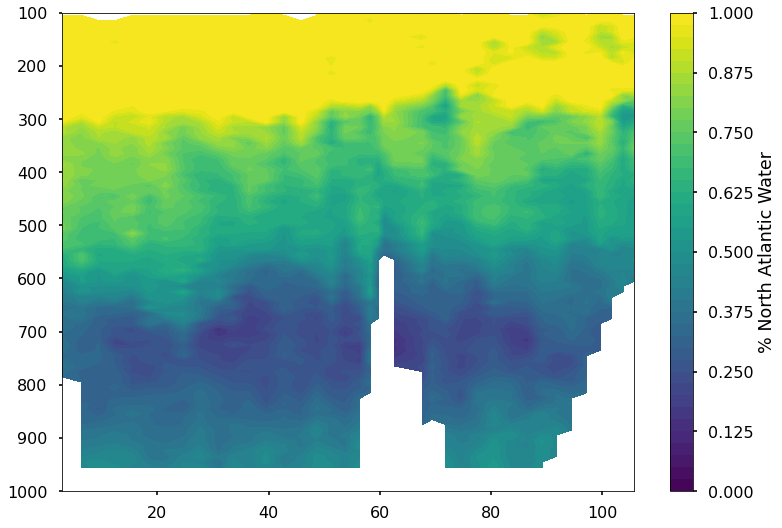

In [16]:
plt.contourf(np.cumsum(df_2021a_final.dist)/1000,df_2021a_final.depth,df_2021a_final.naw_frac,levels=np.arange(0,1.01,0.025))
plt.ylim(1000,100)
plt.colorbar(label='% North Atlantic Water')

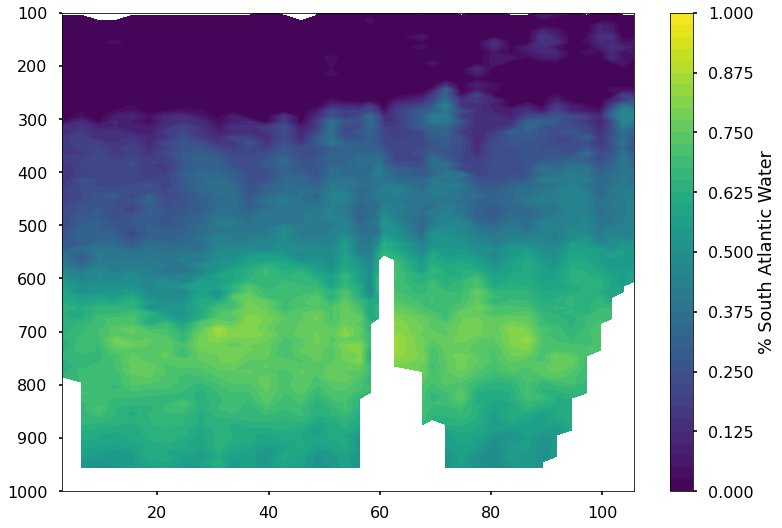

In [17]:
plt.contourf(np.cumsum(df_2021a_final.dist)/1000,df_2021a_final.depth,df_2021a_final.saw_frac,levels=np.arange(0,1.01,0.025))
plt.ylim(1000,100)
plt.colorbar(label='% South Atlantic Water')

In [18]:
df_2021b_final = solve_endmember_fractions_single(subset_ds_2021b,naw_interp_mean_temp,naw_interp_mean_sal,saw_interp_mean_temp,saw_interp_mean_sal,griddepth)


Dropping 25 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 9 out of 9
status: optimal
optimal value 1.0610895293090645
Original weighted sum squares: 1.0610895293090645
Post fix weighted sum squared: 1.061089529309065
On example 0 to 9 out of 9
status: optimal
optimal value 1.0610895293090645
Original weighted sum squares: 1.0610895293090645
Post fix weighted sum squared: 1.061089529309065
objective: 1.061089529309065
Dropping 10 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 24 out of 24
status: optimal
optimal value 9.134899463860922
Orig

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 19.915567548943486
Original weighted sum squares: 19.915567548943486
Post fix weighted sum squared: 19.915567548943372
objective: 19.915567548943375
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 19.811561475292294
Original weighted sum squares: 19.811561475292294
Post fix weighted sum squared: 19.811561475292198
On example 0 to 31 out of 31
status: optimal
optimal value 19.811561475292294
Original weighted sum squares: 19.811561475292294
Post fix weighted sum squared: 19.811561475292198
objective: 19.811561475292194
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', '

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 13.180490718265617
Original weighted sum squares: 13.180490718265617
Post fix weighted sum squared: 13.180490718265576
On example 0 to 31 out of 31
status: optimal
optimal value 13.180490718265617
Original weighted sum squares: 13.180490718265617
Post fix weighted sum squared: 13.180490718265576
objective: 13.180490718265572
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 8.303933644269197
Original weighted sum squares: 8.303933644269197
Post fix weighted sum squared: 8.303933644269218
On example 0 to 31 out of 31
status: optimal
optimal value 8.303933644269197
Original weighted sum squares: 8.303933644269197
Post fix weighted sum squared: 8.303933644269218
objective: 8.30393364426

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.36364742152279966
Original weighted sum squares: 0.36364742152279966
Post fix weighted sum squared: 0.3636474215228087
On example 0 to 31 out of 31
status: optimal
optimal value 0.36364742152279966
Original weighted sum squares: 0.36364742152279966
Post fix weighted sum squared: 0.3636474215228087
objective: 0.3636474215228088
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.30158094012411474
Original weighted sum squares: 0.30158094012411474
Post fix weighted sum squared: 0.3015809401241442
On example 0 to 31 out of 31
status: optimal
optimal value 0.30158094012411474
Original weighted sum squares: 0.30158094012411474
Post fix weighted sum squared: 0.3015809401241442
objective:

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.24636533650327674
Original weighted sum squares: 0.24636533650327674
Post fix weighted sum squared: 0.24636533650327952
On example 0 to 31 out of 31
status: optimal
optimal value 0.24636533650327674
Original weighted sum squares: 0.24636533650327674
Post fix weighted sum squared: 0.24636533650327952
objective: 0.24636533650327955
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.2413834497934896
Original weighted sum squares: 0.2413834497934896
Post fix weighted sum squared: 0.24138344979350734
On example 0 to 31 out of 31
status: optimal
optimal value 0.2413834497934896
Original weighted sum squares: 0.2413834497934896
Post fix weighted sum squared: 0.24138344979350734
objective

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.309463369691285
Original weighted sum squares: 0.309463369691285
Post fix weighted sum squared: 0.3094633696912656
On example 0 to 31 out of 31
status: optimal
optimal value 0.309463369691285
Original weighted sum squares: 0.309463369691285
Post fix weighted sum squared: 0.3094633696912656
objective: 0.30946336969126553
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.3298034615929402
Original weighted sum squares: 0.3298034615929402
Post fix weighted sum squared: 0.3298034615929509
On example 0 to 31 out of 31
status: optimal
optimal value 0.3298034615929402
Original weighted sum squares: 0.3298034615929402
Post fix weighted sum squared: 0.3298034615929509
objective: 0.32980346

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.45311132933063253
Original weighted sum squares: 0.45311132933063253
Post fix weighted sum squared: 0.4531113293306273
On example 0 to 31 out of 31
status: optimal
optimal value 0.45311132933063253
Original weighted sum squares: 0.45311132933063253
Post fix weighted sum squared: 0.4531113293306273
objective: 0.4531113293306273
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.4334741420876956
Original weighted sum squares: 0.4334741420876956
Post fix weighted sum squared: 0.43347414208768187
On example 0 to 31 out of 31
status: optimal
optimal value 0.4334741420876956
Original weighted sum squares: 0.4334741420876956
Post fix weighted sum squared: 0.43347414208768187
objective: 0

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.36853201616546344
Original weighted sum squares: 0.36853201616546344
Post fix weighted sum squared: 0.36853201616546616
On example 0 to 31 out of 31
status: optimal
optimal value 0.36853201616546344
Original weighted sum squares: 0.36853201616546344
Post fix weighted sum squared: 0.36853201616546616
objective: 0.3685320161654662
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.3479320262673714
Original weighted sum squares: 0.3479320262673714
Post fix weighted sum squared: 0.34793202626733044
On example 0 to 31 out of 31
status: optimal
optimal value 0.3479320262673714
Original weighted sum squares: 0.3479320262673714
Post fix weighted sum squared: 0.34793202626733044
objective:

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.23673811013105572
Original weighted sum squares: 0.23673811013105572
Post fix weighted sum squared: 0.23673811013109775
On example 0 to 31 out of 31
status: optimal
optimal value 0.23673811013105572
Original weighted sum squares: 0.23673811013105572
Post fix weighted sum squared: 0.23673811013109775
objective: 0.23673811013109772
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.19118263497737725
Original weighted sum squares: 0.19118263497737725
Post fix weighted sum squared: 0.1911826349773618
On example 0 to 31 out of 31
status: optimal
optimal value 0.19118263497737725
Original weighted sum squares: 0.19118263497737725
Post fix weighted sum squared: 0.1911826349773618
objecti

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.08301501141772878
Original weighted sum squares: 0.08301501141772878
Post fix weighted sum squared: 0.08301501141773958
On example 0 to 31 out of 31
status: optimal
optimal value 0.08301501141772878
Original weighted sum squares: 0.08301501141772878
Post fix weighted sum squared: 0.08301501141773958
objective: 0.08301501141773962
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.06317798758051754
Original weighted sum squares: 0.06317798758051754
Post fix weighted sum squared: 0.06317798758051618
On example 0 to 31 out of 31
status: optimal
optimal value 0.06317798758051754
Original weighted sum squares: 0.06317798758051754
Post fix weighted sum squared: 0.06317798758051618
objec

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.026570435273056206
Original weighted sum squares: 0.026570435273056206
Post fix weighted sum squared: 0.026570435273060022
On example 0 to 31 out of 31
status: optimal
optimal value 0.026570435273056206
Original weighted sum squares: 0.026570435273056206
Post fix weighted sum squared: 0.026570435273060022
objective: 0.026570435273060022
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.024283670955380966
Original weighted sum squares: 0.024283670955380966
Post fix weighted sum squared: 0.024283670955384393
On example 0 to 31 out of 31
status: optimal
optimal value 0.024283670955380966
Original weighted sum squares: 0.024283670955380966
Post fix weighted sum squared: 0.02428367095

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.04763137331757169
Original weighted sum squares: 0.04763137331757169
Post fix weighted sum squared: 0.04763137331759798
On example 0 to 31 out of 31
status: optimal
optimal value 0.04763137331757169
Original weighted sum squares: 0.04763137331757169
Post fix weighted sum squared: 0.04763137331759798
objective: 0.04763137331759798
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.06516627254904254
Original weighted sum squares: 0.06516627254904254
Post fix weighted sum squared: 0.06516627254905975
On example 0 to 31 out of 31
status: optimal
optimal value 0.06516627254904254
Original weighted sum squares: 0.06516627254904254
Post fix weighted sum squared: 0.06516627254905975
objec

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

status: optimal
optimal value 0.22200368388928385
Original weighted sum squares: 0.22200368388928385
Post fix weighted sum squared: 0.22200368388934674
On example 0 to 31 out of 31
status: optimal
optimal value 0.22200368388928385
Original weighted sum squares: 0.22200368388928385
Post fix weighted sum squared: 0.22200368388934674
objective: 0.22200368388934674
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 31 out of 31
status: optimal
optimal value 0.26749762816566647
Original weighted sum squares: 0.26749762816566647
Post fix weighted sum squared: 0.26749762816572964
On example 0 to 31 out of 31
status: optimal
optimal value 0.26749762816566647
Original weighted sum squares: 0.26749762816566647
Post fix weighted sum squared: 0.26749762816572964
objec

/tmp/ipykernel_30289/257236002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/257236002.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp

In [19]:
df_2021b_final

<xarray.Dataset>
Dimensions:        (depth: 102, dist: 34)
Coordinates:
  * depth          (depth) float64 5.0 15.0 25.0 ... 995.0 1.005e+03 1.015e+03
  * dist           (dist) float64 2.952e+03 3.352e+03 ... 2.71e+03 2.97e+03
Data variables:
    cross_vel      (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    along_vel      (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    temp           (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    sal            (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    density        (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    naw_frac       (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    saw_frac       (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    transport      (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    naw_transport  (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
    saw_transport  (depth, dist) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    description:  Processed RU29 AD2CP and CTD data from the 2021 Deployment ...

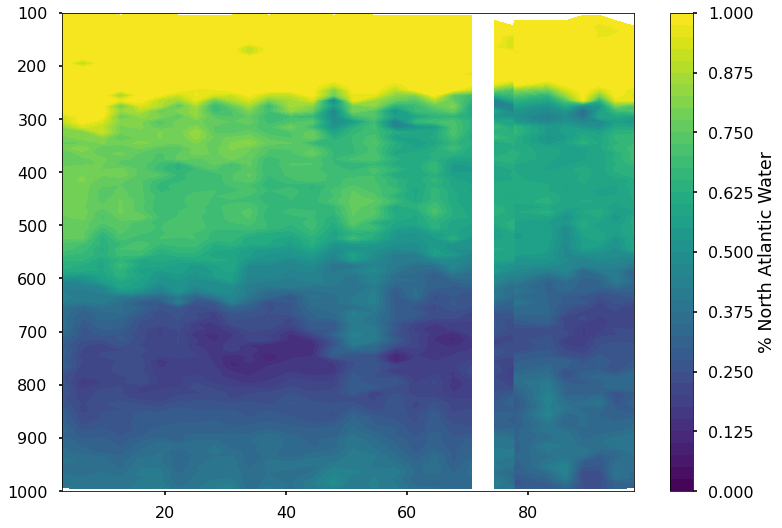

In [20]:
plt.contourf(np.cumsum(df_2021b_final.dist)/1000,df_2021b_final.depth,df_2021b_final.naw_frac,levels=np.arange(0,1.01,0.025))
plt.ylim(1000,100)
plt.colorbar(label='% North Atlantic Water')

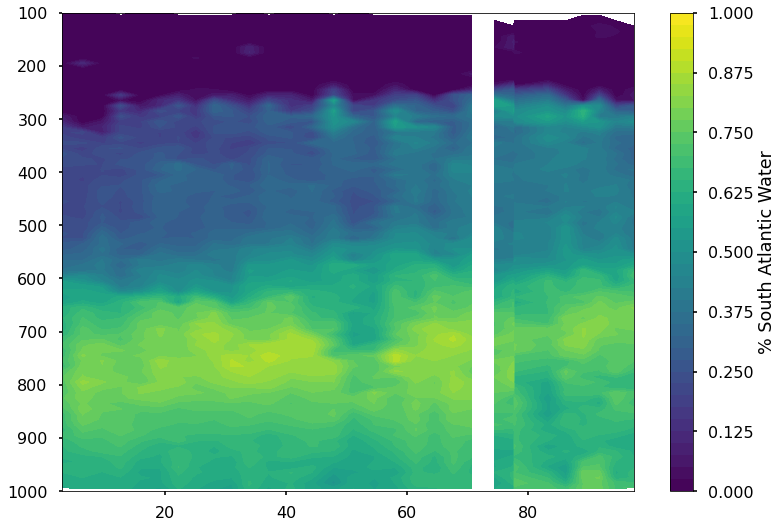

In [21]:
plt.contourf(np.cumsum(df_2021b_final.dist)/1000,df_2021b_final.depth,df_2021b_final.saw_frac,levels=np.arange(0,1.01,0.025))
plt.ylim(1000,100)
plt.colorbar(label='% South Atlantic Water')

## 2021a

In [22]:
np.nansum(df_2021a_final.naw_transport)

-2.564147143993502

In [23]:
np.nansum(df_2021a_final.saw_transport)

-1.4329378047629988

In [24]:
np.nansum(df_2021a_final.transport)

-3.997084948756501

In [25]:
np.nansum(df_2021a_final.naw_transport)/np.nansum(df_2021a_final.transport)

0.6415042904682854

In [26]:
np.nansum(df_2021a_final.saw_transport)/np.nansum(df_2021a_final.transport)

0.35849570953171456

### just surface layer now

In [27]:
np.nansum(df_2021a_final.saw_transport)+np.nansum(subset_ds_2021a_surf_final.transport)

-1.8311461600509642

## total SAW transport now

In [28]:
np.nansum(subset_ds_2021a_surf_final.transport)

-0.3982083552879654

## 2021b

In [29]:
np.nansum(df_2021b_final.naw_transport)

-2.8791003053357525

In [30]:
np.nansum(df_2021b_final.saw_transport)

-1.957188479728266

In [31]:
np.nansum(df_2021b_final.transport)

-4.836288785064019

In [32]:
np.nansum(df_2021b_final.naw_transport)/np.nansum(df_2021b_final.transport)

0.5953119082192362

In [33]:
np.nansum(df_2021b_final.saw_transport)/np.nansum(df_2021b_final.transport)

0.4046880917807637

### just surface layer now

In [34]:
np.nansum(df_2021b_final.saw_transport)+np.nansum(subset_ds_2021b_surf_final.transport)

-2.32990682232375

### total SAW now

In [35]:
np.nansum(subset_ds_2021b_surf_final.transport)

-0.37271834259548375

# Now do it for the repeat transects for the 2020 and 2022 deployments

In [36]:

def solve_endmember_fractions_multiple(df,naw_interp_mean_temp,naw_interp_mean_sal,saw_interp_mean_temp,saw_interp_mean_sal,griddepth):

    ## preallocation soln matrix
    naw_frac_df = np.empty(df.temp.shape)
    naw_frac_df[:] = np.nan
    saw_frac_df = np.empty(df.temp.shape)
    saw_frac_df[:] = np.nan

    ## Loop through each transect
    for y in np.arange(0,len(df.transect_num)):

        ## Then loop through each row (depth) and perform water mass analysis
        for x in np.arange(0,len(df.depth)):

            ## subset to just the depth row of interest and make pandas dataframe
            d = {'potential_temperature': df.temp.values[x,:,y], 'salinity': df.sal.values[x,:,y]}
            obs_df = pd.DataFrame(data=d)
            obs_df["mass"] = 1.0

            ## see how many nans there are
            nanlocs = np.where(np.isnan(obs_df['potential_temperature'])==True)[0]

            ## skip row if it is all nans
            if len(nanlocs) == len(df.lat):
                pass
            else:
                ## Save location of non-nan indexes for filling sol'n matrix
                nonnanlocs = np.where(np.isnan(obs_df['potential_temperature'])==False)[0]
                ## find matching depth index in source water depth variable
                depth_ind = np.where(griddepth == df.depth.values[x])
                ## oull out NAW and SAW temp and sal
                endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
                endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
                endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
                endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
                ## run analysis
                ompa_soln = pyompa.OMPAProblem(obs_df = obs_df, **settings).solve(endmemberdf,endmember_name_column = "endmember_name")
                ## save soln'n
                naw_frac_df[x,nonnanlocs,y] = ompa_soln.endmember_fractions[:,0]
                saw_frac_df[x,nonnanlocs,y] = ompa_soln.endmember_fractions[:,1]

    df["naw_frac"]=(['depth', 'lat', 'transect_num'],  naw_frac_df)
    df["saw_frac"]=(['depth', 'lat', 'transect_num'],  saw_frac_df)

    ############ Now calculate transport!!!!!
    ## preallocate for loop
    transport = np.empty(df.temp.shape)
    transport[:] = np.NaN
    ## calc dz based on depth data
    dz = df.depth.values[1]-df.depth.values[0]
    ## lon hard-coded due to grid design
    distance = dist_from_lat_lon(subset_ds_2020.lat[0], -64.80, subset_ds_2020.lat[1], -64.80)

    ## loop through and calculate transport in Sv based on dz and dx (dist)
    for x in np.arange(0,len(df.transect_num)):
        transport[:,:,x] = (df.u[:,:,x].values*dz*distance)/(10**6)

    ## now multiply by %naw oand %saw to calculate transport of naw and saw
    naw_transport = transport*naw_frac_df
    saw_transport = transport*saw_frac_df

    df["transport"]=(['depth', 'lat', 'transect_num'],  transport)
    df["naw_transport"]=(['depth', 'lat', 'transect_num'],  naw_transport)
    df["saw_transport"]=(['depth', 'lat', 'transect_num'],  saw_transport)

    return df







def calc_transport_multiple(df):
    ############ Now calculate transport!!!!!
    ## preallocate for loop
    transport = np.empty(df.temp.shape)
    transport[:] = np.NaN
    ## calc dz based on depth data
    dz = df.depth.values[1]-df.depth.values[0]
    ## lon hard-coded due to grid design
    distance = dist_from_lat_lon(subset_ds_2020.lat[0], -64.80, subset_ds_2020.lat[1], -64.80)

    ## loop through and calculate transport in Sv based on dz and dx (dist)
    for x in np.arange(0,len(df.transect_num)):
        transport[:,:,x] = (df.u[:,:,x].values*dz*distance)/(10**6)

    df["transport"]=(['depth', 'lat', 'transect_num'],  transport)

    return df



In [37]:
subset_ds_2020_surf_final = calc_transport_multiple(subset_ds_2020_surf)
subset_ds_2022_surf_final = calc_transport_multiple(subset_ds_2022_surf)

In [38]:
subset_ds_2020

<xarray.Dataset>
Dimensions:       (depth: 98, lat: 6, transect_num: 15)
Coordinates:
  * depth         (depth) float64 5.0 15.0 25.0 35.0 ... 945.0 955.0 965.0 975.0
  * lat           (lat) float64 17.85 17.9 17.95 18.0 18.05 18.1
  * transect_num  (transect_num) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Data variables:
    u             (depth, lat, transect_num) float64 nan nan nan ... nan nan nan
    v             (depth, lat, transect_num) float64 nan nan nan ... nan nan nan
    temp          (depth, lat, transect_num) float64 nan nan nan ... nan nan nan
    sal           (depth, lat, transect_num) float64 nan nan nan ... nan nan nan
    density       (depth, lat, transect_num) float64 nan nan nan ... nan nan nan
    time          (lat, transect_num, depth) datetime64[ns] NaT NaT ... NaT
Attributes:
    description:  Processed RU29 AD2CP and CTD data from the 2020 Deployment....

In [39]:
df_2020_final = solve_endmember_fractions_multiple(subset_ds_2020,naw_interp_mean_temp,naw_interp_mean_sal,saw_interp_mean_temp,saw_interp_mean_sal,griddepth)


Dropping 5 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 1 out of 1
status: optimal
optimal value 0.10061590443975327
Original weighted sum squares: 0.10061590443975327
Post fix weighted sum squared: 0.10061590443975327
On example 0 to 1 out of 1
status: optimal
optimal value 0.10061590443975327
Original weighted sum squares: 0.10061590443975327
Post fix weighted sum squared: 0.10061590443975327
objective: 0.10061590443975327
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.3185905204130868
Original weighted sum squares: 1.3185905204130868
Pos

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 1.413047384208404
Original weighted sum squares: 1.413047384208404
Post fix weighted sum squared: 1.4130473842084015
objective: 1.4130473842084013
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.8170673492975649
Original weighted sum squares: 1.8170673492975649
Post fix weighted sum squared: 1.817067349297559
On example 0 to 6 out of 6
status: optimal
optimal value 1.8170673492975649
Original weighted sum squares: 1.8170673492975649
Post fix weighted sum squared: 1.817067349297559
objective: 1.817067349297559
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 2.363808278594312
Original weighted sum squares: 2.363808278594312
Post fix weighted sum squared: 2.3638082785942856
objective: 2.3638082785942856
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 2.056451935852489
Original weighted sum squares: 2.056451935852489
Post fix weighted sum squared: 2.056451935852478
On example 0 to 6 out of 6
status: optimal
optimal value 2.056451935852489
Original weighted sum squares: 2.056451935852489
Post fix weighted sum squared: 2.056451935852478
objective: 2.0564519358524778
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.23307510378681442
Original weighted sum squares: 0.23307510378681442
Post fix weighted sum squared: 0.2330751037868078
objective: 0.2330751037868078
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.17728518722109093
Original weighted sum squares: 0.17728518722109093
Post fix weighted sum squared: 0.17728518722108733
On example 0 to 6 out of 6
status: optimal
optimal value 0.17728518722109093
Original weighted sum squares: 0.17728518722109093
Post fix weighted sum squared: 0.17728518722108733
objective: 0.1772851872210873
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On ex

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.1358347531121323
Original weighted sum squares: 0.1358347531121323
Post fix weighted sum squared: 0.13583475311213444
objective: 0.13583475311213447
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1267068885433872
Original weighted sum squares: 0.1267068885433872
Post fix weighted sum squared: 0.12670688854338735
On example 0 to 6 out of 6
status: optimal
optimal value 0.1267068885433872
Original weighted sum squares: 0.1267068885433872
Post fix weighted sum squared: 0.12670688854338735
objective: 0.12670688854338735
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On examp

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.1338143753291134
Original weighted sum squares: 0.1338143753291134
Post fix weighted sum squared: 0.1338143753291134
objective: 0.1338143753291134
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.13647489849574876
Original weighted sum squares: 0.13647489849574876
Post fix weighted sum squared: 0.13647489849574518
On example 0 to 6 out of 6
status: optimal
optimal value 0.13647489849574876
Original weighted sum squares: 0.13647489849574876
Post fix weighted sum squared: 0.13647489849574518
objective: 0.13647489849574518
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exa

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.12340532297381554
Original weighted sum squares: 0.12340532297381554
Post fix weighted sum squared: 0.12340532297380376
objective: 0.12340532297380374
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1132286310781434
Original weighted sum squares: 0.1132286310781434
Post fix weighted sum squared: 0.1132286310781434
On example 0 to 6 out of 6
status: optimal
optimal value 0.1132286310781434
Original weighted sum squares: 0.1132286310781434
Post fix weighted sum squared: 0.1132286310781434
objective: 0.1132286310781434
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exampl

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.06313243754816285
Original weighted sum squares: 0.06313243754816285
Post fix weighted sum squared: 0.06313243754817352
objective: 0.06313243754817353
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.06300581177014945
Original weighted sum squares: 0.06300581177014945
Post fix weighted sum squared: 0.0630058117701467
On example 0 to 6 out of 6
status: optimal
optimal value 0.06300581177014945
Original weighted sum squares: 0.06300581177014945
Post fix weighted sum squared: 0.0630058117701467
objective: 0.0630058117701467
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On ex

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.031738307022415854
Original weighted sum squares: 0.031738307022415854
Post fix weighted sum squared: 0.03173830702241405
objective: 0.03173830702241405
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.028671186511002866
Original weighted sum squares: 0.028671186511002866
Post fix weighted sum squared: 0.028671186510995487
On example 0 to 6 out of 6
status: optimal
optimal value 0.028671186511002866
Original weighted sum squares: 0.028671186511002866
Post fix weighted sum squared: 0.028671186510995487
objective: 0.028671186510995483
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.011935889581035402
Original weighted sum squares: 0.011935889581035402
Post fix weighted sum squared: 0.011935889581037975
objective: 0.011935889581037973
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.012744639917862614
Original weighted sum squares: 0.012744639917862614
Post fix weighted sum squared: 0.012744639917863497
On example 0 to 6 out of 6
status: optimal
optimal value 0.012744639917862614
Original weighted sum squares: 0.012744639917862614
Post fix weighted sum squared: 0.012744639917863497
objective: 0.012744639917863497
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constra

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.0041831266139063985
Original weighted sum squares: 0.0041831266139063985
Post fix weighted sum squared: 0.004183126613905125
objective: 0.004183126613905124
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.0040149381786948385
Original weighted sum squares: 0.0040149381786948385
Post fix weighted sum squared: 0.004014938178694873
On example 0 to 6 out of 6
status: optimal
optimal value 0.0040149381786948385
Original weighted sum squares: 0.0040149381786948385
Post fix weighted sum squared: 0.004014938178694873
objective: 0.004014938178694874
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign c

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.01568898292482421
Original weighted sum squares: 0.01568898292482421
Post fix weighted sum squared: 0.01568898292482797
objective: 0.015688982924827965
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 3 out of 3
status: optimal
optimal value 0.03307009698090117
Original weighted sum squares: 0.03307009698090117
Post fix weighted sum squared: 0.033070096980899855
On example 0 to 3 out of 3
status: optimal
optimal value 0.03307009698090117
Original weighted sum squares: 0.03307009698090117
Post fix weighted sum squared: 0.033070096980899855
objective: 0.033070096980899855
Dropping 1 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temp

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 1.6167592216668252
Original weighted sum squares: 1.6167592216668252
Post fix weighted sum squared: 1.6167592216668127
objective: 1.616759221666813
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.3217204039910273
Original weighted sum squares: 1.3217204039910273
Post fix weighted sum squared: 1.3217204039910302
On example 0 to 6 out of 6
status: optimal
optimal value 1.3217204039910273
Original weighted sum squares: 1.3217204039910273
Post fix weighted sum squared: 1.3217204039910302
objective: 1.3217204039910302
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 t

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 2.656509821695794
Original weighted sum squares: 2.656509821695794
Post fix weighted sum squared: 2.6565098216958005
objective: 2.6565098216958005
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.54400732059615
Original weighted sum squares: 1.54400732059615
Post fix weighted sum squared: 1.5440073205961409
On example 0 to 6 out of 6
status: optimal
optimal value 1.54400732059615
Original weighted sum squares: 1.54400732059615
Post fix weighted sum squared: 1.5440073205961409
objective: 1.5440073205961409
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out o

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.2124958872304437
Original weighted sum squares: 0.2124958872304437
Post fix weighted sum squared: 0.21249588723043372
objective: 0.21249588723043372
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1847155367689842
Original weighted sum squares: 0.1847155367689842
Post fix weighted sum squared: 0.18471553676896996
On example 0 to 6 out of 6
status: optimal
optimal value 0.1847155367689842
Original weighted sum squares: 0.1847155367689842
Post fix weighted sum squared: 0.18471553676896996
objective: 0.18471553676896993
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On examp

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.16751467689741223
Original weighted sum squares: 0.16751467689741223
Post fix weighted sum squared: 0.1675146768974246
objective: 0.1675146768974246
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1642002688631768
Original weighted sum squares: 0.1642002688631768
Post fix weighted sum squared: 0.16420026886317943
On example 0 to 6 out of 6
status: optimal
optimal value 0.1642002688631768
Original weighted sum squares: 0.1642002688631768
Post fix weighted sum squared: 0.16420026886317943
objective: 0.16420026886317943
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On examp

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.15928609501055202
Original weighted sum squares: 0.15928609501055202
Post fix weighted sum squared: 0.1592860950105478
objective: 0.1592860950105478
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.15875852066436724
Original weighted sum squares: 0.15875852066436724
Post fix weighted sum squared: 0.15875852066436724
On example 0 to 6 out of 6
status: optimal
optimal value 0.15875852066436724
Original weighted sum squares: 0.15875852066436724
Post fix weighted sum squared: 0.15875852066436724
objective: 0.15875852066436724
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.13181658912561073
Original weighted sum squares: 0.13181658912561073
Post fix weighted sum squared: 0.13181658912561237
objective: 0.1318165891256124
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.11666406700369972
Original weighted sum squares: 0.11666406700369972
Post fix weighted sum squared: 0.11666406700369453
On example 0 to 6 out of 6
status: optimal
optimal value 0.11666406700369972
Original weighted sum squares: 0.11666406700369972
Post fix weighted sum squared: 0.11666406700369453
objective: 0.11666406700369453
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.06461179217413446
Original weighted sum squares: 0.06461179217413446
Post fix weighted sum squared: 0.06461179217412774
objective: 0.06461179217412774
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.065412723561267
Original weighted sum squares: 0.065412723561267
Post fix weighted sum squared: 0.06541272356127366
On example 0 to 6 out of 6
status: optimal
optimal value 0.065412723561267
Original weighted sum squares: 0.065412723561267
Post fix weighted sum squared: 0.06541272356127366
objective: 0.06541272356127367
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.019460028644846507
Original weighted sum squares: 0.019460028644846507
Post fix weighted sum squared: 0.019460028644850566
objective: 0.019460028644850566
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.021485991777763357
Original weighted sum squares: 0.021485991777763357
Post fix weighted sum squared: 0.021485991777763357
On example 0 to 6 out of 6
status: optimal
optimal value 0.021485991777763357
Original weighted sum squares: 0.021485991777763357
Post fix weighted sum squared: 0.021485991777763357
objective: 0.021485991777763353
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constra

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.01857879989234329
Original weighted sum squares: 0.01857879989234329
Post fix weighted sum squared: 0.018578799892345118
objective: 0.018578799892345118
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.016658393251128358
Original weighted sum squares: 0.016658393251128358
Post fix weighted sum squared: 0.016658393251133018
On example 0 to 6 out of 6
status: optimal
optimal value 0.016658393251128358
Original weighted sum squares: 0.016658393251128358
Post fix weighted sum squared: 0.016658393251133018
objective: 0.016658393251133018
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.007662063475338913
Original weighted sum squares: 0.007662063475338913
Post fix weighted sum squared: 0.007662063475337191
objective: 0.007662063475337191
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.007237493458435324
Original weighted sum squares: 0.007237493458435324
Post fix weighted sum squared: 0.007237493458433504
On example 0 to 6 out of 6
status: optimal
optimal value 0.007237493458435324
Original weighted sum squares: 0.007237493458435324
Post fix weighted sum squared: 0.007237493458433504
objective: 0.007237493458433504
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constra

/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_i

status: optimal
optimal value 0.01630452470769956
Original weighted sum squares: 0.01630452470769956
Post fix weighted sum squared: 0.016304524707703452
objective: 0.016304524707703452
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.018928547702996776
Original weighted sum squares: 0.018928547702996776
Post fix weighted sum squared: 0.01892854770300366
On example 0 to 6 out of 6
status: optimal
optimal value 0.018928547702996776
Original weighted sum squares: 0.018928547702996776
Post fix weighted sum squared: 0.01892854770300366
objective: 0.01892854770300366
Dropping 3 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 

/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_i

status: optimal
optimal value 0.39491473833542534
Original weighted sum squares: 0.39491473833542534
Post fix weighted sum squared: 0.3949147383354371
On example 0 to 6 out of 6
status: optimal
optimal value 0.39491473833542534
Original weighted sum squares: 0.39491473833542534
Post fix weighted sum squared: 0.3949147383354371
objective: 0.3949147383354371
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.52020245874739
Original weighted sum squares: 1.52020245874739
Post fix weighted sum squared: 1.5202024587473855
On example 0 to 6 out of 6
status: optimal
optimal value 1.52020245874739
Original weighted sum squares: 1.52020245874739
Post fix weighted sum squared: 1.5202024587473855
objective: 1.5202024587473855
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), (

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 3.52201289784896
Original weighted sum squares: 3.52201289784896
Post fix weighted sum squared: 3.5220128978489726
objective: 3.522012897848973
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 2.9144102437090296
Original weighted sum squares: 2.9144102437090296
Post fix weighted sum squared: 2.914410243709003
On example 0 to 6 out of 6
status: optimal
optimal value 2.9144102437090296
Original weighted sum squares: 2.9144102437090296
Post fix weighted sum squared: 2.914410243709003
objective: 2.914410243709003
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

 optimal
optimal value 0.21247960146875916
Original weighted sum squares: 0.21247960146875916
Post fix weighted sum squared: 0.21247960146875647
objective: 0.21247960146875647
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.17556582532525156
Original weighted sum squares: 0.17556582532525156
Post fix weighted sum squared: 0.17556582532524428
On example 0 to 6 out of 6
status: optimal
optimal value 0.17556582532525156
Original weighted sum squares: 0.17556582532525156
Post fix weighted sum squared: 0.17556582532524428
objective: 0.17556582532524428
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exampl

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.10384403422951032
Original weighted sum squares: 0.10384403422951032
Post fix weighted sum squared: 0.10384403422952461
objective: 0.1038440342295246
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.11699185094763628
Original weighted sum squares: 0.11699185094763628
Post fix weighted sum squared: 0.11699185094763925
On example 0 to 6 out of 6
status: optimal
optimal value 0.11699185094763628
Original weighted sum squares: 0.11699185094763628
Post fix weighted sum squared: 0.11699185094763925
objective: 0.11699185094763925
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.1440937730865173
Original weighted sum squares: 0.1440937730865173
Post fix weighted sum squared: 0.14409377308651547
objective: 0.14409377308651547
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.15266864032879762
Original weighted sum squares: 0.15266864032879762
Post fix weighted sum squared: 0.1526686403287936
On example 0 to 6 out of 6
status: optimal
optimal value 0.15266864032879762
Original weighted sum squares: 0.15266864032879762
Post fix weighted sum squared: 0.1526686403287936
objective: 0.1526686403287936
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exam

/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_i

status: optimal
optimal value 0.13007529978079954
Original weighted sum squares: 0.13007529978079954
Post fix weighted sum squared: 0.13007529978079896
objective: 0.13007529978079896
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.12297705486395805
Original weighted sum squares: 0.12297705486395805
Post fix weighted sum squared: 0.12297705486394059
On example 0 to 6 out of 6
status: optimal
optimal value 0.12297705486395805
Original weighted sum squares: 0.12297705486395805
Post fix weighted sum squared: 0.12297705486394059
objective: 0.12297705486394059
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_i

status: optimal
optimal value 0.07170652663691095
Original weighted sum squares: 0.07170652663691095
Post fix weighted sum squared: 0.07170652663690785
objective: 0.07170652663690785
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.06609799258676134
Original weighted sum squares: 0.06609799258676134
Post fix weighted sum squared: 0.06609799258677045
On example 0 to 6 out of 6
status: optimal
optimal value 0.06609799258676134
Original weighted sum squares: 0.06609799258676134
Post fix weighted sum squared: 0.06609799258677045
objective: 0.06609799258677045
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.021045447057432255
Original weighted sum squares: 0.021045447057432255
Post fix weighted sum squared: 0.021045447057435128
objective: 0.02104544705743513
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.015177599446536766
Original weighted sum squares: 0.015177599446536766
Post fix weighted sum squared: 0.015177599446537479
On example 0 to 6 out of 6
status: optimal
optimal value 0.015177599446536766
Original weighted sum squares: 0.015177599446536766
Post fix weighted sum squared: 0.015177599446537479
objective: 0.01517759944653748
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.017914954692213166
Original weighted sum squares: 0.017914954692213166
Post fix weighted sum squared: 0.017914954692214668
objective: 0.01791495469221467
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.01585974680333902
Original weighted sum squares: 0.01585974680333902
Post fix weighted sum squared: 0.015859746803343195
On example 0 to 6 out of 6
status: optimal
optimal value 0.01585974680333902
Original weighted sum squares: 0.01585974680333902
Post fix weighted sum squared: 0.015859746803343195
objective: 0.015859746803343195
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.0077321376607153765
Original weighted sum squares: 0.0077321376607153765
Post fix weighted sum squared: 0.007732137660712762
objective: 0.007732137660712762
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.00681471988185469
Original weighted sum squares: 0.00681471988185469
Post fix weighted sum squared: 0.006814719881854451
On example 0 to 6 out of 6
status: optimal
optimal value 0.00681471988185469
Original weighted sum squares: 0.00681471988185469
Post fix weighted sum squared: 0.006814719881854451
objective: 0.006814719881854452
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.012128815902982508
Original weighted sum squares: 0.012128815902982508
Post fix weighted sum squared: 0.012128815902987955
objective: 0.012128815902987955
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.011233089269981414
Original weighted sum squares: 0.011233089269981414
Post fix weighted sum squared: 0.011233089269986061
On example 0 to 6 out of 6
status: optimal
optimal value 0.011233089269981414
Original weighted sum squares: 0.011233089269981414
Post fix weighted sum squared: 0.011233089269986061
objective: 0.011233089269986061
Dropping 5 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 2.4523057888040487
Original weighted sum squares: 2.4523057888040487
Post fix weighted sum squared: 2.452305788804027
On example 0 to 6 out of 6
status: optimal
optimal value 2.4523057888040487
Original weighted sum squares: 2.4523057888040487
Post fix weighted sum squared: 2.452305788804027
objective: 2.4523057888040274
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 2.388883530749954
Original weighted sum squares: 2.388883530749954
Post fix weighted sum squared: 2.3888835307499456
On example 0 to 6 out of 6
status: optimal
optimal value 2.388883530749954
Original weighted sum squares: 2.388883530749954
Post fix weighted sum squared: 2.3888835307499456
objective: 2.388883530749945
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SA

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 2.5830215121461726
Original weighted sum squares: 2.5830215121461726
Post fix weighted sum squared: 2.583021512146179
objective: 2.583021512146179
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 2.1680575541736675
Original weighted sum squares: 2.1680575541736675
Post fix weighted sum squared: 2.1680575541736506
On example 0 to 6 out of 6
status: optimal
optimal value 2.1680575541736675
Original weighted sum squares: 2.1680575541736675
Post fix weighted sum squared: 2.1680575541736506
objective: 2.1680575541736506
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

 optimal
optimal value 0.15346267680290868
Original weighted sum squares: 0.15346267680290868
Post fix weighted sum squared: 0.15346267680290546
objective: 0.15346267680290546
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.17384983870839701
Original weighted sum squares: 0.17384983870839701
Post fix weighted sum squared: 0.17384983870839268
On example 0 to 6 out of 6
status: optimal
optimal value 0.17384983870839701
Original weighted sum squares: 0.17384983870839701
Post fix weighted sum squared: 0.17384983870839268
objective: 0.17384983870839266
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exampl

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.10390565724204183
Original weighted sum squares: 0.10390565724204183
Post fix weighted sum squared: 0.10390565724205295
objective: 0.10390565724205295
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.11413702890879761
Original weighted sum squares: 0.11413702890879761
Post fix weighted sum squared: 0.11413702890880122
On example 0 to 6 out of 6
status: optimal
optimal value 0.11413702890879761
Original weighted sum squares: 0.11413702890879761
Post fix weighted sum squared: 0.11413702890880122
objective: 0.1141370289088012
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.15201886783300983
Original weighted sum squares: 0.15201886783300983
Post fix weighted sum squared: 0.15201886783300314
objective: 0.1520188678330031
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.15685869908502442
Original weighted sum squares: 0.15685869908502442
Post fix weighted sum squared: 0.15685869908502853
On example 0 to 6 out of 6
status: optimal
optimal value 0.15685869908502442
Original weighted sum squares: 0.15685869908502442
Post fix weighted sum squared: 0.15685869908502853
objective: 0.1568586990850285
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.141997270819891
Original weighted sum squares: 0.141997270819891
Post fix weighted sum squared: 0.141997270819891
objective: 0.14199727081989102
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1256438917554387
Original weighted sum squares: 0.1256438917554387
Post fix weighted sum squared: 0.1256438917554312
On example 0 to 6 out of 6
status: optimal
optimal value 0.1256438917554387
Original weighted sum squares: 0.1256438917554387
Post fix weighted sum squared: 0.1256438917554312
objective: 0.1256438917554312
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.08599534318399489
Original weighted sum squares: 0.08599534318399489
Post fix weighted sum squared: 0.0859953431839907
objective: 0.08599534318399069
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.07981751766818658
Original weighted sum squares: 0.07981751766818658
Post fix weighted sum squared: 0.07981751766819536
On example 0 to 6 out of 6
status: optimal
optimal value 0.07981751766818658
Original weighted sum squares: 0.07981751766818658
Post fix weighted sum squared: 0.07981751766819536
objective: 0.07981751766819536
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.030421148167270796
Original weighted sum squares: 0.030421148167270796
Post fix weighted sum squared: 0.03042114816727514
objective: 0.03042114816727514
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.026264705964030886
Original weighted sum squares: 0.026264705964030886
Post fix weighted sum squared: 0.02626470596403209
On example 0 to 6 out of 6
status: optimal
optimal value 0.026264705964030886
Original weighted sum squares: 0.026264705964030886
Post fix weighted sum squared: 0.02626470596403209
objective: 0.026264705964032086
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint:

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.025090049830326873
Original weighted sum squares: 0.025090049830326873
Post fix weighted sum squared: 0.025090049830329586
objective: 0.02509004983032958
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.023842743398876813
Original weighted sum squares: 0.023842743398876813
Post fix weighted sum squared: 0.023842743398880782
On example 0 to 6 out of 6
status: optimal
optimal value 0.023842743398877767
Original weighted sum squares: 0.023842743398877767
Post fix weighted sum squared: 0.023842743398880786
objective: 0.023842743398880782
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrai

/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_i

status: optimal
optimal value 0.006571224067147753
Original weighted sum squares: 0.006571224067147753
Post fix weighted sum squared: 0.006571224067144328
objective: 0.006571224067144328
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.00630798369319588
Original weighted sum squares: 0.00630798369319588
Post fix weighted sum squared: 0.006307983693194345
On example 0 to 6 out of 6
status: optimal
optimal value 0.00630798369319588
Original weighted sum squares: 0.00630798369319588
Post fix weighted sum squared: 0.006307983693194345
objective: 0.006307983693194345
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint:

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.007070153552073783
Original weighted sum squares: 0.007070153552073783
Post fix weighted sum squared: 0.00707015355207548
objective: 0.00707015355207548
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.011114990215099228
Original weighted sum squares: 0.011114990215099228
Post fix weighted sum squared: 0.011114990215102373
On example 0 to 6 out of 6
status: optimal
optimal value 0.011114990215099228
Original weighted sum squares: 0.011114990215099228
Post fix weighted sum squared: 0.011114990215102373
objective: 0.011114990215102372
Dropping 5 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 

/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_i

status: optimal
optimal value 2.376144589582347
Original weighted sum squares: 2.376144589582347
Post fix weighted sum squared: 2.3761445895823354
On example 0 to 6 out of 6
status: optimal
optimal value 2.376144589582347
Original weighted sum squares: 2.376144589582347
Post fix weighted sum squared: 2.3761445895823354
objective: 2.3761445895823354
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 2.6776176327173706
Original weighted sum squares: 2.6776176327173706
Post fix weighted sum squared: 2.6776176327173475
On example 0 to 6 out of 6
status: optimal
optimal value 2.6776176327173706
Original weighted sum squares: 2.6776176327173706
Post fix weighted sum squared: 2.6776176327173475
objective: 2.677617632717348
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 2.515660057592682
Original weighted sum squares: 2.515660057592682
Post fix weighted sum squared: 2.5156600575926795
objective: 2.515660057592679
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 2.134593584915104
Original weighted sum squares: 2.134593584915104
Post fix weighted sum squared: 2.1345935849151103
On example 0 to 6 out of 6
status: optimal
optimal value 2.134593584915104
Original weighted sum squares: 2.134593584915104
Post fix weighted sum squared: 2.1345935849151103
objective: 2.1345935849151103
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 ou

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.17853101561614065
Original weighted sum squares: 0.17853101561614065
Post fix weighted sum squared: 0.17853101561615672
objective: 0.17853101561615675
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.15557652251711263
Original weighted sum squares: 0.15557652251711263
Post fix weighted sum squared: 0.15557652251710796
On example 0 to 6 out of 6
status: optimal
optimal value 0.15557652251711263
Original weighted sum squares: 0.15557652251711263
Post fix weighted sum squared: 0.15557652251710796
objective: 0.15557652251710796
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.13343706751973405
Original weighted sum squares: 0.13343706751973405
Post fix weighted sum squared: 0.13343706751974005
objective: 0.13343706751974005
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.10926675162541732
Original weighted sum squares: 0.10926675162541732
Post fix weighted sum squared: 0.10926675162542944
On example 0 to 6 out of 6
status: optimal
optimal value 0.10926675162541732
Original weighted sum squares: 0.10926675162541732
Post fix weighted sum squared: 0.10926675162542944
objective: 0.10926675162542944
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.14042678887196208
Original weighted sum squares: 0.14042678887196208
Post fix weighted sum squared: 0.1404267888719809
objective: 0.1404267888719809
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1452448244566078
Original weighted sum squares: 0.1452448244566078
Post fix weighted sum squared: 0.1452448244566078
On example 0 to 6 out of 6
status: optimal
optimal value 0.1452448244566078
Original weighted sum squares: 0.1452448244566078
Post fix weighted sum squared: 0.1452448244566078
objective: 0.14524482445660777
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.124925762691568
Original weighted sum squares: 0.124925762691568
Post fix weighted sum squared: 0.12492576269155188
objective: 0.1249257626915519
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.11867039901974333
Original weighted sum squares: 0.11867039901974333
Post fix weighted sum squared: 0.11867039901974528
On example 0 to 6 out of 6
status: optimal
optimal value 0.11867039901974333
Original weighted sum squares: 0.11867039901974333
Post fix weighted sum squared: 0.11867039901974528
objective: 0.11867039901974527
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exam

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.07791283123965184
Original weighted sum squares: 0.07791283123965184
Post fix weighted sum squared: 0.07791283123965607
objective: 0.07791283123965609
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.0634875135765603
Original weighted sum squares: 0.0634875135765603
Post fix weighted sum squared: 0.06348751357655409
On example 0 to 6 out of 6
status: optimal
optimal value 0.0634875135765603
Original weighted sum squares: 0.0634875135765603
Post fix weighted sum squared: 0.06348751357655409
objective: 0.06348751357655409
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exa

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.023198181493731932
Original weighted sum squares: 0.023198181493731932
Post fix weighted sum squared: 0.02319818149373558
objective: 0.02319818149373558
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.021945582280646657
Original weighted sum squares: 0.021945582280646657
Post fix weighted sum squared: 0.02194558228064865
On example 0 to 6 out of 6
status: optimal
optimal value 0.021945582280646657
Original weighted sum squares: 0.021945582280646657
Post fix weighted sum squared: 0.02194558228064865
objective: 0.02194558228064865
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.01912689033566601
Original weighted sum squares: 0.01912689033566601
Post fix weighted sum squared: 0.019126890335668296
objective: 0.019126890335668296
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.017670429260298905
Original weighted sum squares: 0.017670429260298905
Post fix weighted sum squared: 0.01767042926030014
On example 0 to 6 out of 6
status: optimal
optimal value 0.017670429260298905
Original weighted sum squares: 0.017670429260298905
Post fix weighted sum squared: 0.01767042926030014
objective: 0.017670429260300144
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint:

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

0.007807231626701248
Post fix weighted sum squared: 0.007807231626701248
objective: 0.007807231626701248
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.008918434754738046
Original weighted sum squares: 0.008918434754738046
Post fix weighted sum squared: 0.008918434754737662
On example 0 to 6 out of 6
status: optimal
optimal value 0.008918434754738046
Original weighted sum squares: 0.008918434754738046
Post fix weighted sum squared: 0.008918434754737662
objective: 0.008918434754737662
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.00690677010352

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.017358865313149608
Original weighted sum squares: 0.017358865313149608
Post fix weighted sum squared: 0.017358865313149608
objective: 0.017358865313149605
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.019280158443871796
Original weighted sum squares: 0.019280158443871796
Post fix weighted sum squared: 0.019280158443877652
On example 0 to 6 out of 6
status: optimal
optimal value 0.019280158443871796
Original weighted sum squares: 0.019280158443871796
Post fix weighted sum squared: 0.019280158443877652
objective: 0.01928015844387765
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrai

/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_i

status: optimal
optimal value 1.7269216052025256
Original weighted sum squares: 1.7269216052025256
Post fix weighted sum squared: 1.726921605202525
objective: 1.726921605202525
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.5272437944894395
Original weighted sum squares: 1.5272437944894395
Post fix weighted sum squared: 1.5272437944894341
On example 0 to 6 out of 6
status: optimal
optimal value 1.5272437944894395
Original weighted sum squares: 1.5272437944894395
Post fix weighted sum squared: 1.5272437944894341
objective: 1.5272437944894344
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

2.7769528821054466
Post fix weighted sum squared: 2.776952882105444
objective: 2.7769528821054434
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 3.743423587245571
Original weighted sum squares: 3.743423587245571
Post fix weighted sum squared: 3.743423587245563
On example 0 to 6 out of 6
status: optimal
optimal value 3.743423587245571
Original weighted sum squares: 3.743423587245571
Post fix weighted sum squared: 3.743423587245563
objective: 3.743423587245563
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 3.34405069553945
Original weighted sum squar

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.20108076360727778
Original weighted sum squares: 0.20108076360727778
Post fix weighted sum squared: 0.20108076360728905
objective: 0.20108076360728905
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.16216912321286953
Original weighted sum squares: 0.16216912321286953
Post fix weighted sum squared: 0.16216912321288626
On example 0 to 6 out of 6
status: optimal
optimal value 0.16216912321286953
Original weighted sum squares: 0.16216912321286953
Post fix weighted sum squared: 0.16216912321288626
objective: 0.16216912321288626
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.10075768987225928
Original weighted sum squares: 0.10075768987225928
Post fix weighted sum squared: 0.10075768987226118
objective: 0.10075768987226118
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.11509673578579663
Original weighted sum squares: 0.11509673578579663
Post fix weighted sum squared: 0.1150967357858006
On example 0 to 6 out of 6
status: optimal
optimal value 0.11509673578579663
Original weighted sum squares: 0.11509673578579663
Post fix weighted sum squared: 0.1150967357858006
objective: 0.1150967357858006
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On ex

/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mea

status: optimal
optimal value 0.14982487549135926
Original weighted sum squares: 0.14982487549135926
Post fix weighted sum squared: 0.1498248754913512
objective: 0.1498248754913512
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.14248701772030842
Original weighted sum squares: 0.14248701772030842
Post fix weighted sum squared: 0.14248701772033245
On example 0 to 6 out of 6
status: optimal
optimal value 0.1424870177203083
Original weighted sum squares: 0.1424870177203083
Post fix weighted sum squared: 0.14248701772033032
objective: 0.14248701772033032
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exa

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.13866081270536124
Original weighted sum squares: 0.13866081270536124
Post fix weighted sum squared: 0.13866081270534966
objective: 0.13866081270534966
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.13976747135243944
Original weighted sum squares: 0.13976747135243944
Post fix weighted sum squared: 0.13976747135243922
On example 0 to 6 out of 6
status: optimal
optimal value 0.13976747135243944
Original weighted sum squares: 0.13976747135243944
Post fix weighted sum squared: 0.13976747135243922
objective: 0.13976747135243922
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.0966863477468329
Original weighted sum squares: 0.0966863477468329
Post fix weighted sum squared: 0.09668634774685403
On example 0 to 6 out of 6
status: optimal
optimal value 0.0966863477468329
Original weighted sum squares: 0.0966863477468329
Post fix weighted sum squared: 0.09668634774685403
objective: 0.09668634774685404
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.0933734059688199
Original weighted sum squares: 0.0933734059688199
Post fix weighted sum squared: 0.09337340596882975
On example 0 to 6 out of 6
status: optimal
optimal value 0.0933734059688199
Original weighted sum squares: 0.0933734059688199
Post fix weighted sum squared: 0.09337340596882975
objective: 0.09337340596882976
Endmember-idx mapping is
 OrderedDict([('NAW

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.041449051514828666
Original weighted sum squares: 0.041449051514828666
Post fix weighted sum squared: 0.041449051514828666
objective: 0.041449051514828666
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.04063988278043519
Original weighted sum squares: 0.04063988278043519
Post fix weighted sum squared: 0.040639882780440534
On example 0 to 6 out of 6
status: optimal
optimal value 0.04063988278043519
Original weighted sum squares: 0.04063988278043519
Post fix weighted sum squared: 0.040639882780440534
objective: 0.040639882780440534
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint:

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.025702352757472527
Original weighted sum squares: 0.025702352757472527
Post fix weighted sum squared: 0.025702352757473464
objective: 0.025702352757473464
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.02081302583901344
Original weighted sum squares: 0.02081302583901344
Post fix weighted sum squared: 0.020813025839015398
On example 0 to 6 out of 6
status: optimal
optimal value 0.02081302583901344
Original weighted sum squares: 0.02081302583901344
Post fix weighted sum squared: 0.020813025839015398
objective: 0.020813025839015398
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint:

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.009171524374293957
Original weighted sum squares: 0.009171524374293957
Post fix weighted sum squared: 0.009171524374291931
objective: 0.009171524374291933
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.005813563426635793
Original weighted sum squares: 0.005813563426635793
Post fix weighted sum squared: 0.005813563426635793
On example 0 to 6 out of 6
status: optimal
optimal value 0.005813563426635793
Original weighted sum squares: 0.005813563426635793
Post fix weighted sum squared: 0.005813563426635793
objective: 0.0058135634266357926
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constr

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.0042405586602726406
Original weighted sum squares: 0.0042405586602726406
Post fix weighted sum squared: 0.0042405586602737065
objective: 0.0042405586602737065
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.006418708906758624
Original weighted sum squares: 0.006418708906758624
Post fix weighted sum squared: 0.0064187089067586495
On example 0 to 6 out of 6
status: optimal
optimal value 0.006418708906758624
Original weighted sum squares: 0.006418708906758624
Post fix weighted sum squared: 0.0064187089067586495
objective: 0.0064187089067586495
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.9518960065128742
Original weighted sum squares: 0.9518960065128742
Post fix weighted sum squared: 0.9518960065128691
On example 0 to 6 out of 6
status: optimal
optimal value 0.9518960065128742
Original weighted sum squares: 0.9518960065128742
Post fix weighted sum squared: 0.9518960065128691
objective: 0.9518960065128691
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.1504423940270283
Original weighted sum squares: 1.1504423940270283
Post fix weighted sum squared: 1.1504423940270283
On example 0 to 6 out of 6
status: optimal
optimal value 1.1504423940270283
Original weighted sum squares: 1.1504423940270283
Post fix weighted sum squared: 1.1504423940270283
objective: 1.1504423940270285
Endmember-idx mapping is
 OrderedDict([('NAW', [0]

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 1.587232643139606
Original weighted sum squares: 1.587232643139606
Post fix weighted sum squared: 1.5872326431396035
objective: 1.5872326431396038
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 2.5293015303270994
Original weighted sum squares: 2.5293015303270994
Post fix weighted sum squared: 2.529301530327094
On example 0 to 6 out of 6
status: optimal
optimal value 2.5293015303270994
Original weighted sum squares: 2.5293015303270994
Post fix weighted sum squared: 2.529301530327094
objective: 2.529301530327094
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.7117600911083792
Original weighted sum squares: 0.7117600911083792
Post fix weighted sum squared: 0.7117600911083803
objective: 0.7117600911083803
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.39592828669847097
Original weighted sum squares: 0.39592828669847097
Post fix weighted sum squared: 0.3959282866984726
On example 0 to 6 out of 6
status: optimal
optimal value 0.39592828669847097
Original weighted sum squares: 0.39592828669847097
Post fix weighted sum squared: 0.3959282866984726
objective: 0.3959282866984725
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exampl

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.12956424931777144
Original weighted sum squares: 0.12956424931777144
Post fix weighted sum squared: 0.12956424931777294
objective: 0.12956424931777294
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1286541071706978
Original weighted sum squares: 0.1286541071706978
Post fix weighted sum squared: 0.12865410717070955
On example 0 to 6 out of 6
status: optimal
optimal value 0.1286541071706978
Original weighted sum squares: 0.1286541071706978
Post fix weighted sum squared: 0.12865410717070955
objective: 0.12865410717070958
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exa

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.1457495962698927
Original weighted sum squares: 0.1457495962698927
Post fix weighted sum squared: 0.1457495962698927
objective: 0.14574959626989267
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.13949092501608823
Original weighted sum squares: 0.13949092501608823
Post fix weighted sum squared: 0.1394909250160765
On example 0 to 6 out of 6
status: optimal
optimal value 0.13949092501608823
Original weighted sum squares: 0.13949092501608823
Post fix weighted sum squared: 0.1394909250160765
objective: 0.1394909250160765
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On examp

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.15497887948836356
Original weighted sum squares: 0.15497887948836356
Post fix weighted sum squared: 0.15497887948836944
objective: 0.15497887948836944
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.14796694601003924
Original weighted sum squares: 0.14796694601003924
Post fix weighted sum squared: 0.14796694601002713
On example 0 to 6 out of 6
status: optimal
optimal value 0.14796694601003924
Original weighted sum squares: 0.14796694601003924
Post fix weighted sum squared: 0.14796694601002713
objective: 0.14796694601002716
Dropping 1 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Ma

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.09060901437082042
Original weighted sum squares: 0.09060901437082042
Post fix weighted sum squared: 0.09060901437081822
objective: 0.09060901437081822
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 4 out of 4
status: optimal
optimal value 0.08664068310966952
Original weighted sum squares: 0.08664068310966952
Post fix weighted sum squared: 0.08664068310968095
On example 0 to 4 out of 4
status: optimal
optimal value 0.08664068310966952
Original weighted sum squares: 0.08664068310966952
Post fix weighted sum squared: 0.08664068310968095
objective: 0.08664068310968095
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperat

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.04919153471219158
Original weighted sum squares: 0.04919153471219158
Post fix weighted sum squared: 0.049191534712199586
objective: 0.049191534712199586
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 4 out of 4
status: optimal
optimal value 0.05084743842502156
Original weighted sum squares: 0.05084743842502156
Post fix weighted sum squared: 0.0508474384250173
On example 0 to 4 out of 4
status: optimal
optimal value 0.05084743842502156
Original weighted sum squares: 0.05084743842502156
Post fix weighted sum squared: 0.0508474384250173
objective: 0.050847438425017294
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_tempera

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.03907253980603255
Original weighted sum squares: 0.03907253980603255
Post fix weighted sum squared: 0.039072539806040044
objective: 0.039072539806040044
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 4 out of 4
status: optimal
optimal value 0.037043328357250216
Original weighted sum squares: 0.037043328357250216
Post fix weighted sum squared: 0.037043328357250216
On example 0 to 4 out of 4
status: optimal
optimal value 0.037043328357250216
Original weighted sum squares: 0.037043328357250216
Post fix weighted sum squared: 0.037043328357250216
objective: 0.037043328357250216
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential

/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_i

status: optimal
optimal value 0.009293680988689162
Original weighted sum squares: 0.009293680988689162
Post fix weighted sum squared: 0.00929368098869127
objective: 0.00929368098869127
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 4 out of 4
status: optimal
optimal value 0.00763466481949425
Original weighted sum squares: 0.00763466481949425
Post fix weighted sum squared: 0.007634664819492951
On example 0 to 4 out of 4
status: optimal
optimal value 0.00763466481949425
Original weighted sum squares: 0.00763466481949425
Post fix weighted sum squared: 0.007634664819492951
objective: 0.007634664819492952
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_tem

/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_i

status: optimal
optimal value 0.001971003002235544
Original weighted sum squares: 0.001971003002235544
Post fix weighted sum squared: 0.0019710030022355614
objective: 0.0019710030022355614
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 4 out of 4
status: optimal
optimal value 0.002303865889871187
Original weighted sum squares: 0.002303865889871187
Post fix weighted sum squared: 0.002303865889871187
On example 0 to 4 out of 4
status: optimal
optimal value 0.002303865889871187
Original weighted sum squares: 0.002303865889871187
Post fix weighted sum squared: 0.002303865889871187
objective: 0.002303865889871187
Dropping 2 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['poten

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 1.2292605497767208
Original weighted sum squares: 1.2292605497767208
Post fix weighted sum squared: 1.2292605497767208
On example 0 to 6 out of 6
status: optimal
optimal value 1.2292605497767208
Original weighted sum squares: 1.2292605497767208
Post fix weighted sum squared: 1.2292605497767208
objective: 1.229260549776721
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.32505250048795
Original weighted sum squares: 1.32505250048795
Post fix weighted sum squared: 1.3250525004879503
On example 0 to 6 out of 6
status: optimal
optimal value 1.32505250048795
Original weighted sum squares: 1.32505250048795
Post fix weighted sum squared: 1.3250525004879503
objective: 1.32505250048795
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.8288921818892586
Original weighted sum squares: 0.8288921818892586
Post fix weighted sum squared: 0.8288921818892648
objective: 0.828892181889265
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.8003332764336433
Original weighted sum squares: 1.8003332764336433
Post fix weighted sum squared: 1.8003332764336408
On example 0 to 6 out of 6
status: optimal
optimal value 1.8003332764336433
Original weighted sum squares: 1.8003332764336433
Post fix weighted sum squared: 1.8003332764336408
objective: 1.800333276433641
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.29455020356042516
Original weighted sum squares: 0.29455020356042516
Post fix weighted sum squared: 0.2945502035604295
objective: 0.2945502035604295
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.2024171489121429
Original weighted sum squares: 0.2024171489121429
Post fix weighted sum squared: 0.2024171489121443
On example 0 to 6 out of 6
status: optimal
optimal value 0.2024171489121429
Original weighted sum squares: 0.2024171489121429
Post fix weighted sum squared: 0.2024171489121443
objective: 0.2024171489121443
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.14203403053058228
Original weighted sum squares: 0.14203403053058228
Post fix weighted sum squared: 0.14203403053058491
objective: 0.1420340305305849
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.13285578547791577
Original weighted sum squares: 0.13285578547791577
Post fix weighted sum squared: 0.13285578547791765
On example 0 to 6 out of 6
status: optimal
optimal value 0.13285578547791577
Original weighted sum squares: 0.13285578547791577
Post fix weighted sum squared: 0.13285578547791765
objective: 0.13285578547791768
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.16464050122402005
Original weighted sum squares: 0.16464050122402005
Post fix weighted sum squared: 0.16464050122402177
objective: 0.1646405012240218
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.17794628349448127
Original weighted sum squares: 0.17794628349448127
Post fix weighted sum squared: 0.17794628349447192
On example 0 to 6 out of 6
status: optimal
optimal value 0.17794628349448127
Original weighted sum squares: 0.17794628349448127
Post fix weighted sum squared: 0.17794628349447192
objective: 0.17794628349447192
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.13848635481367005
Original weighted sum squares: 0.13848635481367005
Post fix weighted sum squared: 0.13848635481367408
objective: 0.13848635481367408
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.13438866220976642
Original weighted sum squares: 0.13438866220976642
Post fix weighted sum squared: 0.1343886622097527
On example 0 to 6 out of 6
status: optimal
optimal value 0.13438866220976642
Original weighted sum squares: 0.13438866220976642
Post fix weighted sum squared: 0.1343886622097527
objective: 0.13438866220975268
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.11673209740031987
Original weighted sum squares: 0.11673209740031987
Post fix weighted sum squared: 0.11673209740031987
objective: 0.1167320974003199
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.10381352238446179
Original weighted sum squares: 0.10381352238446179
Post fix weighted sum squared: 0.10381352238448102
On example 0 to 6 out of 6
status: optimal
optimal value 0.10381352238446179
Original weighted sum squares: 0.10381352238446179
Post fix weighted sum squared: 0.10381352238448102
objective: 0.10381352238448101
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.07688161732977589
Original weighted sum squares: 0.07688161732977589
Post fix weighted sum squared: 0.07688161732978732
objective: 0.07688161732978732
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.06765761461863132
Original weighted sum squares: 0.06765761461863132
Post fix weighted sum squared: 0.06765761461862572
On example 0 to 6 out of 6
status: optimal
optimal value 0.06765761461862926
Original weighted sum squares: 0.06765761461862926
Post fix weighted sum squared: 0.0676576146186244
objective: 0.0676576146186244
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.05216218001856991
Original weighted sum squares: 0.05216218001856991
Post fix weighted sum squared: 0.05216218001857861
objective: 0.05216218001857861
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.045486296003432555
Original weighted sum squares: 0.045486296003432555
Post fix weighted sum squared: 0.04548629600343323
On example 0 to 6 out of 6
status: optimal
optimal value 0.045486296003434186
Original weighted sum squares: 0.045486296003434186
Post fix weighted sum squared: 0.045486296003434866
objective: 0.045486296003434866
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: 

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.013422911558604787
Original weighted sum squares: 0.013422911558604787
Post fix weighted sum squared: 0.013422911558608207
objective: 0.013422911558608207
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.013754602568135672
Original weighted sum squares: 0.013754602568135672
Post fix weighted sum squared: 0.013754602568133104
On example 0 to 6 out of 6
status: optimal
optimal value 0.013754602568135672
Original weighted sum squares: 0.013754602568135672
Post fix weighted sum squared: 0.013754602568133104
objective: 0.013754602568133103
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constra

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.00234714484499918
Original weighted sum squares: 0.00234714484499918
Post fix weighted sum squared: 0.002347144844999277
objective: 0.002347144844999278
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.0027932415873229044
Original weighted sum squares: 0.0027932415873229044
Post fix weighted sum squared: 0.002793241587323302
On example 0 to 6 out of 6
status: optimal
optimal value 0.0027932415873229044
Original weighted sum squares: 0.0027932415873229044
Post fix weighted sum squared: 0.002793241587323302
objective: 0.002793241587323302
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign const

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.3597183543311783
Original weighted sum squares: 0.3597183543311783
Post fix weighted sum squared: 0.359718354331171
objective: 0.35971835433117094
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.8426772001912589
Original weighted sum squares: 0.8426772001912589
Post fix weighted sum squared: 0.8426772001912611
On example 0 to 6 out of 6
status: optimal
optimal value 0.8426772001912589
Original weighted sum squares: 0.8426772001912589
Post fix weighted sum squared: 0.8426772001912611
objective: 0.842677200191261
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 t

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 1.6794610994382124
Original weighted sum squares: 1.6794610994382124
Post fix weighted sum squared: 1.6794610994382124
objective: 1.6794610994382126
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 3.2503914438723616
Original weighted sum squares: 3.2503914438723616
Post fix weighted sum squared: 3.2503914438723482
On example 0 to 6 out of 6
status: optimal
optimal value 3.2503914438723616
Original weighted sum squares: 3.2503914438723616
Post fix weighted sum squared: 3.2503914438723482
objective: 3.250391443872349
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 t

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.8609758362533966
Original weighted sum squares: 0.8609758362533966
Post fix weighted sum squared: 0.8609758362533969
objective: 0.860975836253397
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.48129529139178223
Original weighted sum squares: 0.48129529139178223
Post fix weighted sum squared: 0.48129529139178473
On example 0 to 6 out of 6
status: optimal
optimal value 0.48129529139178223
Original weighted sum squares: 0.48129529139178223
Post fix weighted sum squared: 0.48129529139178473
objective: 0.48129529139178473
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exam

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

 optimal
optimal value 0.13839971993911312
Original weighted sum squares: 0.13839971993911312
Post fix weighted sum squared: 0.13839971993912292
On example 0 to 6 out of 6
status: optimal
optimal value 0.13839971993911312
Original weighted sum squares: 0.13839971993911312
Post fix weighted sum squared: 0.13839971993912292
objective: 0.13839971993912292
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.15091395746327588
Original weighted sum squares: 0.15091395746327588
Post fix weighted sum squared: 0.15091395746327366
On example 0 to 6 out of 6
status: optimal
optimal value 0.15091395746327588
Original weighted sum squares: 0.15091395746327588
Post fix weighted sum squared: 0.15091395746327366
objective: 0.15091395746327366
Endmember-idx mapping is
 OrderedDict([('NA

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.1400255814635959
Original weighted sum squares: 0.1400255814635959
Post fix weighted sum squared: 0.14002558146359206
objective: 0.14002558146359206
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.14044093507437272
Original weighted sum squares: 0.14044093507437272
Post fix weighted sum squared: 0.14044093507437272
On example 0 to 6 out of 6
status: optimal
optimal value 0.14044093507437272
Original weighted sum squares: 0.14044093507437272
Post fix weighted sum squared: 0.14044093507437272
objective: 0.14044093507437272
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

 optimal
optimal value 0.1736216204634913
Original weighted sum squares: 0.1736216204634913
Post fix weighted sum squared: 0.1736216204634896
On example 0 to 6 out of 6
status: optimal
optimal value 0.1736216204634913
Original weighted sum squares: 0.1736216204634913
Post fix weighted sum squared: 0.1736216204634896
objective: 0.1736216204634896
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.15508622736724703
Original weighted sum squares: 0.15508622736724703
Post fix weighted sum squared: 0.15508622736725136
On example 0 to 6 out of 6
status: optimal
optimal value 0.15508622736724703
Original weighted sum squares: 0.15508622736724703
Post fix weighted sum squared: 0.15508622736725136
objective: 0.15508622736725136
Endmember-idx mapping is
 OrderedDict([('NAW', [0]

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.11608364473860909
Original weighted sum squares: 0.11608364473860909
Post fix weighted sum squared: 0.11608364473862363
objective: 0.11608364473862363
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.10914465086048235
Original weighted sum squares: 0.10914465086048235
Post fix weighted sum squared: 0.10914465086048235
On example 0 to 6 out of 6
status: optimal
optimal value 0.10914465086048429
Original weighted sum squares: 0.10914465086048429
Post fix weighted sum squared: 0.10914465086048429
objective: 0.10914465086048428
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.05663191676278614
Original weighted sum squares: 0.05663191676278614
Post fix weighted sum squared: 0.056631916762793826
objective: 0.05663191676279382
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.050836818004734836
Original weighted sum squares: 0.050836818004734836
Post fix weighted sum squared: 0.05083681800474308
On example 0 to 6 out of 6
status: optimal
optimal value 0.050836818004734836
Original weighted sum squares: 0.050836818004734836
Post fix weighted sum squared: 0.05083681800474308
objective: 0.05083681800474308
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.02630197787497142
Original weighted sum squares: 0.02630197787497142
Post fix weighted sum squared: 0.02630197787496992
objective: 0.026301977874969924
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.022517344807612576
Original weighted sum squares: 0.022517344807612576
Post fix weighted sum squared: 0.022517344807616777
On example 0 to 6 out of 6
status: optimal
optimal value 0.0225173448076127
Original weighted sum squares: 0.0225173448076127
Post fix weighted sum squared: 0.022517344807616017
objective: 0.022517344807616017
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.016254975781576107
Original weighted sum squares: 0.016254975781576107
Post fix weighted sum squared: 0.016254975781580888
objective: 0.016254975781580885
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.01460192641037491
Original weighted sum squares: 0.01460192641037491
Post fix weighted sum squared: 0.014601926410377556
On example 0 to 6 out of 6
status: optimal
optimal value 0.01460192641037491
Original weighted sum squares: 0.01460192641037491
Post fix weighted sum squared: 0.014601926410377556
objective: 0.014601926410377554
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint:

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.006441418298048198
Original weighted sum squares: 0.006441418298048198
Post fix weighted sum squared: 0.0064414182980483395
objective: 0.00644141829804834
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.0072147973992995875
Original weighted sum squares: 0.0072147973992995875
Post fix weighted sum squared: 0.007214797399300067
On example 0 to 6 out of 6
status: optimal
optimal value 0.0072147973992995875
Original weighted sum squares: 0.0072147973992995875
Post fix weighted sum squared: 0.007214797399300067
objective: 0.007214797399300067
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign con

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 1.6772495260735585
Original weighted sum squares: 1.6772495260735585
Post fix weighted sum squared: 1.677249526073572
objective: 1.6772495260735722
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.1850110740425324
Original weighted sum squares: 1.1850110740425324
Post fix weighted sum squared: 1.185011074042534
On example 0 to 6 out of 6
status: optimal
optimal value 1.1850110740425324
Original weighted sum squares: 1.1850110740425324
Post fix weighted sum squared: 1.185011074042534
objective: 1.185011074042534
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 1.743969559573205
Original weighted sum squares: 1.743969559573205
Post fix weighted sum squared: 1.743969559573205
objective: 1.743969559573205
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 2.8208370408807735
Original weighted sum squares: 2.8208370408807735
Post fix weighted sum squared: 2.8208370408807597
On example 0 to 6 out of 6
status: optimal
optimal value 2.8208370408807735
Original weighted sum squares: 2.8208370408807735
Post fix weighted sum squared: 2.8208370408807597
objective: 2.8208370408807593
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.5946565515441505
Original weighted sum squares: 0.5946565515441505
Post fix weighted sum squared: 0.5946565515441439
objective: 0.5946565515441439
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.4443751954452124
Original weighted sum squares: 0.4443751954452124
Post fix weighted sum squared: 0.4443751954452173
On example 0 to 6 out of 6
status: optimal
optimal value 0.4443751954452124
Original weighted sum squares: 0.4443751954452124
Post fix weighted sum squared: 0.4443751954452173
objective: 0.44437519544521736
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.19198427814914018
Original weighted sum squares: 0.19198427814914018
Post fix weighted sum squared: 0.19198427814915037
objective: 0.19198427814915037
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.17286998035574772
Original weighted sum squares: 0.17286998035574772
Post fix weighted sum squared: 0.1728699803557494
On example 0 to 6 out of 6
status: optimal
optimal value 0.17286998035574772
Original weighted sum squares: 0.17286998035574772
Post fix weighted sum squared: 0.1728699803557494
objective: 0.1728699803557494
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On ex

/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_i

status: optimal
optimal value 0.1684122223910702
Original weighted sum squares: 0.1684122223910702
Post fix weighted sum squared: 0.16841222239106574
objective: 0.16841222239106576
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1659667186247173
Original weighted sum squares: 0.1659667186247173
Post fix weighted sum squared: 0.16596671862472187
On example 0 to 6 out of 6
status: optimal
optimal value 0.1659667186247173
Original weighted sum squares: 0.1659667186247173
Post fix weighted sum squared: 0.16596671862472187
objective: 0.1659667186247219
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exampl

/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mea

status: optimal
optimal value 0.1576005291855453
Original weighted sum squares: 0.1576005291855453
Post fix weighted sum squared: 0.157600529185537
objective: 0.157600529185537
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.17203623285980554
Original weighted sum squares: 0.17203623285980554
Post fix weighted sum squared: 0.17203623285980998
On example 0 to 6 out of 6
status: optimal
optimal value 0.17203623285980554
Original weighted sum squares: 0.17203623285980554
Post fix weighted sum squared: 0.17203623285980998
objective: 0.17203623285980998
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On examp

/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mea

status: optimal
optimal value 0.09642206159299284
Original weighted sum squares: 0.09642206159299284
Post fix weighted sum squared: 0.0964220615930092
objective: 0.09642206159300919
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.09390633772935765
Original weighted sum squares: 0.09390633772935765
Post fix weighted sum squared: 0.09390633772935411
On example 0 to 6 out of 6
status: optimal
optimal value 0.09390633772935765
Original weighted sum squares: 0.09390633772935765
Post fix weighted sum squared: 0.09390633772935411
objective: 0.0939063377293541
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mea

status: optimal
optimal value 0.05976076651129189
Original weighted sum squares: 0.05976076651129189
Post fix weighted sum squared: 0.059760766511302514
objective: 0.059760766511302514
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.05324331587011278
Original weighted sum squares: 0.05324331587011278
Post fix weighted sum squared: 0.053243315870120184
On example 0 to 6 out of 6
status: optimal
optimal value 0.05324331587011278
Original weighted sum squares: 0.05324331587011278
Post fix weighted sum squared: 0.053243315870120184
objective: 0.053243315870120184
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [

/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mea

status: optimal
optimal value 0.021301488581306288
Original weighted sum squares: 0.021301488581306288
Post fix weighted sum squared: 0.0213014885813032
objective: 0.021301488581303197
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.02382168902407513
Original weighted sum squares: 0.02382168902407513
Post fix weighted sum squared: 0.02382168902408054
On example 0 to 6 out of 6
status: optimal
optimal value 0.023821689024075214
Original weighted sum squares: 0.023821689024075214
Post fix weighted sum squared: 0.023821689024081525
objective: 0.023821689024081525
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.0049064057711633875
Original weighted sum squares: 0.0049064057711633875
Post fix weighted sum squared: 0.004906405771165095
objective: 0.004906405771165095
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.0021467629842102996
Original weighted sum squares: 0.0021467629842102996
Post fix weighted sum squared: 0.002146762984211126
On example 0 to 6 out of 6
status: optimal
optimal value 0.0021467629842102996
Original weighted sum squares: 0.0021467629842102996
Post fix weighted sum squared: 0.002146762984211126
objective: 0.002146762984211126
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign c

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.0029203429043489298
Original weighted sum squares: 0.0029203429043489298
Post fix weighted sum squared: 0.002920342904349713
objective: 0.002920342904349713
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.005687070363309612
Original weighted sum squares: 0.005687070363309612
Post fix weighted sum squared: 0.005687070363310266
On example 0 to 6 out of 6
status: optimal
optimal value 0.005687070363309612
Original weighted sum squares: 0.005687070363309612
Post fix weighted sum squared: 0.005687070363310266
objective: 0.005687070363310266
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign const

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.5520917294913548
Original weighted sum squares: 0.5520917294913548
Post fix weighted sum squared: 0.5520917294913548
On example 0 to 6 out of 6
status: optimal
optimal value 0.5520917294913548
Original weighted sum squares: 0.5520917294913548
Post fix weighted sum squared: 0.5520917294913548
objective: 0.5520917294913548
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.5810925910620337
Original weighted sum squares: 0.5810925910620337
Post fix weighted sum squared: 0.5810925910620337
On example 0 to 6 out of 6
status: optimal
optimal value 0.5810925910620337
Original weighted sum squares: 0.5810925910620337
Post fix weighted sum squared: 0.5810925910620337
objective: 0.5810925910620337
Endmember-idx mapping is
 OrderedDict([('NAW', [0]

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 2.6988465625172826
Original weighted sum squares: 2.6988465625172826
Post fix weighted sum squared: 2.6988465625172773
objective: 2.6988465625172777
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 3.3473220298976765
Original weighted sum squares: 3.3473220298976765
Post fix weighted sum squared: 3.3473220298976716
On example 0 to 6 out of 6
status: optimal
optimal value 3.3473220298976765
Original weighted sum squares: 3.3473220298976765
Post fix weighted sum squared: 3.3473220298976716
objective: 3.3473220298976716
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.7935629438883214
Original weighted sum squares: 0.7935629438883214
Post fix weighted sum squared: 0.7935629438883243
On example 0 to 6 out of 6
status: optimal
optimal value 0.7935629438883214
Original weighted sum squares: 0.7935629438883214
Post fix weighted sum squared: 0.7935629438883243
objective: 0.7935629438883244
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.3902221234804139
Original weighted sum squares: 0.3902221234804139
Post fix weighted sum squared: 0.3902221234804185
On example 0 to 6 out of 6
status: optimal
optimal value 0.3902221234804139
Original weighted sum squares: 0.3902221234804139
Post fix weighted sum squared: 0.3902221234804185
objective: 0.3902221234804185
Endmember-idx mapping is
 OrderedDict([('NAW', [0]

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.16585147537159922
Original weighted sum squares: 0.16585147537159922
Post fix weighted sum squared: 0.16585147537160078
objective: 0.1658514753716008
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1647027575945503
Original weighted sum squares: 0.1647027575945503
Post fix weighted sum squared: 0.16470275759456063
On example 0 to 6 out of 6
status: optimal
optimal value 0.1647027575945503
Original weighted sum squares: 0.1647027575945503
Post fix weighted sum squared: 0.16470275759456063
objective: 0.1647027575945606
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On examp

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.1694704849173952
Original weighted sum squares: 0.1694704849173952
Post fix weighted sum squared: 0.1694704849173969
objective: 0.16947048491739689
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.188198468072475
Original weighted sum squares: 0.188198468072475
Post fix weighted sum squared: 0.18819846807246357
On example 0 to 6 out of 6
status: optimal
optimal value 0.188198468072475
Original weighted sum squares: 0.188198468072475
Post fix weighted sum squared: 0.18819846807246357
objective: 0.18819846807246357
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.1488821152978821
Original weighted sum squares: 0.1488821152978821
Post fix weighted sum squared: 0.14888211529788833
On example 0 to 6 out of 6
status: optimal
optimal value 0.1488821152978821
Original weighted sum squares: 0.1488821152978821
Post fix weighted sum squared: 0.14888211529788833
objective: 0.14888211529788833
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1375441126560632
Original weighted sum squares: 0.1375441126560632
Post fix weighted sum squared: 0.13754411265605074
On example 0 to 6 out of 6
status: optimal
optimal value 0.1375441126560632
Original weighted sum squares: 0.1375441126560632
Post fix weighted sum squared: 0.13754411265605074
objective: 0.13754411265605077
Endmember-idx mapping is
 OrderedDict([('NAW

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.08125980758277099
Original weighted sum squares: 0.08125980758277099
Post fix weighted sum squared: 0.08125980758276952
objective: 0.08125980758276954
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.07803681986160813
Original weighted sum squares: 0.07803681986160813
Post fix weighted sum squared: 0.07803681986162603
On example 0 to 6 out of 6
status: optimal
optimal value 0.07803681986160813
Original weighted sum squares: 0.07803681986160813
Post fix weighted sum squared: 0.07803681986162603
objective: 0.07803681986162603
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.04682776092852574
Original weighted sum squares: 0.04682776092852574
Post fix weighted sum squared: 0.04682776092853532
objective: 0.046827760928535314
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.04147508606229269
Original weighted sum squares: 0.04147508606229269
Post fix weighted sum squared: 0.0414750860622879
On example 0 to 6 out of 6
status: optimal
optimal value 0.04147508606229269
Original weighted sum squares: 0.04147508606229269
Post fix weighted sum squared: 0.0414750860622879
objective: 0.041475086062287905
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.03344691839572702
Original weighted sum squares: 0.03344691839572702
Post fix weighted sum squared: 0.03344691839573501
objective: 0.03344691839573502
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.027789616344946293
Original weighted sum squares: 0.027789616344946293
Post fix weighted sum squared: 0.027789616344946255
On example 0 to 6 out of 6
status: optimal
optimal value 0.027789616344946293
Original weighted sum squares: 0.027789616344946293
Post fix weighted sum squared: 0.027789616344946255
objective: 0.027789616344946252
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint:

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.01059402620592689
Original weighted sum squares: 0.01059402620592689
Post fix weighted sum squared: 0.010594026205928064
objective: 0.010594026205928064
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.009847502733192768
Original weighted sum squares: 0.009847502733192768
Post fix weighted sum squared: 0.009847502733191285
On example 0 to 6 out of 6
status: optimal
optimal value 0.009847502733192768
Original weighted sum squares: 0.009847502733192768
Post fix weighted sum squared: 0.009847502733191285
objective: 0.009847502733191283
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

 optimal
optimal value 0.0061037959415854
Original weighted sum squares: 0.0061037959415854
Post fix weighted sum squared: 0.006103795941587056
objective: 0.006103795941587055
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.005436656226520403
Original weighted sum squares: 0.005436656226520403
Post fix weighted sum squared: 0.0054366562265200456
On example 0 to 6 out of 6
status: optimal
optimal value 0.005436656226520403
Original weighted sum squares: 0.005436656226520403
Post fix weighted sum squared: 0.0054366562265200456
objective: 0.0054366562265200456
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.853311630914495
Original weighted sum squares: 0.853311630914495
Post fix weighted sum squared: 0.8533116309144858
On example 0 to 6 out of 6
status: optimal
optimal value 0.853311630914495
Original weighted sum squares: 0.853311630914495
Post fix weighted sum squared: 0.8533116309144858
objective: 0.8533116309144857
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 1.031643289681146
Original weighted sum squares: 1.031643289681146
Post fix weighted sum squared: 1.031643289681146
On example 0 to 6 out of 6
status: optimal
optimal value 1.031643289681146
Original weighted sum squares: 1.031643289681146
Post fix weighted sum squared: 1.031643289681146
objective: 1.031643289681146
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 3.453574880502923
Original weighted sum squares: 3.453574880502923
Post fix weighted sum squared: 3.4535748805029076
objective: 3.4535748805029076
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 3.8732056042889162
Original weighted sum squares: 3.8732056042889162
Post fix weighted sum squared: 3.873205604288913
On example 0 to 6 out of 6
status: optimal
optimal value 3.8732056042889162
Original weighted sum squares: 3.8732056042889162
Post fix weighted sum squared: 3.873205604288913
objective: 3.873205604288913
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.4988365927837259
Original weighted sum squares: 0.4988365927837259
Post fix weighted sum squared: 0.49883659278372644
objective: 0.49883659278372644
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.3586433453577651
Original weighted sum squares: 0.3586433453577651
Post fix weighted sum squared: 0.358643345357767
On example 0 to 6 out of 6
status: optimal
optimal value 0.3586433453577651
Original weighted sum squares: 0.3586433453577651
Post fix weighted sum squared: 0.358643345357767
objective: 0.358643345357767
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 t

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

 optimal
optimal value 0.17727914815762746
Original weighted sum squares: 0.17727914815762746
Post fix weighted sum squared: 0.17727914815763945
objective: 0.17727914815763948
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.15687017179337404
Original weighted sum squares: 0.15687017179337404
Post fix weighted sum squared: 0.15687017179337404
On example 0 to 6 out of 6
status: optimal
optimal value 0.15687017179337404
Original weighted sum squares: 0.15687017179337404
Post fix weighted sum squared: 0.15687017179337404
objective: 0.156870171793374
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.18797879385377392
Original weighted sum squares: 0.18797879385377392
Post fix weighted sum squared: 0.18797879385377592
On example 0 to 6 out of 6
status: optimal
optimal value 0.18797879385377392
Original weighted sum squares: 0.18797879385377392
Post fix weighted sum squared: 0.18797879385377592
objective: 0.18797879385377586
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.18371773244464892
Original weighted sum squares: 0.18371773244464892
Post fix weighted sum squared: 0.18371773244467388
On example 0 to 6 out of 6
status: optimal
optimal value 0.18371773244464892
Original weighted sum squares: 0.18371773244464892
Post fix weighted sum squared: 0.18371773244467388
objective: 0.18371773244467388
Endmember-idx mapping is
 OrderedDic

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.1728057067456562
Original weighted sum squares: 0.1728057067456562
Post fix weighted sum squared: 0.1728057067456562
objective: 0.17280570674565623
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.14428970414634212
Original weighted sum squares: 0.14428970414634212
Post fix weighted sum squared: 0.14428970414633618
On example 0 to 6 out of 6
status: optimal
optimal value 0.14428970414634212
Original weighted sum squares: 0.14428970414634212
Post fix weighted sum squared: 0.14428970414633618
objective: 0.14428970414633618
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On ex

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.08644522337488378
Original weighted sum squares: 0.08644522337488378
Post fix weighted sum squared: 0.08644522337487431
objective: 0.08644522337487434
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.08523373838389026
Original weighted sum squares: 0.08523373838389026
Post fix weighted sum squared: 0.08523373838389188
On example 0 to 6 out of 6
status: optimal
optimal value 0.08523373838389188
Original weighted sum squares: 0.08523373838389188
Post fix weighted sum squared: 0.08523373838389188
objective: 0.08523373838389188
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.07689816195644329
Original weighted sum squares: 0.07689816195644329
Post fix weighted sum squared: 0.0768981619564558
objective: 0.07689816195645578
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.07198610622322596
Original weighted sum squares: 0.07198610622322596
Post fix weighted sum squared: 0.07198610622323319
On example 0 to 6 out of 6
status: optimal
optimal value 0.07198610622322596
Original weighted sum squares: 0.07198610622322596
Post fix weighted sum squared: 0.07198610622323319
objective: 0.07198610622323319
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.03239136023864159
Original weighted sum squares: 0.03239136023864159
Post fix weighted sum squared: 0.03239136023864006
objective: 0.03239136023864007
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.02916795686771397
Original weighted sum squares: 0.02916795686771397
Post fix weighted sum squared: 0.029167956867717424
On example 0 to 6 out of 6
status: optimal
optimal value 0.02916795686771397
Original weighted sum squares: 0.02916795686771397
Post fix weighted sum squared: 0.029167956867717424
objective: 0.029167956867717424
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.016325144801339692
Original weighted sum squares: 0.016325144801339692
Post fix weighted sum squared: 0.016325144801339113
objective: 0.016325144801339113
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.017006365153554883
Original weighted sum squares: 0.017006365153554883
Post fix weighted sum squared: 0.017006365153556212
On example 0 to 6 out of 6
status: optimal
optimal value 0.017006365153554883
Original weighted sum squares: 0.017006365153554883
Post fix weighted sum squared: 0.017006365153556212
objective: 0.017006365153556212
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constra

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.009755792398074078
Original weighted sum squares: 0.009755792398074078
Post fix weighted sum squared: 0.009755792398071169
objective: 0.009755792398071169
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.00586843094270295
Original weighted sum squares: 0.00586843094270295
Post fix weighted sum squared: 0.00586843094270295
On example 0 to 6 out of 6
status: optimal
optimal value 0.00586843094270295
Original weighted sum squares: 0.00586843094270295
Post fix weighted sum squared: 0.00586843094270295
objective: 0.0058684309427029496
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.006258493305656613
Original weighted sum squares: 0.006258493305656613
Post fix weighted sum squared: 0.00625849330565538
objective: 0.00625849330565538
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.007565671591300947
Original weighted sum squares: 0.007565671591300947
Post fix weighted sum squared: 0.007565671591300947
On example 0 to 6 out of 6
status: optimal
optimal value 0.007565671591300947
Original weighted sum squares: 0.007565671591300947
Post fix weighted sum squared: 0.007565671591300947
objective: 0.007565671591300947
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 3.283411464372235
Original weighted sum squares: 3.283411464372235
Post fix weighted sum squared: 3.283411464372235
On example 0 to 6 out of 6
status: optimal
optimal value 3.283411464372235
Original weighted sum squares: 3.283411464372235
Post fix weighted sum squared: 3.283411464372235
objective: 3.2834114643722345
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 4.105517875367141
Original weighted sum squares: 4.105517875367141
Post fix weighted sum squared: 4.105517875367127
On example 0 to 6 out of 6
status: optimal
optimal value 4.105517875367141
Original weighted sum squares: 4.105517875367141
Post fix weighted sum squared: 4.105517875367127
objective: 4.105517875367127
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 5.360138684970288
Original weighted sum squares: 5.360138684970288
Post fix weighted sum squared: 5.360138684970288
objective: 5.360138684970288
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 6.651656069282634
Original weighted sum squares: 6.651656069282634
Post fix weighted sum squared: 6.651656069282623
On example 0 to 6 out of 6
status: optimal
optimal value 6.651656069282634
Original weighted sum squares: 6.651656069282634
Post fix weighted sum squared: 6.651656069282623
objective: 6.651656069282623
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.6333121722995109
Original weighted sum squares: 0.6333121722995109
Post fix weighted sum squared: 0.6333121722995169
objective: 0.6333121722995168
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.3990228876883762
Original weighted sum squares: 0.3990228876883762
Post fix weighted sum squared: 0.39902288768838823
On example 0 to 6 out of 6
status: optimal
optimal value 0.3990228876883762
Original weighted sum squares: 0.3990228876883762
Post fix weighted sum squared: 0.39902288768838823
objective: 0.39902288768838823
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.16165156519510535
Original weighted sum squares: 0.16165156519510535
Post fix weighted sum squared: 0.16165156519511575
objective: 0.16165156519511575
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1599852637129724
Original weighted sum squares: 0.1599852637129724
Post fix weighted sum squared: 0.1599852637129786
On example 0 to 6 out of 6
status: optimal
optimal value 0.1599852637129724
Original weighted sum squares: 0.1599852637129724
Post fix weighted sum squared: 0.1599852637129786
objective: 0.1599852637129786
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exampl

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.1997731837192208
Original weighted sum squares: 0.1997731837192208
Post fix weighted sum squared: 0.19977318371920588
objective: 0.19977318371920583
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.17304874629094877
Original weighted sum squares: 0.17304874629094877
Post fix weighted sum squared: 0.17304874629097167
On example 0 to 6 out of 6
status: optimal
optimal value 0.17304874629094877
Original weighted sum squares: 0.17304874629094877
Post fix weighted sum squared: 0.17304874629097167
objective: 0.17304874629097167
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_i

status: optimal
optimal value 0.1081604982929306
Original weighted sum squares: 0.1081604982929306
Post fix weighted sum squared: 0.10816049829292028
objective: 0.10816049829292027
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.10339772825368353
Original weighted sum squares: 0.10339772825368353
Post fix weighted sum squared: 0.10339772825366814
On example 0 to 6 out of 6
status: optimal
optimal value 0.10339772825368353
Original weighted sum squares: 0.10339772825368353
Post fix weighted sum squared: 0.10339772825366814
objective: 0.10339772825366814
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.07049436859454121
Original weighted sum squares: 0.07049436859454121
Post fix weighted sum squared: 0.07049436859455718
objective: 0.07049436859455718
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.06580879683058588
Original weighted sum squares: 0.06580879683058588
Post fix weighted sum squared: 0.06580879683058849
On example 0 to 6 out of 6
status: optimal
optimal value 0.06580879683058588
Original weighted sum squares: 0.06580879683058588
Post fix weighted sum squared: 0.06580879683058849
objective: 0.06580879683058849
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.02941160178792115
Original weighted sum squares: 0.02941160178792115
Post fix weighted sum squared: 0.02941160178791779
objective: 0.02941160178791779
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.031203813638991218
Original weighted sum squares: 0.031203813638991218
Post fix weighted sum squared: 0.031203813638994576
On example 0 to 6 out of 6
status: optimal
optimal value 0.031203813638991218
Original weighted sum squares: 0.031203813638991218
Post fix weighted sum squared: 0.031203813638994576
objective: 0.031203813638994573
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint:

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.01994629897700396
Original weighted sum squares: 0.01994629897700396
Post fix weighted sum squared: 0.019946298977004423
objective: 0.019946298977004423
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.020335462041063235
Original weighted sum squares: 0.020335462041063235
Post fix weighted sum squared: 0.02033546204106469
On example 0 to 6 out of 6
status: optimal
optimal value 0.020335462041063235
Original weighted sum squares: 0.020335462041063235
Post fix weighted sum squared: 0.02033546204106469
objective: 0.02033546204106469
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: 

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.009338453302472917
Original weighted sum squares: 0.009338453302472917
Post fix weighted sum squared: 0.009338453302470955
objective: 0.009338453302470956
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.008631989606772278
Original weighted sum squares: 0.008631989606772278
Post fix weighted sum squared: 0.008631989606772278
On example 0 to 6 out of 6
status: optimal
optimal value 0.008631989606772278
Original weighted sum squares: 0.008631989606772278
Post fix weighted sum squared: 0.008631989606772278
objective: 0.00863198960677228
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrai

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.006854213197283119
Original weighted sum squares: 0.006854213197283119
Post fix weighted sum squared: 0.006854213197283654
objective: 0.006854213197283655
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.005011104352197663
Original weighted sum squares: 0.005011104352197663
Post fix weighted sum squared: 0.005011104352197663
On example 0 to 6 out of 6
status: optimal
optimal value 0.005011104352197657
Original weighted sum squares: 0.005011104352197657
Post fix weighted sum squared: 0.005011104352197657
objective: 0.005011104352197657
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constra

/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_i

status: optimal
optimal value 5.4738462410514686
Original weighted sum squares: 5.4738462410514686
Post fix weighted sum squared: 5.473846241051449
On example 0 to 6 out of 6
status: optimal
optimal value 5.4738462410514686
Original weighted sum squares: 5.4738462410514686
Post fix weighted sum squared: 5.473846241051449
objective: 5.473846241051449
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 6.297847259083676
Original weighted sum squares: 6.297847259083676
Post fix weighted sum squared: 6.297847259083649
On example 0 to 6 out of 6
status: optimal
optimal value 6.297847259083676
Original weighted sum squares: 6.297847259083676
Post fix weighted sum squared: 6.297847259083649
objective: 6.297847259083649
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW',

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 5.750328596384122
Original weighted sum squares: 5.750328596384122
Post fix weighted sum squared: 5.750328596384122
objective: 5.750328596384122
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 5.253377867640962
Original weighted sum squares: 5.253377867640962
Post fix weighted sum squared: 5.2533778676409835
On example 0 to 6 out of 6
status: optimal
optimal value 5.253377867640962
Original weighted sum squares: 5.253377867640962
Post fix weighted sum squared: 5.2533778676409835
objective: 5.253377867640984
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

optimal value 0.5312391363336185
Original weighted sum squares: 0.5312391363336185
Post fix weighted sum squared: 0.5312391363336335
objective: 0.5312391363336334
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.48182366456377795
Original weighted sum squares: 0.48182366456377795
Post fix weighted sum squared: 0.4818236645637784
On example 0 to 6 out of 6
status: optimal
optimal value 0.48182366456377795
Original weighted sum squares: 0.48182366456377795
Post fix weighted sum squared: 0.4818236645637784
objective: 0.48182366456377845
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.17370203592916245
Original weighted sum squares: 0.17370203592916245
Post fix weighted sum squared: 0.17370203592916478
objective: 0.1737020359291648
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.1756262492012216
Original weighted sum squares: 0.1756262492012216
Post fix weighted sum squared: 0.17562624920123635
On example 0 to 6 out of 6
status: optimal
optimal value 0.1756262492012216
Original weighted sum squares: 0.1756262492012216
Post fix weighted sum squared: 0.17562624920123635
objective: 0.17562624920123637
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exam

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.16133070231744942
Original weighted sum squares: 0.16133070231744942
Post fix weighted sum squared: 0.16133070231746455
objective: 0.16133070231746455
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.16174133745533925
Original weighted sum squares: 0.16174133745533925
Post fix weighted sum squared: 0.1617413374553368
On example 0 to 6 out of 6
status: optimal
optimal value 0.16174133745533925
Original weighted sum squares: 0.16174133745533925
Post fix weighted sum squared: 0.1617413374553368
objective: 0.16174133745533684
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_i

status: optimal
optimal value 0.11131415820674888
Original weighted sum squares: 0.11131415820674888
Post fix weighted sum squared: 0.11131415820673138
objective: 0.11131415820673136
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.10902259363387669
Original weighted sum squares: 0.10902259363387669
Post fix weighted sum squared: 0.10902259363387669
On example 0 to 6 out of 6
status: optimal
optimal value 0.10902259363387669
Original weighted sum squares: 0.10902259363387669
Post fix weighted sum squared: 0.10902259363387669
objective: 0.10902259363387667
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.07530457411334382
Original weighted sum squares: 0.07530457411334382
Post fix weighted sum squared: 0.0753045741133494
objective: 0.07530457411334941
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.062282678911354854
Original weighted sum squares: 0.062282678911354854
Post fix weighted sum squared: 0.06228267891134985
On example 0 to 6 out of 6
status: optimal
optimal value 0.062282678911354854
Original weighted sum squares: 0.062282678911354854
Post fix weighted sum squared: 0.06228267891134985
objective: 0.06228267891134985
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.02465027382136531
Original weighted sum squares: 0.02465027382136531
Post fix weighted sum squared: 0.024650273821367946
objective: 0.024650273821367946
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.023737371917756187
Original weighted sum squares: 0.023737371917756187
Post fix weighted sum squared: 0.023737371917756624
On example 0 to 6 out of 6
status: optimal
optimal value 0.023737371917756187
Original weighted sum squares: 0.023737371917756187
Post fix weighted sum squared: 0.023737371917756624
objective: 0.023737371917756628
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_i

status: optimal
optimal value 0.012982730510289798
Original weighted sum squares: 0.012982730510289798
Post fix weighted sum squared: 0.012982730510291697
objective: 0.012982730510291697
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.011760951580261175
Original weighted sum squares: 0.011760951580261175
Post fix weighted sum squared: 0.011760951580262628
On example 0 to 6 out of 6
status: optimal
optimal value 0.011760951580261192
Original weighted sum squares: 0.011760951580261192
Post fix weighted sum squared: 0.01176095158026277
objective: 0.011760951580262772
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrai

/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mea

status: optimal
optimal value 0.003861605002732658
Original weighted sum squares: 0.003861605002732658
Post fix weighted sum squared: 0.0038616050027322035
objective: 0.003861605002732203
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.0023347167678890363
Original weighted sum squares: 0.0023347167678890363
Post fix weighted sum squared: 0.002334716767888307
On example 0 to 6 out of 6
status: optimal
optimal value 0.0023347167678890363
Original weighted sum squares: 0.0023347167678890363
Post fix weighted sum squared: 0.002334716767888307
objective: 0.0023347167678883073
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign c

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.007463057770829212
Original weighted sum squares: 0.007463057770829212
Post fix weighted sum squared: 0.007463057770829212
objective: 0.007463057770829211
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.00843948127218565
Original weighted sum squares: 0.00843948127218565
Post fix weighted sum squared: 0.008439481272188465
On example 0 to 6 out of 6
status: optimal
optimal value 0.00843948127218565
Original weighted sum squares: 0.00843948127218565
Post fix weighted sum squared: 0.008439481272188475
objective: 0.008439481272188475
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint:

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 4.430946740293036
Original weighted sum squares: 4.430946740293036
Post fix weighted sum squared: 4.430946740293017
objective: 4.430946740293017
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 2.675636233228014
Original weighted sum squares: 2.675636233228014
Post fix weighted sum squared: 2.675636233228004
On example 0 to 6 out of 6
status: optimal
optimal value 2.675636233228014
Original weighted sum squares: 2.675636233228014
Post fix weighted sum squared: 2.675636233228004
objective: 2.675636233228004
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

 4.19434000783118
objective: 4.19434000783118
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 3.1296471492888203
Original weighted sum squares: 3.1296471492888203
Post fix weighted sum squared: 3.129647149288781
On example 0 to 6 out of 6
status: optimal
optimal value 3.1296471492888203
Original weighted sum squares: 3.1296471492888203
Post fix weighted sum squared: 3.129647149288781
objective: 3.129647149288781
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 3.0727460696379425
Original weighted sum squares: 3.0727460696379425
Post fix weighted sum s

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.265687106485627
Original weighted sum squares: 0.265687106485627
Post fix weighted sum squared: 0.2656871064856187
objective: 0.2656871064856187
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.22236318352568635
Original weighted sum squares: 0.22236318352568635
Post fix weighted sum squared: 0.22236318352567735
On example 0 to 6 out of 6
status: optimal
optimal value 0.22236318352568635
Original weighted sum squares: 0.22236318352568635
Post fix weighted sum squared: 0.22236318352567735
objective: 0.22236318352567735
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On examp

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.16517699914327752
Original weighted sum squares: 0.16517699914327752
Post fix weighted sum squared: 0.16517699914329614
objective: 0.16517699914329614
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.16087352491810827
Original weighted sum squares: 0.16087352491810827
Post fix weighted sum squared: 0.16087352491811055
On example 0 to 6 out of 6
status: optimal
optimal value 0.16087352491810827
Original weighted sum squares: 0.16087352491810827
Post fix weighted sum squared: 0.16087352491811055
objective: 0.16087352491811055
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_i

status: optimal
optimal value 0.13499856537973964
Original weighted sum squares: 0.13499856537973964
Post fix weighted sum squared: 0.13499856537973356
objective: 0.1349985653797336
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.14801319698386461
Original weighted sum squares: 0.14801319698386461
Post fix weighted sum squared: 0.14801319698386672
On example 0 to 6 out of 6
status: optimal
optimal value 0.14801319698386461
Original weighted sum squares: 0.14801319698386461
Post fix weighted sum squared: 0.14801319698386672
objective: 0.14801319698386675
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_i

status: optimal
optimal value 0.11333581215937936
Original weighted sum squares: 0.11333581215937936
Post fix weighted sum squared: 0.11333581215937936
objective: 0.11333581215937936
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.11026662579946403
Original weighted sum squares: 0.11026662579946403
Post fix weighted sum squared: 0.11026662579945345
On example 0 to 6 out of 6
status: optimal
optimal value 0.11026662579946403
Original weighted sum squares: 0.11026662579946403
Post fix weighted sum squared: 0.11026662579945345
objective: 0.11026662579945345
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mea

status: optimal
optimal value 0.07749987987513379
Original weighted sum squares: 0.07749987987513379
Post fix weighted sum squared: 0.0774998798751276
objective: 0.07749987987512762
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.07217030816615147
Original weighted sum squares: 0.07217030816615147
Post fix weighted sum squared: 0.07217030816616044
On example 0 to 6 out of 6
status: optimal
optimal value 0.0721703081661503
Original weighted sum squares: 0.0721703081661503
Post fix weighted sum squared: 0.07217030816615896
objective: 0.07217030816615896
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On ex

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.03058454182374338
Original weighted sum squares: 0.03058454182374338
Post fix weighted sum squared: 0.030584541823744232
objective: 0.030584541823744236
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.030159875560994302
Original weighted sum squares: 0.030159875560994302
Post fix weighted sum squared: 0.030159875560989605
On example 0 to 6 out of 6
status: optimal
optimal value 0.030159875560994302
Original weighted sum squares: 0.030159875560994302
Post fix weighted sum squared: 0.030159875560989605
objective: 0.030159875560989605
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.013163403896854881
Original weighted sum squares: 0.013163403896854881
Post fix weighted sum squared: 0.01316340389685765
objective: 0.01316340389685765
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.01220351337961031
Original weighted sum squares: 0.01220351337961031
Post fix weighted sum squared: 0.01220351337961031
On example 0 to 6 out of 6
status: optimal
optimal value 0.01220351337961031
Original weighted sum squares: 0.01220351337961031
Post fix weighted sum squared: 0.01220351337961031
objective: 0.012203513379610311
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]

/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_i

status: optimal
optimal value 0.003692059211922231
Original weighted sum squares: 0.003692059211922231
Post fix weighted sum squared: 0.003692059211920871
objective: 0.0036920592119208716
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 6 out of 6
status: optimal
optimal value 0.0028355593116943583
Original weighted sum squares: 0.0028355593116943583
Post fix weighted sum squared: 0.0028355593116942083
On example 0 to 6 out of 6
status: optimal
optimal value 0.0028355593116943583
Original weighted sum squares: 0.0028355593116943583
Post fix weighted sum squared: 0.0028355593116942083
objective: 0.0028355593116942074
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign

/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mea

status: optimal
optimal value 0.002697269604155992
Original weighted sum squares: 0.002697269604155992
Post fix weighted sum squared: 0.0026972696041583856
objective: 0.0026972696041583856


In [40]:
df_2022_final = solve_endmember_fractions_multiple(subset_ds_2022,naw_interp_mean_temp_2022,naw_interp_mean_sal_2022,saw_interp_mean_temp_2022,saw_interp_mean_sal_2022,griddepth_2022)


Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 1.82161691989162
Original weighted sum squares: 1.82161691989162
Post fix weighted sum squared: 1.8216169198916068
On example 0 to 8 out of 8
status: optimal
optimal value 1.82161691989162
Original weighted sum squares: 1.82161691989162
Post fix weighted sum squared: 1.8216169198916068
objective: 1.8216169198916066
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.9738637090318305
Original weighted sum squares: 0.9738637090318305
Post fix weighted sum squared: 0.9738637090318296
On example 0 to 8 out of

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 3.3312971934086892
Original weighted sum squares: 3.3312971934086892
Post fix weighted sum squared: 3.331297193408691
objective: 3.331297193408691
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 1.9272167601159669
Original weighted sum squares: 1.9272167601159669
Post fix weighted sum squared: 1.9272167601159649
On example 0 to 8 out of 8
status: optimal
optimal value 1.9272167601159669
Original weighted sum squares: 1.9272167601159669
Post fix weighted sum squared: 1.9272167601159649
objective: 1.9272167601159649
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.12932622890773088
Original weighted sum squares: 0.12932622890773088
Post fix weighted sum squared: 0.12932622890773934
objective: 0.12932622890773934
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.12175749960881346
Original weighted sum squares: 0.12175749960881346
Post fix weighted sum squared: 0.12175749960883003
On example 0 to 8 out of 8
status: optimal
optimal value 0.12175749960881346
Original weighted sum squares: 0.12175749960881346
Post fix weighted sum squared: 0.12175749960883003
objective: 0.12175749960883003
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.14431084338234912
Original weighted sum squares: 0.14431084338234912
Post fix weighted sum squared: 0.14431084338233607
objective: 0.14431084338233605
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.12008144274436877
Original weighted sum squares: 0.12008144274436877
Post fix weighted sum squared: 0.12008144274437561
On example 0 to 8 out of 8
status: optimal
optimal value 0.12008144274436877
Original weighted sum squares: 0.12008144274436877
Post fix weighted sum squared: 0.12008144274437561
objective: 0.1200814427443756
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.023407712276640305
Original weighted sum squares: 0.023407712276640305
Post fix weighted sum squared: 0.023407712276640305
objective: 0.023407712276640305
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.021567739594952975
Original weighted sum squares: 0.021567739594952975
Post fix weighted sum squared: 0.02156773959494327
On example 0 to 8 out of 8
status: optimal
optimal value 0.021567739594952975
Original weighted sum squares: 0.021567739594952975
Post fix weighted sum squared: 0.02156773959494327
objective: 0.021567739594943267
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.006190539395791681
Original weighted sum squares: 0.006190539395791681
Post fix weighted sum squared: 0.0061905393957959135
objective: 0.0061905393957959135
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.0046000515843899
Original weighted sum squares: 0.0046000515843899
Post fix weighted sum squared: 0.0046000515843899
On example 0 to 8 out of 8
status: optimal
optimal value 0.0046000515843899
Original weighted sum squares: 0.0046000515843899
Post fix weighted sum squared: 0.0046000515843899
objective: 0.0046000515843899
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 2.3256459058266485
Original weighted sum squares: 2.3256459058266485
Post fix weighted sum squared: 2.3256459058266374
objective: 2.3256459058266374
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 1.4370730836760335
Original weighted sum squares: 1.4370730836760335
Post fix weighted sum squared: 1.4370730836760242
On example 0 to 8 out of 8
status: optimal
optimal value 1.4370730836760335
Original weighted sum squares: 1.4370730836760335
Post fix weighted sum squared: 1.4370730836760242
objective: 1.4370730836760242
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 1.2648209272768713
Original weighted sum squares: 1.2648209272768713
Post fix weighted sum squared: 1.2648209272768678
objective: 1.2648209272768678
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.39586907752163003
Original weighted sum squares: 0.39586907752163003
Post fix weighted sum squared: 0.395869077521648
On example 0 to 8 out of 8
status: optimal
optimal value 0.39586907752163003
Original weighted sum squares: 0.39586907752163003
Post fix weighted sum squared: 0.395869077521648
objective: 0.395869077521648
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.13336070831640628
Original weighted sum squares: 0.13336070831640628
Post fix weighted sum squared: 0.13336070831641392
objective: 0.13336070831641392
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.13133128415478582
Original weighted sum squares: 0.13133128415478582
Post fix weighted sum squared: 0.1313312841547928
On example 0 to 8 out of 8
status: optimal
optimal value 0.13133128415478582
Original weighted sum squares: 0.13133128415478582
Post fix weighted sum squared: 0.1313312841547928
objective: 0.1313312841547928
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On ex

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.12114417152112475
Original weighted sum squares: 0.12114417152112475
Post fix weighted sum squared: 0.12114417152112475
objective: 0.12114417152112474
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.10178143710677778
Original weighted sum squares: 0.10178143710677778
Post fix weighted sum squared: 0.10178143710675078
On example 0 to 8 out of 8
status: optimal
optimal value 0.10178143710677778
Original weighted sum squares: 0.10178143710677778
Post fix weighted sum squared: 0.10178143710675078
objective: 0.10178143710675076
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.018959057317303674
Original weighted sum squares: 0.018959057317303674
Post fix weighted sum squared: 0.01895905731729918
objective: 0.01895905731729918
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.021201014841606698
Original weighted sum squares: 0.021201014841606698
Post fix weighted sum squared: 0.021201014841590957
On example 0 to 8 out of 8
status: optimal
optimal value 0.021201014841606698
Original weighted sum squares: 0.021201014841606698
Post fix weighted sum squared: 0.021201014841590957
objective: 0.021201014841590954
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.010759052254779784
Original weighted sum squares: 0.010759052254779784
Post fix weighted sum squared: 0.010759052254779225
objective: 0.010759052254779225
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.014066477669295986
Original weighted sum squares: 0.014066477669295986
Post fix weighted sum squared: 0.014066477669295866
On example 0 to 8 out of 8
status: optimal
optimal value 0.014066477669295986
Original weighted sum squares: 0.014066477669295986
Post fix weighted sum squared: 0.014066477669295866
objective: 0.014066477669295866
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constra

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 3.482760816414772
Original weighted sum squares: 3.482760816414772
Post fix weighted sum squared: 3.4827608164147894
objective: 3.48276081641479
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 3.4943322233541227
Original weighted sum squares: 3.4943322233541227
Post fix weighted sum squared: 3.4943322233541134
On example 0 to 8 out of 8
status: optimal
optimal value 3.4943322233541227
Original weighted sum squares: 3.4943322233541227
Post fix weighted sum squared: 3.4943322233541134
objective: 3.4943322233541134
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.16101803813841972
Original weighted sum squares: 0.16101803813841972
Post fix weighted sum squared: 0.16101803813839677
objective: 0.16101803813839677
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.14074000988455238
Original weighted sum squares: 0.14074000988455238
Post fix weighted sum squared: 0.14074000988455995
On example 0 to 8 out of 8
status: optimal
optimal value 0.14074000988455238
Original weighted sum squares: 0.14074000988455238
Post fix weighted sum squared: 0.14074000988455995
objective: 0.14074000988455992
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.14503139990345018
Original weighted sum squares: 0.14503139990345018
Post fix weighted sum squared: 0.14503139990343153
objective: 0.1450313999034315
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.16803557708571698
Original weighted sum squares: 0.16803557708571698
Post fix weighted sum squared: 0.16803557708571074
On example 0 to 8 out of 8
status: optimal
optimal value 0.16803557708571698
Original weighted sum squares: 0.16803557708571698
Post fix weighted sum squared: 0.16803557708571074
objective: 0.16803557708571074
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.048250370871148404
Original weighted sum squares: 0.048250370871148404
Post fix weighted sum squared: 0.048250370871136344
objective: 0.04825037087113634
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.03521158719239387
Original weighted sum squares: 0.03521158719239387
Post fix weighted sum squared: 0.03521158719239387
On example 0 to 8 out of 8
status: optimal
optimal value 0.03521158719239387
Original weighted sum squares: 0.03521158719239387
Post fix weighted sum squared: 0.03521158719239387
objective: 0.03521158719239387
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.009974546058972114
Original weighted sum squares: 0.009974546058972114
Post fix weighted sum squared: 0.009974546058973983
objective: 0.009974546058973983
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.011298276678703267
Original weighted sum squares: 0.011298276678703267
Post fix weighted sum squared: 0.011298276678703692
On example 0 to 8 out of 8
status: optimal
optimal value 0.011298276678703267
Original weighted sum squares: 0.011298276678703267
Post fix weighted sum squared: 0.011298276678703692
objective: 0.01129827667870369
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrai

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.012198153952447128
Original weighted sum squares: 0.012198153952447128
Post fix weighted sum squared: 0.012198153952447197
objective: 0.012198153952447197
Dropping 1 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 7 out of 7
status: optimal
optimal value 3.818503484850786
Original weighted sum squares: 3.818503484850786
Post fix weighted sum squared: 3.818503484850763
On example 0 to 7 out of 7
status: optimal
optimal value 3.818503484850786
Original weighted sum squares: 3.818503484850786
Post fix weighted sum squared: 3.818503484850763
objective: 3.818503484850763
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Tr

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 3.2877821779061636
Original weighted sum squares: 3.2877821779061636
Post fix weighted sum squared: 3.2877821779061636
objective: 3.2877821779061636
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 1.484592455188298
Original weighted sum squares: 1.484592455188298
Post fix weighted sum squared: 1.484592455188298
On example 0 to 8 out of 8
status: optimal
optimal value 1.484592455188298
Original weighted sum squares: 1.484592455188298
Post fix weighted sum squared: 1.484592455188298
objective: 1.4845924551882983
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 o

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.12697560259007193
Original weighted sum squares: 0.12697560259007193
Post fix weighted sum squared: 0.12697560259007498
objective: 0.12697560259007495
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.12998209905038197
Original weighted sum squares: 0.12998209905038197
Post fix weighted sum squared: 0.12998209905039654
On example 0 to 8 out of 8
status: optimal
optimal value 0.12998209905038197
Original weighted sum squares: 0.12998209905038197
Post fix weighted sum squared: 0.12998209905039654
objective: 0.12998209905039657
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.14109531581892507
Original weighted sum squares: 0.14109531581892507
Post fix weighted sum squared: 0.14109531581890883
objective: 0.14109531581890883
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.11984490346355008
Original weighted sum squares: 0.11984490346355008
Post fix weighted sum squared: 0.11984490346355484
On example 0 to 8 out of 8
status: optimal
optimal value 0.11984490346355008
Original weighted sum squares: 0.11984490346355008
Post fix weighted sum squared: 0.11984490346355484
objective: 0.11984490346355484
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.01913692552221899
Original weighted sum squares: 0.01913692552221899
Post fix weighted sum squared: 0.019136925522218115
objective: 0.019136925522218115
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.01866238833923059
Original weighted sum squares: 0.01866238833923059
Post fix weighted sum squared: 0.018662388339222617
On example 0 to 8 out of 8
status: optimal
optimal value 0.01866238833923059
Original weighted sum squares: 0.01866238833923059
Post fix weighted sum squared: 0.018662388339222617
objective: 0.018662388339222617
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.0072739515834114345
Original weighted sum squares: 0.0072739515834114345
Post fix weighted sum squared: 0.007273951583413795
objective: 0.007273951583413796
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.007827541118338163
Original weighted sum squares: 0.007827541118338163
Post fix weighted sum squared: 0.007827541118338048
On example 0 to 8 out of 8
status: optimal
optimal value 0.007827541118338163
Original weighted sum squares: 0.007827541118338163
Post fix weighted sum squared: 0.007827541118338048
objective: 0.007827541118338048
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign const

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 1.2546813553613043
Original weighted sum squares: 1.2546813553613043
Post fix weighted sum squared: 1.2546813553613063
objective: 1.2546813553613065
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 1.5318263283310543
Original weighted sum squares: 1.5318263283310543
Post fix weighted sum squared: 1.531826328331054
On example 0 to 8 out of 8
status: optimal
optimal value 1.5318263283310543
Original weighted sum squares: 1.5318263283310543
Post fix weighted sum squared: 1.531826328331054
objective: 1.531826328331054
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.5159672176260828
Original weighted sum squares: 0.5159672176260828
Post fix weighted sum squared: 0.5159672176260995
objective: 0.5159672176260995
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.3121255041401554
Original weighted sum squares: 0.3121255041401554
Post fix weighted sum squared: 0.3121255041401516
On example 0 to 8 out of 8
status: optimal
optimal value 0.3121255041401554
Original weighted sum squares: 0.3121255041401554
Post fix weighted sum squared: 0.3121255041401516
objective: 0.3121255041401516
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.144347656979248
Original weighted sum squares: 0.144347656979248
Post fix weighted sum squared: 0.14434765697925833
objective: 0.14434765697925833
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.141759133785602
Original weighted sum squares: 0.141759133785602
Post fix weighted sum squared: 0.14175913378561739
On example 0 to 8 out of 8
status: optimal
optimal value 0.141759133785602
Original weighted sum squares: 0.141759133785602
Post fix weighted sum squared: 0.14175913378561739
objective: 0.14175913378561739
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 t

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.0838572311890079
Original weighted sum squares: 0.0838572311890079
Post fix weighted sum squared: 0.08385723118898056
objective: 0.08385723118898056
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.066914326455862
Original weighted sum squares: 0.066914326455862
Post fix weighted sum squared: 0.06691432645586586
On example 0 to 8 out of 8
status: optimal
optimal value 0.066914326455862
Original weighted sum squares: 0.066914326455862
Post fix weighted sum squared: 0.06691432645586586
objective: 0.06691432645586587
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.016372133070214477
Original weighted sum squares: 0.016372133070214477
Post fix weighted sum squared: 0.016372133070206882
objective: 0.016372133070206882
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.016280089491187064
Original weighted sum squares: 0.016280089491187064
Post fix weighted sum squared: 0.016280089491194187
On example 0 to 8 out of 8
status: optimal
optimal value 0.016280089491187064
Original weighted sum squares: 0.016280089491187064
Post fix weighted sum squared: 0.016280089491194187
objective: 0.01628008949119419
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrai

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.016833481353292885
Original weighted sum squares: 0.016833481353292885
Post fix weighted sum squared: 0.01683348135329298
objective: 0.01683348135329298
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.024041636836564816
Original weighted sum squares: 0.024041636836564816
Post fix weighted sum squared: 0.024041636836564816
On example 0 to 8 out of 8
status: optimal
optimal value 0.024041636836564816
Original weighted sum squares: 0.024041636836564816
Post fix weighted sum squared: 0.024041636836564816
objective: 0.024041636836564812
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constrain

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 1.5837817932295217
Original weighted sum squares: 1.5837817932295217
Post fix weighted sum squared: 1.5837817932295204
objective: 1.5837817932295204
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 2.7018259623812417
Original weighted sum squares: 2.7018259623812417
Post fix weighted sum squared: 2.7018259623812266
On example 0 to 8 out of 8
status: optimal
optimal value 2.7018259623812417
Original weighted sum squares: 2.7018259623812417
Post fix weighted sum squared: 2.7018259623812266
objective: 2.7018259623812266
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 

/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_mean_sal[depth_ind]
/tmp/ipykernel_30289/74408205.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][1] = saw_interp_mean_sal[depth_i

status: optimal
optimal value 0.5327724542134283
Original weighted sum squares: 0.5327724542134283
Post fix weighted sum squared: 0.5327724542134412
objective: 0.5327724542134412
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.27088980750523445
Original weighted sum squares: 0.27088980750523445
Post fix weighted sum squared: 0.27088980750523184
On example 0 to 8 out of 8
status: optimal
optimal value 0.27088980750523445
Original weighted sum squares: 0.27088980750523445
Post fix weighted sum squared: 0.27088980750523184
objective: 0.27088980750523184
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exa

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.1235547133475681
Original weighted sum squares: 0.1235547133475681
Post fix weighted sum squared: 0.12355471334757775
objective: 0.12355471334757775
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.12024985768178766
Original weighted sum squares: 0.12024985768178766
Post fix weighted sum squared: 0.12024985768180163
On example 0 to 8 out of 8
status: optimal
optimal value 0.12024985768178766
Original weighted sum squares: 0.12024985768178766
Post fix weighted sum squared: 0.12024985768180163
objective: 0.12024985768180163
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On e

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.07801830389181114
Original weighted sum squares: 0.07801830389181114
Post fix weighted sum squared: 0.07801830389178929
objective: 0.07801830389178929
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.0693222518329536
Original weighted sum squares: 0.0693222518329536
Post fix weighted sum squared: 0.06932225183295547
On example 0 to 8 out of 8
status: optimal
optimal value 0.0693222518329536
Original weighted sum squares: 0.0693222518329536
Post fix weighted sum squared: 0.06932225183295547
objective: 0.06932225183295548
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exa

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.01110069861520172
Original weighted sum squares: 0.01110069861520172
Post fix weighted sum squared: 0.011100698615191923
objective: 0.01110069861519192
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.00682077754906236
Original weighted sum squares: 0.00682077754906236
Post fix weighted sum squared: 0.006820777549067037
On example 0 to 8 out of 8
status: optimal
optimal value 0.00682077754906236
Original weighted sum squares: 0.00682077754906236
Post fix weighted sum squared: 0.006820777549067037
objective: 0.006820777549067035
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.003708723058777704
Original weighted sum squares: 0.003708723058777704
Post fix weighted sum squared: 0.0037087230587777675
objective: 0.003708723058777767
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.005665815550365625
Original weighted sum squares: 0.005665815550365625
Post fix weighted sum squared: 0.005665815550365625
On example 0 to 8 out of 8
status: optimal
optimal value 0.005665815550365625
Original weighted sum squares: 0.005665815550365625
Post fix weighted sum squared: 0.005665815550365625
objective: 0.005665815550365625
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constr

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.7208149331709162
Original weighted sum squares: 0.7208149331709162
Post fix weighted sum squared: 0.7208149331709137
objective: 0.7208149331709137
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 1.5587007721796775
Original weighted sum squares: 1.5587007721796775
Post fix weighted sum squared: 1.5587007721796764
On example 0 to 8 out of 8
status: optimal
optimal value 1.5587007721796775
Original weighted sum squares: 1.5587007721796775
Post fix weighted sum squared: 1.5587007721796764
objective: 1.5587007721796764
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.18944250429313325
Original weighted sum squares: 0.18944250429313325
Post fix weighted sum squared: 0.1894425042931112
objective: 0.18944250429311124
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.15677374151580303
Original weighted sum squares: 0.15677374151580303
Post fix weighted sum squared: 0.1567737415158042
On example 0 to 8 out of 8
status: optimal
optimal value 0.15677374151580303
Original weighted sum squares: 0.15677374151580303
Post fix weighted sum squared: 0.1567737415158042
objective: 0.15677374151580423
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On ex

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.12483733193693237
Original weighted sum squares: 0.12483733193693237
Post fix weighted sum squared: 0.12483733193691436
objective: 0.12483733193691436
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.1376585610693772
Original weighted sum squares: 0.1376585610693772
Post fix weighted sum squared: 0.13765856106937352
On example 0 to 8 out of 8
status: optimal
optimal value 0.1376585610693772
Original weighted sum squares: 0.1376585610693772
Post fix weighted sum squared: 0.13765856106937352
objective: 0.13765856106937352
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On exa

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.055312408620656214
Original weighted sum squares: 0.055312408620656214
Post fix weighted sum squared: 0.05531240862064685
objective: 0.05531240862064685
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.04564866947572731
Original weighted sum squares: 0.04564866947572731
Post fix weighted sum squared: 0.045648669475723484
On example 0 to 8 out of 8
status: optimal
optimal value 0.04564866947572731
Original weighted sum squares: 0.04564866947572731
Post fix weighted sum squared: 0.045648669475723484
objective: 0.045648669475723484
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.010655251654162774
Original weighted sum squares: 0.010655251654162774
Post fix weighted sum squared: 0.010655251654163846
objective: 0.010655251654163846
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.005281528102315164
Original weighted sum squares: 0.005281528102315164
Post fix weighted sum squared: 0.005281528102314328
On example 0 to 8 out of 8
status: optimal
optimal value 0.005281528102315164
Original weighted sum squares: 0.005281528102315164
Post fix weighted sum squared: 0.005281528102314328
objective: 0.005281528102314328
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constra

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.0007607545560313966
Original weighted sum squares: 0.0007607545560313966
Post fix weighted sum squared: 0.0007607545560315888
objective: 0.0007607545560315888
Dropping 6 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 2 out of 2
status: optimal
optimal value 0.058024279142649654
Original weighted sum squares: 0.058024279142649654
Post fix weighted sum squared: 0.05802427914264636
On example 0 to 2 out of 2
status: optimal
optimal value 0.058024279142649654
Original weighted sum squares: 0.058024279142649654
Post fix weighted sum squared: 0.05802427914264636
objective: 0.05802427914264636
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 4.543041605736797
Original weighted sum squares: 4.543041605736797
Post fix weighted sum squared: 4.5430416057367555
objective: 4.5430416057367555
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 2.622267897688928
Original weighted sum squares: 2.622267897688928
Post fix weighted sum squared: 2.622267897688928
On example 0 to 8 out of 8
status: optimal
optimal value 2.622267897688928
Original weighted sum squares: 2.622267897688928
Post fix weighted sum squared: 2.622267897688928
objective: 2.622267897688928
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out 

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.17172097229809333
Original weighted sum squares: 0.17172097229809333
Post fix weighted sum squared: 0.17172097229810795
objective: 0.17172097229810795
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 8 out of 8
status: optimal
optimal value 0.158876302690255
Original weighted sum squares: 0.158876302690255
Post fix weighted sum squared: 0.15887630269026948
On example 0 to 8 out of 8
status: optimal
optimal value 0.158876302690255
Original weighted sum squares: 0.158876302690255
Post fix weighted sum squared: 0.15887630269026948
objective: 0.15887630269026948
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.1372519864524935
Original weighted sum squares: 0.1372519864524935
Post fix weighted sum squared: 0.1372519864524935
objective: 0.1372519864524935
Dropping 1 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 7 out of 7
status: optimal
optimal value 0.11987747678385688
Original weighted sum squares: 0.11987747678385688
Post fix weighted sum squared: 0.11987747678384497
On example 0 to 7 out of 7
status: optimal
optimal value 0.11987747678385688
Original weighted sum squares: 0.11987747678385688
Post fix weighted sum squared: 0.11987747678384497
objective: 0.11987747678384499
Dropping 1 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature'

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.0242501684007268
Original weighted sum squares: 0.0242501684007268
Post fix weighted sum squared: 0.02425016840072247
objective: 0.024250168400722468
Dropping 1 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 7 out of 7
status: optimal
optimal value 0.028502496649592052
Original weighted sum squares: 0.028502496649592052
Post fix weighted sum squared: 0.028502496649592025
On example 0 to 7 out of 7
status: optimal
optimal value 0.028502496649592052
Original weighted sum squares: 0.028502496649592052
Post fix weighted sum squared: 0.028502496649592025
objective: 0.02850249664959202
Dropping 1 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_tem

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

status: optimal
optimal value 0.007200877068888305
Original weighted sum squares: 0.007200877068888305
Post fix weighted sum squared: 0.00720087706888792
objective: 0.007200877068887919
Dropping 1 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['potential_temperature', 'salinity', 'mass']
param weighting: [1. 1. 1.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 7 out of 7
status: optimal
optimal value 0.0055527421175328015
Original weighted sum squares: 0.0055527421175328015
Post fix weighted sum squared: 0.005552742117533709
On example 0 to 7 out of 7
status: optimal
optimal value 0.0055527421175328015
Original weighted sum squares: 0.0055527421175328015
Post fix weighted sum squared: 0.005552742117533709
objective: 0.005552742117533708
Dropping 1 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NAW', [0]), ('SAW', [1])])
params to use: ['pote

/tmp/ipykernel_30289/74408205.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][0] = naw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['potential_temperature'][1] = saw_interp_mean_temp[depth_ind]
/tmp/ipykernel_30289/74408205.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmemberdf['salinity'][0] = naw_interp_me

In [41]:
df_2022_final

<xarray.Dataset>
Dimensions:        (depth: 50, lat: 8, transect_num: 8)
Coordinates:
  * depth          (depth) float64 10.0 30.0 50.0 70.0 ... 950.0 970.0 990.0
  * lat            (lat) float64 17.8 17.85 17.9 17.95 18.0 18.05 18.1 18.15
  * transect_num   (transect_num) int64 1 2 3 4 5 6 7 8
Data variables:
    u              (depth, lat, transect_num) float64 nan nan ... -0.003561 nan
    v              (depth, lat, transect_num) float64 nan nan ... -0.005751 nan
    temp           (depth, lat, transect_num) float64 nan nan nan ... 5.699 nan
    sal            (depth, lat, transect_num) float64 nan nan nan ... 34.91 nan
    density        (depth, lat, transect_num) float64 nan nan ... 1.027e+03 nan
    time           (lat, transect_num, depth) datetime64[ns] NaT NaT ... NaT NaT
    naw_frac       (depth, lat, transect_num) float64 nan nan nan ... 0.5274 nan
    saw_frac       (depth, lat, transect_num) float64 nan nan nan ... 0.4726 nan
    transport      (depth, lat, transect_num) float64 nan nan ... -0.0003961 nan
    naw_transport  (depth, lat, transect_num) float64 nan nan ... -0.0002089 nan
    saw_transport  (depth, lat, transect_num) float64 nan nan ... -0.0001872 nan
Attributes:
    description:  Processed RU36 ADCP and CTD data from the March 2022 Deploy...

## 2020

In [42]:
np.nansum(np.nanmean(df_2020_final.naw_transport,axis=2))

/tmp/ipykernel_30289/3651394793.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2020_final.naw_transport,axis=2))


-1.4598667574088235

In [43]:
np.nansum(np.nanmean(df_2020_final.saw_transport,axis=2))

/tmp/ipykernel_30289/1730892304.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2020_final.saw_transport,axis=2))


-0.56778466488857

In [44]:
np.nansum(np.nanmean(df_2020_final.transport,axis=2))

/tmp/ipykernel_30289/927229.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2020_final.transport,axis=2))


-2.0276514222973936

In [45]:
np.nansum(np.nanmean(df_2020_final.naw_transport,axis=2))/np.nansum(np.nanmean(df_2020_final.transport,axis=2))

/tmp/ipykernel_30289/150924454.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2020_final.naw_transport,axis=2))/np.nansum(np.nanmean(df_2020_final.transport,axis=2))


0.7199791548760132

In [46]:
np.nansum(np.nanmean(df_2020_final.saw_transport,axis=2))/np.nansum(np.nanmean(df_2020_final.transport,axis=2))

/tmp/ipykernel_30289/3283087869.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2020_final.saw_transport,axis=2))/np.nansum(np.nanmean(df_2020_final.transport,axis=2))


0.28002084512398684

## just surface layer

In [47]:
np.nansum(np.nanmean(subset_ds_2020_surf_final.transport,axis=2))

/tmp/ipykernel_30289/2118775401.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(subset_ds_2020_surf_final.transport,axis=2))


-0.298785189634609

In [48]:
np.nansum(np.nanmean(df_2020_final.saw_transport,axis=2))+np.nansum(np.nanmean(subset_ds_2020_surf_final.transport,axis=2))

/tmp/ipykernel_30289/1436065797.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2020_final.saw_transport,axis=2))+np.nansum(np.nanmean(subset_ds_2020_surf_final.transport,axis=2))


-0.866569854523179

/tmp/ipykernel_30289/3581168526.py:1: RuntimeWarning: Mean of empty slice
  plt.contourf(df_2020_final.lat,df_2020_final.depth,np.nanmean(df_2020_final.naw_frac,axis=2),levels=np.arange(0,1.01,0.025))


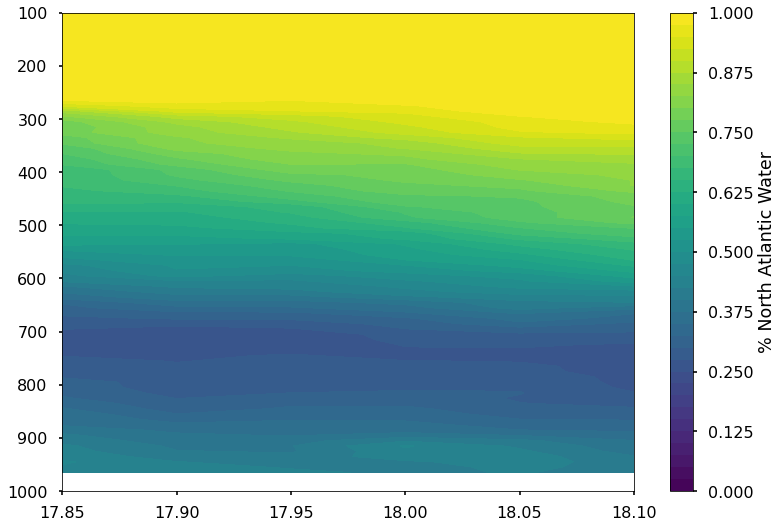

In [49]:
plt.contourf(df_2020_final.lat,df_2020_final.depth,np.nanmean(df_2020_final.naw_frac,axis=2),levels=np.arange(0,1.01,0.025))
plt.ylim(1000,100)
plt.colorbar(label='% North Atlantic Water')

/tmp/ipykernel_30289/3786683008.py:1: RuntimeWarning: Mean of empty slice
  plt.contourf(df_2020_final.lat,df_2020_final.depth,np.nanmean(df_2020_final.saw_frac,axis=2),levels=np.arange(0,1.01,0.025))


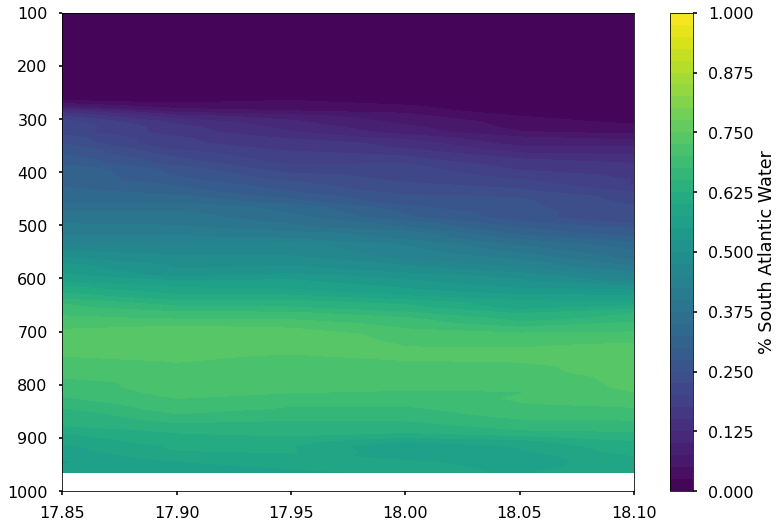

In [50]:
plt.contourf(df_2020_final.lat,df_2020_final.depth,np.nanmean(df_2020_final.saw_frac,axis=2),levels=np.arange(0,1.01,0.025))
plt.ylim(1000,100)
plt.colorbar(label='% South Atlantic Water')


## 2022

In [51]:
np.nansum(np.nanmean(df_2022_final.naw_transport,axis=2))

/tmp/ipykernel_30289/1887041703.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2022_final.naw_transport,axis=2))


-1.1719418481313784

In [52]:
np.nansum(np.nanmean(df_2022_final.saw_transport,axis=2))

/tmp/ipykernel_30289/234371692.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2022_final.saw_transport,axis=2))


-0.4693192338569543

In [53]:
np.nansum(np.nanmean(df_2022_final.transport,axis=2))

/tmp/ipykernel_30289/3663723316.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2022_final.transport,axis=2))


-1.6412610819883326

In [54]:
np.nansum(np.nanmean(df_2022_final.naw_transport,axis=2))/np.nansum(np.nanmean(df_2022_final.transport,axis=2))

/tmp/ipykernel_30289/3135396668.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2022_final.naw_transport,axis=2))/np.nansum(np.nanmean(df_2022_final.transport,axis=2))


0.7140496176949558

In [55]:
np.nansum(np.nanmean(df_2022_final.saw_transport,axis=2))/np.nansum(np.nanmean(df_2022_final.transport,axis=2))

/tmp/ipykernel_30289/1106390318.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2022_final.saw_transport,axis=2))/np.nansum(np.nanmean(df_2022_final.transport,axis=2))


0.28595038230504427

### just surface layer

In [56]:
np.nansum(np.nanmean(subset_ds_2022_surf_final.transport,axis=2))

/tmp/ipykernel_30289/602237023.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(subset_ds_2022_surf_final.transport,axis=2))


-0.4999255952042789

## total SAW

In [57]:
np.nansum(np.nanmean(df_2022_final.saw_transport,axis=2))+np.nansum(np.nanmean(subset_ds_2022_surf_final.transport,axis=2))

/tmp/ipykernel_30289/29435408.py:1: RuntimeWarning: Mean of empty slice
  np.nansum(np.nanmean(df_2022_final.saw_transport,axis=2))+np.nansum(np.nanmean(subset_ds_2022_surf_final.transport,axis=2))


-0.9692448290612332

/tmp/ipykernel_30289/3390171382.py:1: RuntimeWarning: Mean of empty slice
  plt.contourf(df_2022_final.lat,df_2022_final.depth,np.nanmean(df_2022_final.naw_frac,axis=2),levels=np.arange(0,1.01,0.025))


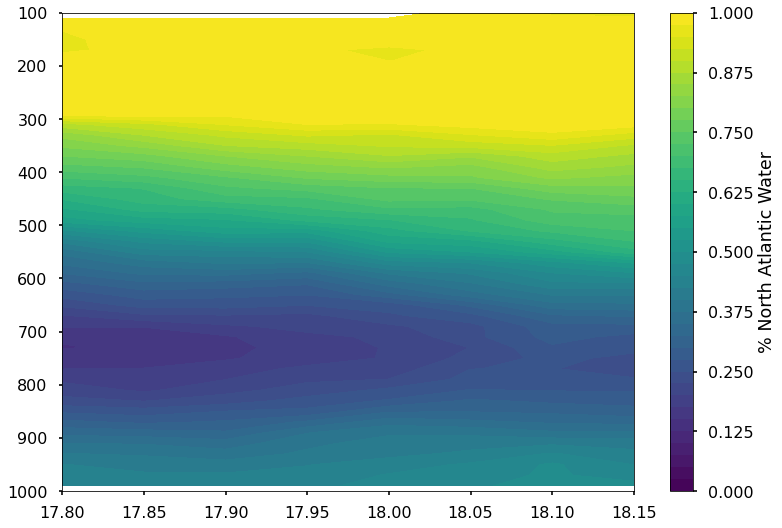

In [58]:
plt.contourf(df_2022_final.lat,df_2022_final.depth,np.nanmean(df_2022_final.naw_frac,axis=2),levels=np.arange(0,1.01,0.025))
plt.ylim(1000,100)
plt.colorbar(label='% North Atlantic Water')

/tmp/ipykernel_30289/3022784031.py:1: RuntimeWarning: Mean of empty slice
  plt.contourf(df_2022_final.lat,df_2022_final.depth,np.nanmean(df_2022_final.saw_frac,axis=2),levels=np.arange(0,1.01,0.025))


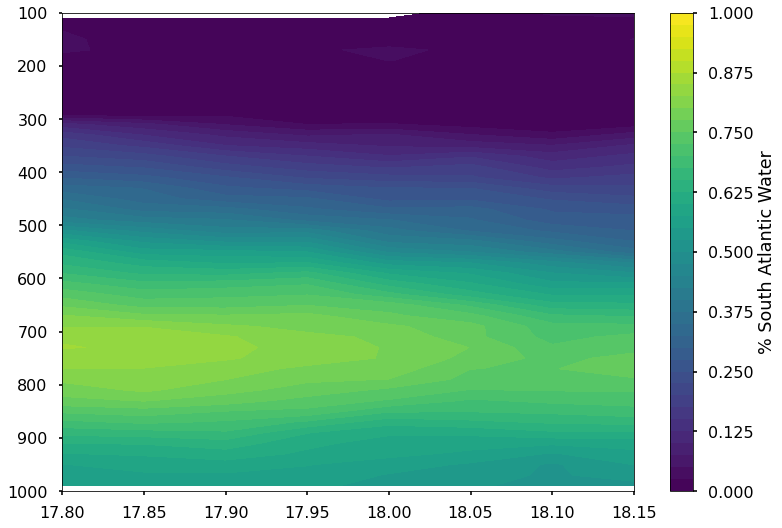

In [59]:
plt.contourf(df_2022_final.lat,df_2022_final.depth,np.nanmean(df_2022_final.saw_frac,axis=2),levels=np.arange(0,1.01,0.025))
plt.ylim(1000,100)
plt.colorbar(label='% South Atlantic Water')


## WOOHOO WE DID IT

/tmp/ipykernel_30289/2113083299.py:14: RuntimeWarning: Mean of empty slice
  first = ax1.contourf(df_2020_final.lat,df_2020_final.depth,np.nanmean(df_2020_final.saw_frac,axis=2),levels=levels)
/tmp/ipykernel_30289/2113083299.py:25: RuntimeWarning: Mean of empty slice
  second = ax2.contourf(df_2022_final.lat,df_2022_final.depth,np.nanmean(df_2022_final.saw_frac,axis=2),levels=levels)


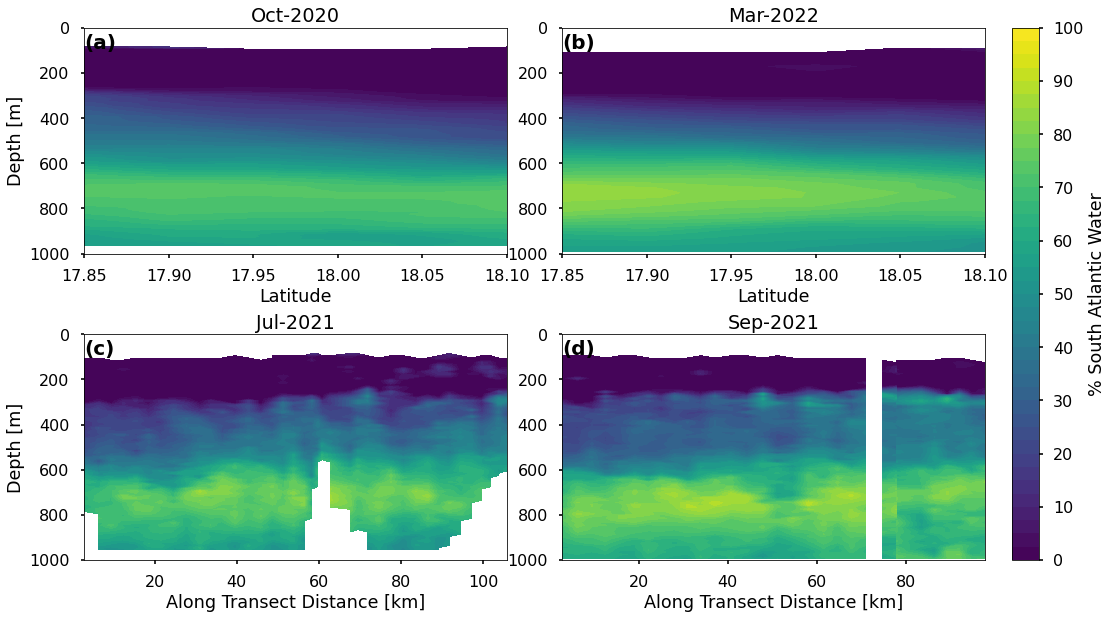

In [60]:
font_size = 20

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(16,8))


plt.tight_layout(pad=0.4, w_pad=1.5, h_pad=4.5)


axlist = [ax1,ax2,ax3,ax4]

levels=np.arange(0,1.01,0.025)


first = ax1.contourf(df_2020_final.lat,df_2020_final.depth,np.nanmean(df_2020_final.saw_frac,axis=2),levels=levels)
ax1.patch.set_facecolor('white')
ax1.set_title('Oct-2020')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Depth [m]')
#ax1.set_ylim(960,120)
ax1.set_ylim(1000,0)
ax1.set_xlim(17.85,18.10)
ax1.text(0,0.91,'(a)', transform=ax1.transAxes, size=font_size, weight='bold')


second = ax2.contourf(df_2022_final.lat,df_2022_final.depth,np.nanmean(df_2022_final.saw_frac,axis=2),levels=levels)
ax2.patch.set_facecolor('white')
ax2.set_title('Mar-2022')
ax2.set_xlabel('Latitude')
ax2.set_ylim(1000,0)
ax2.set_xlim(17.85,18.10)
ax2.text(0,0.91,'(b)', transform=ax2.transAxes, size=font_size, weight='bold')

third = ax3.contourf(np.cumsum(df_2021a_final.dist)/1000,df_2021a_final.depth,df_2021a_final.saw_frac,levels=levels)
ax3.patch.set_facecolor('white')
ax3.set_title('Jul-2021')
ax3.set_xlabel('Along Transect Distance [km]')
ax3.set_ylabel('Depth [m]')
ax3.set_ylim(1000,0)
ax3.text(0,0.91,'(c)', transform=ax3.transAxes, size=font_size, weight='bold')

fourth = ax4.contourf(np.cumsum(df_2021b_final.dist)/1000,df_2021b_final.depth,df_2021b_final.saw_frac,levels=levels)
ax4.patch.set_facecolor('white')
ax4.set_title('Sep-2021')
ax4.set_xlabel('Along Transect Distance [km]')
ax4.set_ylim(1000,0)
ax4.text(0,0.91,'(d)', transform=ax4.transAxes, size=font_size, weight='bold')

cbar = fig.colorbar(first, ax=axlist,label='% South Atlantic Water',pad=0.025)
cbar.get_ticks()
cbar.set_ticks([0,.10,.20,.30,.40,.50,.60,.70,.80,.90,1])
cbar.set_ticklabels([0,10,20,30,40,50,60,70,80,90,100])

plt.savefig('/home/jg1200/Figures/Percent_SAW_All.png',dpi=300,facecolor='white',bbox_inches='tight')


/tmp/ipykernel_30289/3625309070.py:14: RuntimeWarning: Mean of empty slice
  first = ax1.contourf(df_2020_final.lat,df_2020_final.depth,np.nanmean(df_2020_final.naw_frac,axis=2),levels=levels)
/tmp/ipykernel_30289/3625309070.py:24: RuntimeWarning: Mean of empty slice
  second = ax2.contourf(df_2022_final.lat,df_2022_final.depth,np.nanmean(df_2022_final.naw_frac,axis=2),levels=levels)


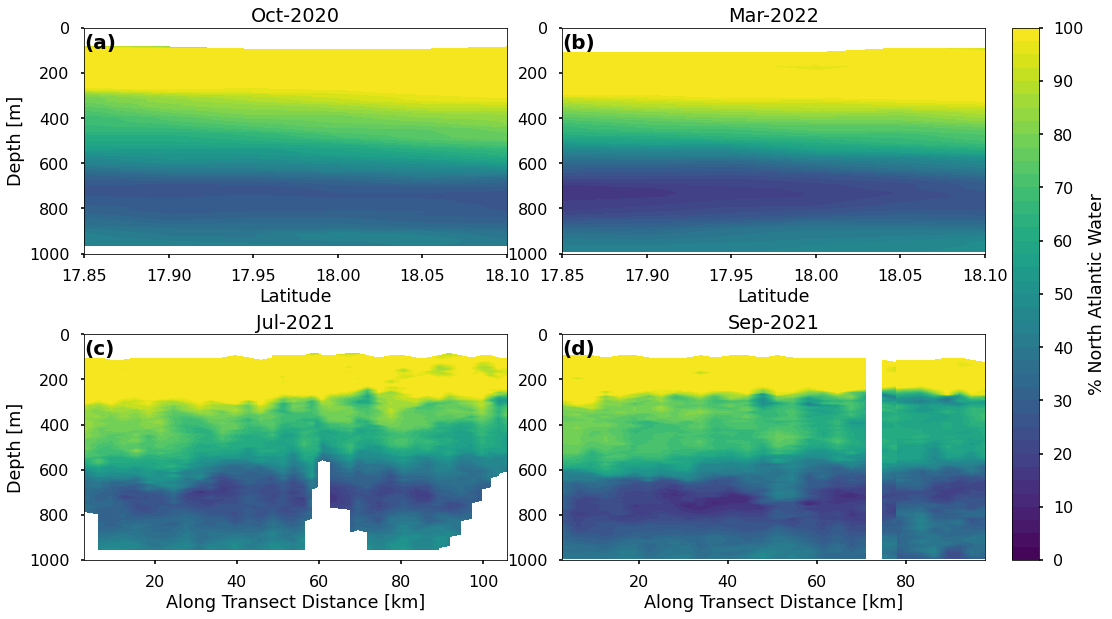

In [61]:
font_size = 20

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(16,8))


plt.tight_layout(pad=0.4, w_pad=1.5, h_pad=4.5)


axlist = [ax1,ax2,ax3,ax4]

levels=np.arange(0,1.01,0.025)


first = ax1.contourf(df_2020_final.lat,df_2020_final.depth,np.nanmean(df_2020_final.naw_frac,axis=2),levels=levels)
ax1.patch.set_facecolor('white')
ax1.set_title('Oct-2020')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Depth [m]')
ax1.set_ylim(1000,0)
ax1.set_xlim(17.85,18.10)
ax1.text(0,0.91,'(a)', transform=ax1.transAxes, size=font_size, weight='bold')


second = ax2.contourf(df_2022_final.lat,df_2022_final.depth,np.nanmean(df_2022_final.naw_frac,axis=2),levels=levels)
ax2.patch.set_facecolor('white')
ax2.set_title('Mar-2022')
ax2.set_xlabel('Latitude')
ax2.set_ylim(1000,0)
ax2.set_xlim(17.85,18.10)
ax2.text(0,0.91,'(b)', transform=ax2.transAxes, size=font_size, weight='bold')

third = ax3.contourf(np.cumsum(df_2021a_final.dist)/1000,df_2021a_final.depth,df_2021a_final.naw_frac,levels=levels)
ax3.patch.set_facecolor('white')
ax3.set_title('Jul-2021')
ax3.set_xlabel('Along Transect Distance [km]')
ax3.set_ylabel('Depth [m]')
ax3.set_ylim(1000,0)
ax3.text(0,0.91,'(c)', transform=ax3.transAxes, size=font_size, weight='bold')

fourth = ax4.contourf(np.cumsum(df_2021b_final.dist)/1000,df_2021b_final.depth,df_2021b_final.naw_frac,levels=levels)
ax4.patch.set_facecolor('white')
ax4.set_title('Sep-2021')
ax4.set_xlabel('Along Transect Distance [km]')
ax4.set_ylim(1000,0)
ax4.text(0,0.91,'(d)', transform=ax4.transAxes, size=font_size, weight='bold')

cbar = fig.colorbar(first, ax=axlist,label='% North Atlantic Water',pad=0.025)
cbar.get_ticks()
cbar.set_ticks([0,.10,.20,.30,.40,.50,.60,.70,.80,.90,1])
cbar.set_ticklabels([0,10,20,30,40,50,60,70,80,90,100])

plt.savefig('/home/jg1200/Figures/Percent_NAW_All.png',dpi=300,facecolor='white',bbox_inches='tight')


In [73]:
subset_ds_2022_surf_final.transport

<xarray.DataArray 'transport' (depth: 50, lat: 8, transect_num: 8)>
array([[[-2.00344586e-02, -1.48800803e-02, -3.96328652e-03, ...,
         -2.85397430e-02, -4.15998393e-02, -4.29467587e-02],
        [-2.00344586e-02, -1.10316053e-02, -3.96328652e-03, ...,
         -3.11854050e-02, -4.15998393e-02, -3.22803590e-02],
        [-7.10197138e-03, -1.71315180e-02, -4.57210545e-03, ...,
         -3.94418182e-02, -4.75861304e-02, -3.22803590e-02],
        ...,
        [ 5.99069554e-01, -2.68580204e-02, -1.41337035e-02, ...,
         -1.35101203e-02, -1.44980449e-02, -3.22803590e-02],
        [-1.67947856e-02, -4.42760456e-03, -3.66877990e-02, ...,
          4.31652175e-03,  6.20938917e-03, -3.22803590e-02],
        [-1.58573047e-02, -4.22842811e-03,  5.92460308e-04, ...,
          4.31652175e-03, -4.58159280e-03, -3.22803590e-02]],

       [[-2.01923143e-02, -1.63682400e-02, -4.22789881e-03, ...,
         -2.82602028e-02, -4.19691455e-02, -4.28346050e-02],
        [-2.01923143e-02, -1.17491784e-02, -4.22789881e-03, ...,
         -2.94198544e-02, -4.19691455e-02, -3.09152054e-02],
        [-8.32444253e-03, -1.76194563e-02, -4.27744653e-03, ...,
         -3.72314365e-02, -4.65000588e-02, -3.09152054e-02],
...
        [            nan,             nan,             nan, ...,
                     nan,             nan,  2.43625244e-03],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,  1.10471655e-03],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,  1.10471655e-03],
        [            nan,             nan,             nan, ...,
                     nan,             nan,  1.10471655e-03],
        [            nan,             nan,             nan, ...,
                     nan,             nan,  1.10471655e-03]]])
Coordinates:
  * depth         (depth) float64 10.0 30.0 50.0 70.0 ... 950.0 970.0 990.0
  * lat           (lat) float64 17.8 17.85 17.9 17.95 18.0 18.05 18.1 18.15
  * transect_num  (transect_num) int64 1 2 3 4 5 6 7 8

## more plots

In [97]:
df_2020_final.

<xarray.Dataset>
Dimensions:        (depth: 98, lat: 6, transect_num: 15)
Coordinates:
  * depth          (depth) float64 5.0 15.0 25.0 35.0 ... 955.0 965.0 975.0
  * lat            (lat) float64 17.85 17.9 17.95 18.0 18.05 18.1
  * transect_num   (transect_num) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Data variables:
    u              (depth, lat, transect_num) float64 nan nan nan ... nan nan
    v              (depth, lat, transect_num) float64 nan nan nan ... nan nan
    temp           (depth, lat, transect_num) float64 nan nan nan ... nan nan
    sal            (depth, lat, transect_num) float64 nan nan nan ... nan nan
    density        (depth, lat, transect_num) float64 nan nan nan ... nan nan
    time           (lat, transect_num, depth) datetime64[ns] NaT NaT ... NaT
    naw_frac       (depth, lat, transect_num) float64 nan nan nan ... nan nan
    saw_frac       (depth, lat, transect_num) float64 nan nan nan ... nan nan
    transport      (depth, lat, transect_num) float64 nan nan nan ... nan nan
    naw_transport  (depth, lat, transect_num) float64 nan nan nan ... nan nan
    saw_transport  (depth, lat, transect_num) float64 nan nan nan ... nan nan
Attributes:
    description:  Processed RU29 AD2CP and CTD data from the 2020 Deployment....

In [98]:
def calc_transport_by_water_mass_multiple(dft):
    
    smw_naw = np.nansum(np.nanmean(dft.naw_transport.values,axis=2)[np.where((np.nanmean(dft.density,axis=2)>=1024.5) & (np.nanmean(dft.density,axis=2)<1026.3))])
    smw_saw = np.nansum(np.nanmean(dft.saw_transport.values,axis=2)[np.where((np.nanmean(dft.density,axis=2)>=1024.5) & (np.nanmean(dft.density,axis=2)<1026.3))])

    ucw_naw = np.nansum(np.nanmean(dft.naw_transport.values,axis=2)[np.where((np.nanmean(dft.density,axis=2)>=1026.3) & (np.nanmean(dft.density,axis=2)<1026.8))])
    ucw_saw = np.nansum(np.nanmean(dft.saw_transport.values,axis=2)[np.where((np.nanmean(dft.density,axis=2)>=1026.3) & (np.nanmean(dft.density,axis=2)<1026.8))])

    lcw_naw = np.nansum(np.nanmean(dft.naw_transport.values,axis=2)[np.where((np.nanmean(dft.density,axis=2)>=1026.8) & (np.nanmean(dft.density,axis=2)<1027.1))])
    lcw_saw = np.nansum(np.nanmean(dft.saw_transport.values,axis=2)[np.where((np.nanmean(dft.density,axis=2)>=1026.8) & (np.nanmean(dft.density,axis=2)<1027.1))])

    iw_naw = np.nansum(np.nanmean(dft.naw_transport.values,axis=2)[np.where(np.nanmean(dft.density,axis=2)>=1027.1)])
    iw_saw = np.nansum(np.nanmean(dft.saw_transport.values,axis=2)[np.where(np.nanmean(dft.density,axis=2)>=1027.1)])

    d = {'SA': [iw_saw, lcw_saw, ucw_saw, smw_saw],'NA': [iw_naw, lcw_naw, ucw_naw, smw_naw] }
    df2 = pd.DataFrame(data=d, index=['IW', 'lCW', 'uCW', 'SMW'])

    return(df2)

def calc_transport_by_water_mass_single(dft):
    smw_naw = np.nansum(dft.naw_transport.values[np.where((dft.density>=1024.5) & (dft.density<1026.3))])
    smw_saw = np.nansum(dft.saw_transport.values[np.where((dft.density>=1024.5) & (dft.density<1026.3))])

    ucw_naw = np.nansum(dft.naw_transport.values[np.where((dft.density>=1026.3) & (dft.density<1026.8))])
    ucw_saw = np.nansum(dft.saw_transport.values[np.where((dft.density>=1026.3) & (dft.density<1026.8))])

    lcw_naw = np.nansum(dft.naw_transport.values[np.where((dft.density>=1026.8) & (dft.density<1027.1))])
    lcw_saw = np.nansum(dft.saw_transport.values[np.where((dft.density>=1026.8) & (dft.density<1027.1))])

    iw_naw = np.nansum(dft.naw_transport.values[np.where(dft.density>=1027.1)])
    iw_saw = np.nansum(dft.saw_transport.values[np.where(dft.density>=1027.1)])

    d = {'SA': [iw_saw, lcw_saw, ucw_saw, smw_saw],'NA': [iw_naw, lcw_naw, ucw_naw, smw_naw] }
    df2 = pd.DataFrame(data=d, index=['IW', 'lCW', 'uCW', 'SMW'])

    return(df2)

df_2020_water_mass_transport = calc_transport_by_water_mass_multiple(df_2020_final)
df_2021a_water_mass_transport = calc_transport_by_water_mass_single(df_2021a_final)
df_2021b_water_mass_transport = calc_transport_by_water_mass_single(df_2021b_final)
df_2022_water_mass_transport = calc_transport_by_water_mass_multiple(df_2022_final)

/tmp/ipykernel_30289/3608011493.py:3: RuntimeWarning: Mean of empty slice
  smw_naw = np.nansum(np.nanmean(dft.naw_transport.values,axis=2)[np.where((np.nanmean(dft.density,axis=2)>=1024.5) & (np.nanmean(dft.density,axis=2)<1026.3))])
/tmp/ipykernel_30289/3608011493.py:4: RuntimeWarning: Mean of empty slice
  smw_saw = np.nansum(np.nanmean(dft.saw_transport.values,axis=2)[np.where((np.nanmean(dft.density,axis=2)>=1024.5) & (np.nanmean(dft.density,axis=2)<1026.3))])
/tmp/ipykernel_30289/3608011493.py:6: RuntimeWarning: Mean of empty slice
  ucw_naw = np.nansum(np.nanmean(dft.naw_transport.values,axis=2)[np.where((np.nanmean(dft.density,axis=2)>=1026.3) & (np.nanmean(dft.density,axis=2)<1026.8))])
/tmp/ipykernel_30289/3608011493.py:7: RuntimeWarning: Mean of empty slice
  ucw_saw = np.nansum(np.nanmean(dft.saw_transport.values,axis=2)[np.where((np.nanmean(dft.density,axis=2)>=1026.3) & (np.nanmean(dft.density,axis=2)<1026.8))])
/tmp/ipykernel_30289/3608011493.py:9: RuntimeWarning: Mean o

<AxesSubplot:>

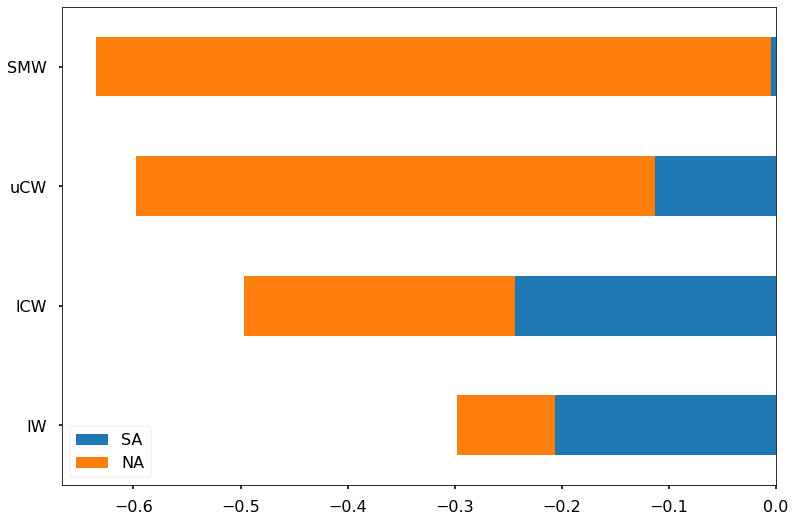

In [99]:
df_2020_water_mass_transport.plot.barh(stacked=True)

<AxesSubplot:>

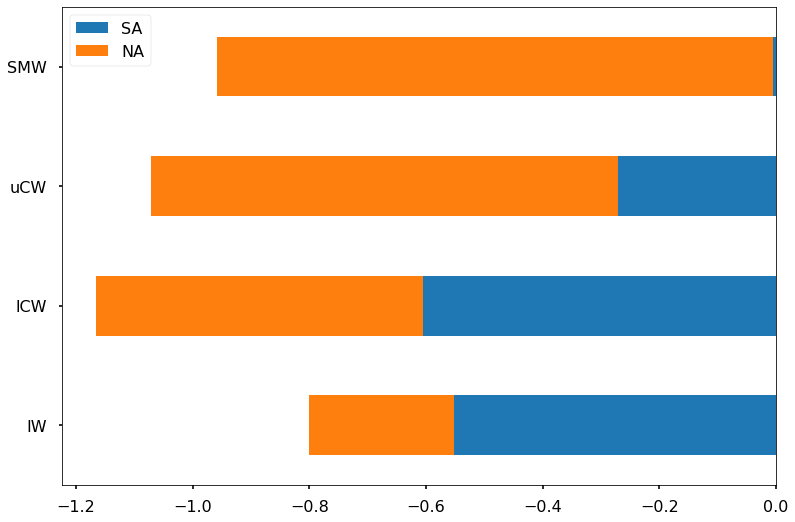

In [100]:
df_2021a_water_mass_transport.plot.barh(stacked=True)

<AxesSubplot:>

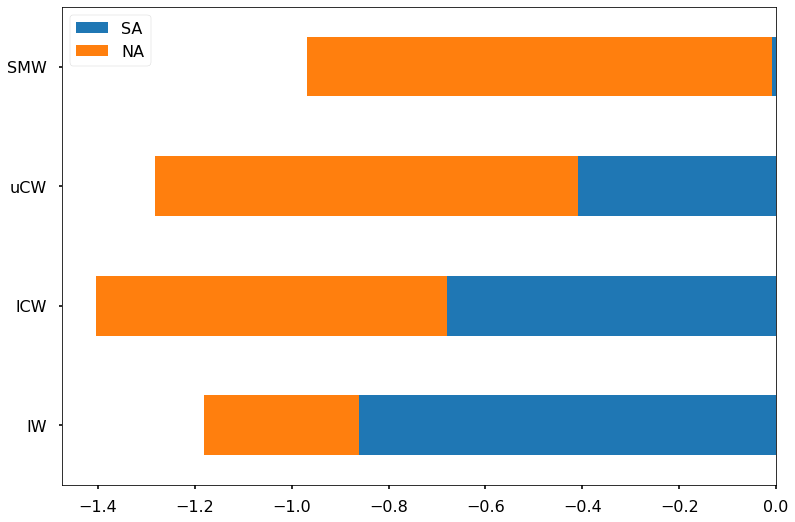

In [101]:
df_2021b_water_mass_transport.plot.barh(stacked=True)

<AxesSubplot:>

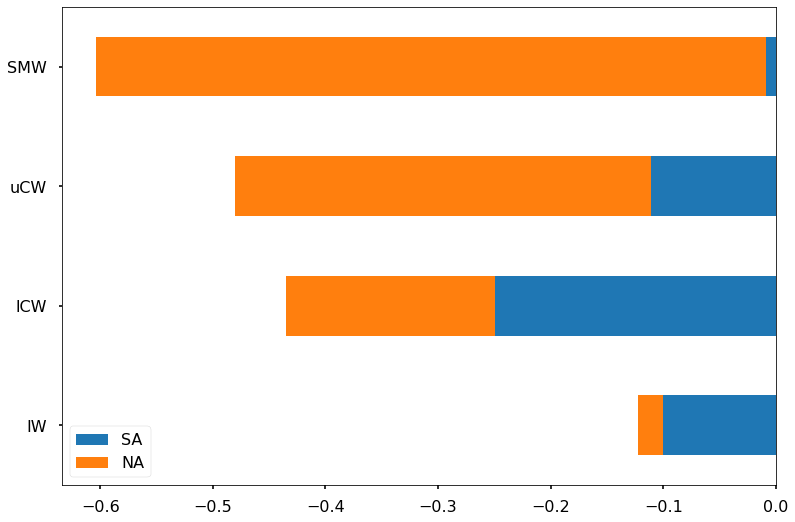

In [102]:
df_2022_water_mass_transport.plot.barh(stacked=True)

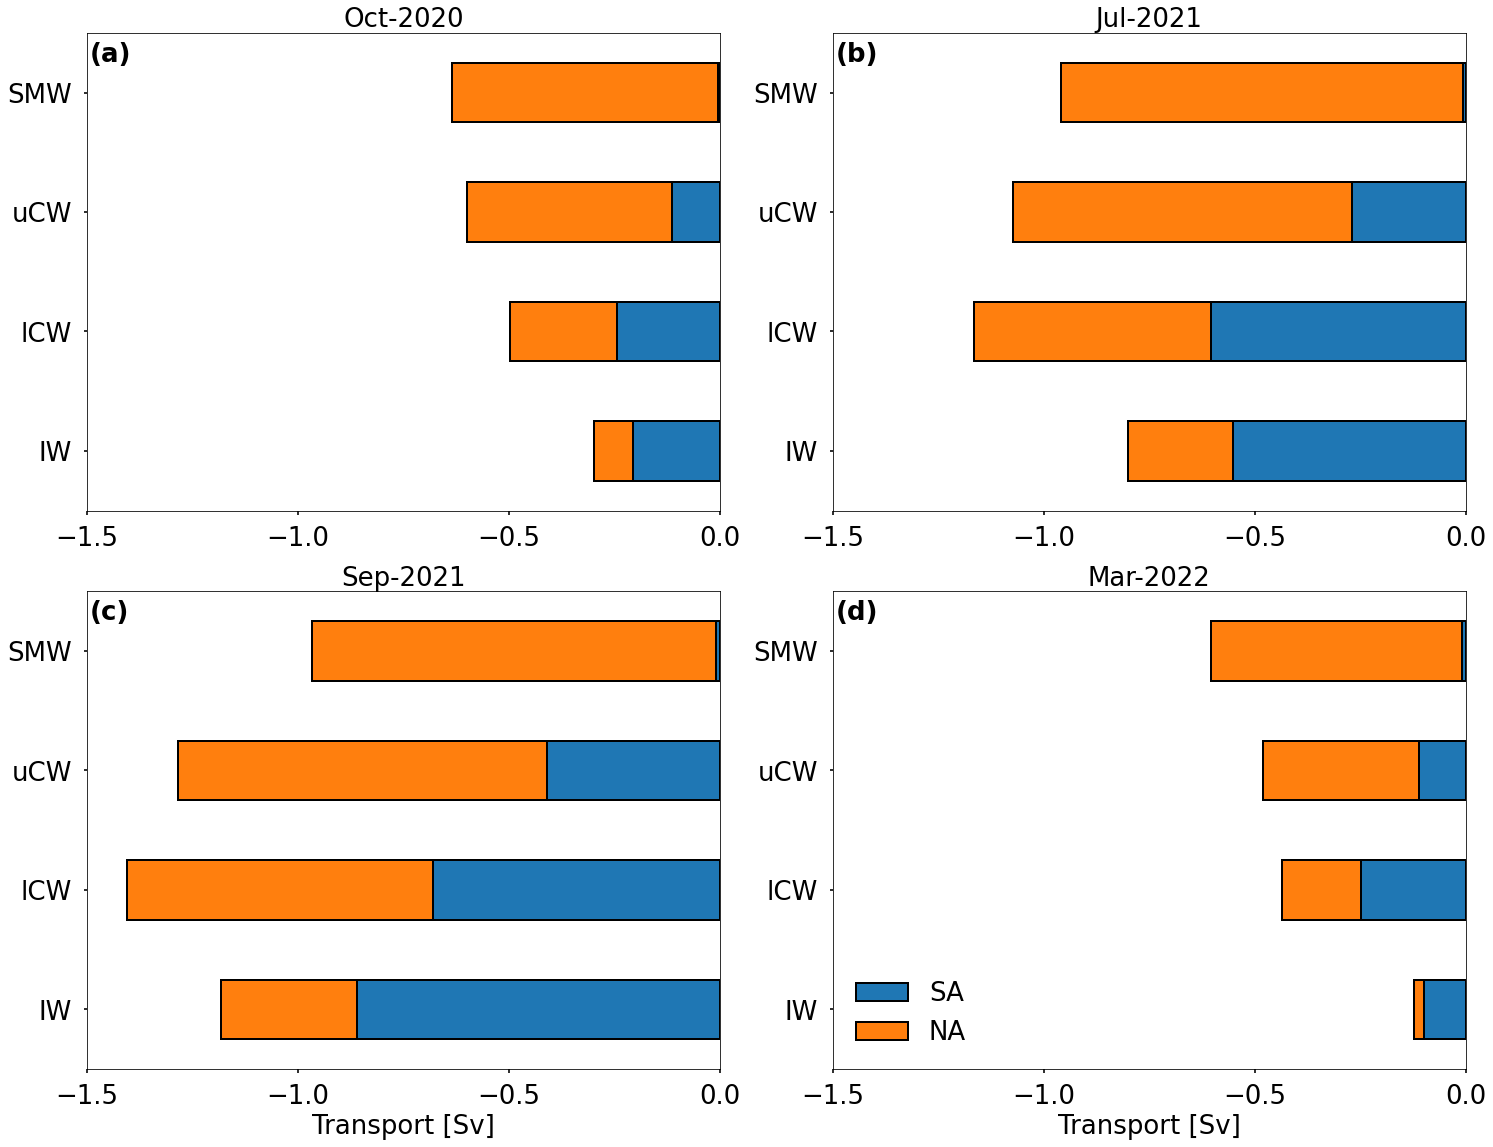

In [148]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

plt.tight_layout(pad=0.4, w_pad=6, h_pad=4.5)

font_size = 26

df_2020_water_mass_transport.plot.barh(stacked=True,ax=axs[0,0],color=['tab:blue','tab:orange'], edgecolor='black', linewidth=2)
axs[0,0].set_title('Oct-2020',fontsize=font_size)
axs[0,0].set_xlim(-1.5,0)
axs[0,0].set_xticks([-1.5,-1,-0.5,0])
axs[0,0].tick_params(axis='both', which='major', labelsize=font_size)
axs[0,0].text(0.005,0.94,'(a)', transform=axs[0,0].transAxes, size=font_size, weight='bold')
axs[0,0].get_legend().remove()

df_2021a_water_mass_transport.plot.barh(stacked=True,ax=axs[0,1],color=['tab:blue','tab:orange'], edgecolor='black', linewidth=2)
axs[0,1].set_title('Jul-2021',fontsize=font_size)
axs[0,1].set_xlim(-1.5,0)
axs[0,1].set_xticks([-1.5,-1,-0.5,0])
axs[0,1].tick_params(axis='both', which='major', labelsize=font_size)
axs[0,1].text(0.005,0.94,'(b)', transform=axs[0,1].transAxes, size=font_size, weight='bold')
axs[0,1].get_legend().remove()

df_2021b_water_mass_transport.plot.barh(stacked=True,ax=axs[1,0],color=['tab:blue','tab:orange'], edgecolor='black', linewidth=2)
axs[1,0].set_title('Sep-2021',fontsize=font_size)
axs[1,0].set_xlim(-1.5,0)
axs[1,0].set_xticks([-1.5,-1,-0.5,0])
axs[1,0].tick_params(axis='both', which='major', labelsize=font_size)
axs[1,0].text(0.005,0.94,'(c)', transform=axs[1,0].transAxes, size=font_size, weight='bold')
axs[1,0].get_legend().remove()
axs[1,0].set_xlabel('Transport [Sv]',fontsize=font_size)

df_2022_water_mass_transport.plot.barh(stacked=True,ax=axs[1,1],color=['tab:blue','tab:orange'], edgecolor='black', linewidth=2)
axs[1,1].set_title('Mar-2022',fontsize=font_size)
axs[1,1].set_xlim(-1.5,0)
axs[1,1].set_xticks([-1.5,-1,-0.5,0])
axs[1,1].tick_params(axis='both', which='major', labelsize=font_size)
axs[1,1].text(0.005,0.94,'(d)', transform=axs[1,1].transAxes, size=font_size, weight='bold')
axs[1,1].legend(fontsize=font_size,markerscale=6,frameon=False,loc='lower left')
axs[1,1].set_xlabel('Transport [Sv]',fontsize=font_size)

plt.savefig('/home/jg1200/Figures/Anegada_SAW_NAW_Transport_Water_Masses_Bar_Plot.png', bbox_inches='tight',dpi=300,facecolor='white')



In [144]:
df_2020_water_mass_transport

SA        NA
IW  -0.206017 -0.091558
lCW -0.243949 -0.252986
uCW -0.113125 -0.484847
SMW -0.004693 -0.630477

In [145]:
df_2021a_water_mass_transport

SA        NA
IW  -0.551648 -0.248674
lCW -0.604632 -0.561435
uCW -0.270744 -0.801216
SMW -0.005913 -0.952823

In [146]:
df_2021b_water_mass_transport

SA        NA
IW  -0.860452 -0.321303
lCW -0.679194 -0.725186
uCW -0.408874 -0.873914
SMW -0.008669 -0.958697

In [147]:
df_2022_water_mass_transport

SA        NA
IW  -0.100365 -0.021831
lCW -0.249221 -0.185812
uCW -0.110812 -0.369275
SMW -0.008921 -0.595024